# imports 

In [1]:
import warnings
warnings.filterwarnings("ignore")
#for handling RAM
import gc 

#stats
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import pingouin as pg


#my to go packages
import math
import random
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import matplotlib.ticker as ticker


#for readin
import glob # Package for Unix-style pathname pattern expansion
import os   # Python operating system interface

#for signal processing
from scipy.interpolate import CubicSpline,interp1d
import scipy.signal as signal
import scipy.stats as stats
from scipy.signal import filtfilt, butter
from scipy.fft import rfft, rfftfreq
from scipy.stats import sem 
from scipy.stats import norm
from scipy.stats import ttest_rel

#other packages
import ast
import itertools
from itertools import groupby
from more_itertools import consecutive_groups
import more_itertools as mit
from operator import itemgetter
import statistics
from sklearn.mixture import GaussianMixture



# functions

In [2]:
#helper functions for speed array
def find_abs_speed_noSmooth(timepoint,ps): #find the raw speed array without applying any smoothing

    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        ps = ps.values
        timepoint = timepoint.values
    except AttributeError:
        pass

    prev = abs((ps[1:-1] - ps[0:-2])/(timepoint[1:-1] -timepoint[0:-2]))
    post = abs((ps[1:-1] -ps[2:])/ (timepoint[1:-1] -timepoint[2:]))
               
    ds[1:-1] = np.where(prev >= post,prev,post)
    ds[0] = abs((ps[1] - ps[0])/ (timepoint[1] - timepoint[0]))
    ds[-1] = abs((ps[-1] - ps[-2])/ (timepoint[-1] - timepoint[-2]))
    
    return ds
def find_abs_speed_pup(ps): #this is same as find_abs_speed, but now using a smoothed speed array for pupil
    #by using 5 points to calculate speed instead of 2
    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        nminus1 = ps.iloc[1:-3].values
        nplus1 = ps.iloc[3:-1].values
        nminus2 = ps.iloc[0:-4].values
        nplus2 = ps.iloc[4:].values

        ds[0] = abs(ps.iloc[1] - ps.iloc[0])
        ds[1] = abs(ps.iloc[2] - ps.iloc[1])
        ds[-1] = abs(ps.iloc[-1] - ps.iloc[-2])
        ds[-2] = abs(ps.iloc[-2] - ps.iloc[-3])
    except AttributeError:
        nminus1 = ps[1:-3]
        nplus1 = ps[3:-1]
        nminus2 = ps[0:-4]
        nplus2 = ps[4:]

        ds[0] = abs(ps[1] - ps[0])
        ds[1] = abs(ps[2] - ps[1])
        ds[-1] = abs(ps[-1] - ps[-2])
        ds[-2] = abs(ps[-2] - ps[-3])
               
    ds[2:-2] = abs((nplus1 + nplus2- nminus1 - nminus2  )/6)
    
    
    return ds
def find_rel_speed(vec):
    #this is same as find_abs_speed_pup, except relative speed

    try:
        nminus1 = vec.iloc[1:-3].values
        nplus1 = vec.iloc[3:-1].values
        nminus2 = vec.iloc[0:-4].values
        nplus2 = vec.iloc[4:].values
    except AttributeError:
        nminus1 = vec[1:-3]
        nplus1 = vec[3:-1]
        nminus2 = vec[0:-4]
        nplus2 = vec[4:]
    #calculate derivative
    d = (nplus1 + nplus2- nminus1 - nminus2  )/6

    return d

In [3]:
#other helper functions
def consecutive(data, stepsize=10,
                findSame = False): # helper function for findGazeShift, deBlink, and more
    """
    @ data = row vector
    @ stepsize =  the larger the step size, the more difference it allows for two groups
                to be considered within the same cluster
    @ findSame = if True, find concecutive data point of the same value, this is set true
                 for finding blink counts using the blink mask (a df of 0 and 1 )
    """
    # this will split an array of numbers into many subarrays of consecutive numbers
    # the stepsize controls for how close of the two numbers for them to be considered
    # in the same cluster; e.g. [1,2,3,4,5,10] would be clustered together if stepsize = 5

    #data is the array of timepoint where the saccade velocity array crossed the threshold
    if findSame:
        stepsize = 0
        return np.split(data, np.where(abs(np.diff(data)) > stepsize)[0]+1)
    return np.split(data, np.where(np.diff(data) > stepsize)[0]+1)
def smooth(x,window_len=11,window='hanning'): #smoothing function
    try:
        x = x.values
    except:
        pass
    # about np windows:
    # https://numpy.org/doc/stable/reference/routines.window.html
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    #this is to prepare the input for convolve i.e. add 1/2 window length padding before and after
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]] 
    
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    #sliding window
    y=np.convolve(w/w.sum(),s,mode='valid')
    
    #get rid of the paddings
    return y[int(window_len/2):int(-0.5*window_len)] #select the data points to get rid of the delay
def strictly_increasing(L):#check if an array is uniformly increasing
    return all(x<y for x, y in zip(L, L[1:]))
def fs(width,height):#setting plot size
    plt.rcParams['figure.figsize'] = (width,height)


In [4]:
#function used for blink identification
def mad_func(ds,mad_threshold): #calculate the median absolute diviation (MAD)
    
    """
    function that calculate the median absolute diviation (MAD)
    ---------------------------------------------
    input: 
    ds: median absolute dilation speed, which is calculated in dilation_speed_filter
    mad_threshold: the threshold of median deviation (MAD); any data that is above median dilation speed + threshold*(MAD) will be rejected
    ---------------------------------------------
    output:
    returns a float and a boolean, first is the threshold, second is the bool array
    """
    try:
        ds = np.where(np.isnan(ds),0,ds)
    except:
        ds = np.where(ds.isnull(),0,ds)
    mad = np.nanmedian(abs(ds - np.nanmedian(ds))) # median absolute deviation
    rej_threshold = np.median(ds) + mad_threshold * mad # reject data above this threshold
       
    #returning an bool array, true = rejected, false = keep
    return (abs(ds) >= rej_threshold)  , rej_threshold
def reject_outlier(pt,rejarr, minGapLen = 0.03, borderlen = 0.05, borderlenBefore = 0,
                   freq = 1000): # 
    """
  
    ---------------------------------------------
    input:
    pt: pupil timestamps from pup_raw
    rejarr: pupil diameter with nans, assigning nan to the pupil array using the output of dilation_speed_filter()
    ---------------------------------------------
    output: return a dictionary, each key is the starting time of the nan value, each value is the end time of nan
    
    """
    borderN = borderlen* freq #number of adjacent data points that needs to be rejected
    borderNbefore = borderlenBefore * freq
    gapMinN = minGapLen * freq #number of data points in the gap
    
    b = np.where(rejarr==True, np.nan,rejarr)
    idx0 = np.flatnonzero(np.r_[True, np.diff(np.isnan(b))!=0,True])
    count = np.diff(idx0)
    idx = idx0[:-1]
    valid_mask =  np.isnan(b[idx])
    out_idx = idx[valid_mask]
    out_count = count[valid_mask]
    m = out_idx + out_count-1
    out = list(zip(out_idx, m))

    if len(out) == 0:
        return out

    #if the number of consecutively rejected data satisfies as a gap, record it
    outbool = np.array([(out[i][-1] - out[i][0])> gapMinN for i in range(len(out))])
    conRejarr = np.array(out)[outbool]
    gapCorrarr = [[]]*len(conRejarr)
    
    for i in range(len(conRejarr)):
        conRejarr[i][0] = max(0,conRejarr[i][0]-borderNbefore)
        #print(conRejarr[i][-1],conRejarr[i][-1]+borderN)
        conRejarr[i][-1] = min(len(pt)-1,conRejarr[i][-1]+borderN)
        gapCorrarr[i] = np.arange(conRejarr[i][0],conRejarr[i][-1]+1)
   
    return np.array(gapCorrarr)
def blkLen(rowInput,blkLen):#counts how many blink has occured using the mask df
    #blink len default = how many consecutive points for one event to be registered as blink
    #count this as 1 blink event
    boolMask = [list(g)[0]>0 for k, g in groupby(rowInput) ]
    repeatingVal = np.array([list(g) for k, g in groupby(rowInput)])
    
    blkArr = repeatingVal[boolMask]
    blkCnt = sum([len(i) > blkLen for i in blkArr])
    return blkCnt
def medianVariance(vec):#vec is the result from find_abs_speed_pup/sacc
    try:
        val = np.nanmedian(abs(vec - np.nanmedian(vec)))
    except:
        print('F**k! medianVariance function encountered an error:')
        print('dtype of vec:' + str(type(vec)))
        print('np.nanmedian(vec) :' + str(np.nanmedian(vec)))
    return val

In [5]:
#older functions
def interpolate_blink(paddedRejIndex,paddedRejBool, timestamp,pupilsize,
                      maxGapLen = 0.5,freq = 200):#paddedRejIndex = output from reject_outlier; ..Bool is the pseudodf['paddedDsRej']
    # check for the length for each gap, if it's longer than the maximum length defined for a gap
    # then don't interpolate, just leave it blank
    interpolateIndex = paddedRejIndex[[len(i)<maxGapLen*freq for i in paddedRejIndex]]
    """ i found that it works better to not smooth the pupil size
     """
    pupilsize = np.array(smooth(pupilsize))
   
    #for each blink, select the onset/offset pupil size, as well as two equal distant time point,call it ref list
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(timestamp)-1,i[-1] + len(i))]) for i in interpolateIndex])
    
    #use the refList to retrieve the paddedRejIndex, if more than 2 values are True, i.e. the first and last reference points
    #are also rejected data, then use the linear interpolation, else if the first and last ref points can be retrieved,
    #use cubic spline interpolation
    linearList = refList[np.sum(paddedRejBool.values[refList],axis = 1) > 2]
    cubicList = refList[np.sum(paddedRejBool.values[refList],axis = 1)== 2]
    
    #use the linearlist or cubic list, find the timestamp or pupilsize values used for interpolation
    cubictss = timestamp.values[cubicList]
    cubicarr = pupilsize[cubicList]#pupilsize.values[cubicList]
    
    lineartss = timestamp.values[linearList]
    lineararr = pupilsize[linearList]#pupilsize.values[linearList]
    
    #calculate the interpolated values; Index is the array of timestamp arrays, FuncList is the interpolated value
    cubicIndex = [np.array(timestamp.iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(timestamp.iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]
   
    return cubicIndex,csFuncList,linearIndex,lFuncList
def dsclean(thisdf,arr):
    """
    this is the main function for reject, clean, and interpolate
    thisdf is the df of the specific subject
    #1st it, arr = 'diameter_3d', 2+ it, arr = 'diameter_3dNew'
    
    note: outside the function, these four variables needs to be specified, e.g.
    maxGapLen = 1; minGapLen = 0.0 ; freq = 1000; gapMinN = minGapLen*freq; gapMaxN = maxGapLen*freq
    
    
    """
    #1st ite
    arr = thisdf[arr] #1st it, arr = diameter_3d, 2+ it, arr = diameter_3dNew
    rejarr,rejThreshold = mad_func(find_abs_speed(thisdf.pupil_timestamp,arr),3.5)    #need to get rid of zeros
    thisdf['dsRej'] = (rejarr == True) | (arr.isnull()) | (arr == 0)

    paddedDsRej = reject_outlier(thisdf.pupil_timestamp,thisdf.dsRej,minGapLen = minGapLen,borderlen=0.025,freq= 1000)
    thisdf['paddedDsRej'] = np.where(thisdf.index.isin(np.concatenate(paddedDsRej)),True,False)

    gapCorrarr = np.where(thisdf.paddedDsRej)[0]
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = [np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)] 

    #if the gap is shorter than minimum length, don't count it as a gap (but i've set min gap len to 0)
    outbool = np.array([(gapCorrarrParsed[i][-1] - gapCorrarrParsed[i][0])> gapMinN for i in range(len(gapCorrarrParsed))])
    gapCorrarrParsed = np.array(gapCorrarrParsed)[outbool]
    #correct the paddedDsRej, excluding shorter-than-gap values, i.e. set those to false
    thisdf['paddedDsRejNoGap'] = np.where(thisdf.index.isin(np.concatenate(gapCorrarrParsed)),True,False)

    #also don't interpolate for gap length longer than maximum gap len
    #first iteration use diameter 3d
    csts,csi,lts,li = interpolate_blink(paddedRejIndex = gapCorrarrParsed,
                                        paddedRejBool = thisdf['paddedDsRejNoGap'],
                                        timestamp = thisdf.pupil_timestamp,
                                        pupilsize = arr,
                                        freq = 1000) #this pupilsize is different for iteretions

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf['diameterThisIter'] = arr #this pupilsize is different for iteretions
    try:
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(csts)))[0],'diameterThisIter'] = np.concatenate(csi)
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(lts)))[0],'diameterThisIter'] = np.concatenate(li)
    except ValueError: 
        print('no array to concat')
    """
    minPup = np.mean(thisdf['diameterThisIter']) - 3*np.std(thisdf['diameterThisIter'])
    maxPup = np.mean(thisdf['diameterThisIter']) + 3*np.std(thisdf['diameterThisIter'])

    #also reject periods of pupil size that's larger the 3 sd away from the median, callit diameter_3dNew
    thisdf['diameter_3dNew'] = np.where(((thisdf['diameterThisIter']<minPup)|(thisdf['diameterThisIter']>maxPup)),0, thisdf['diameterThisIter'] )
    """
    return thisdf
def tlclean(thisdf,windown = 501,mad = 10,
            psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    thisdf['dsRej'] = (tlmad == True) | (thisdf[psCol].isnull() == True) | (thisdf[psCol] == 0)

    #don't pad the tl deviations
    arr = thisdf[psCol]
    gapCorrarr = (np.where(thisdf.dsRej)[0]) 
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = np.array([np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)]) 

    #preparation for interpolation
    interpolateIndex = gapCorrarrParsed[[len(i)<maxGapLen*freq for i in gapCorrarrParsed]]
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(thisdf[tsCol])-1,i[-1] + len(i))]) for i in interpolateIndex])
    increasingList = np.array([strictly_increasing(i) for i in refList])

    linearList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1) > 2) | (increasingList== False) ]
    cubicList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1)== 2) & (increasingList)]

    #use the linearlist or cubic list, find the thisdf[tsCol] or arr values used for interpolation
    cubictss = thisdf[tsCol].values[cubicList]
    cubicarr = arr.values[cubicList]
    #correct for nan
    cubicList = cubicList[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubictss = cubictss[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubicarr = cubicarr[np.isnan(cubicarr).sum(axis = 1) !=1] ##

    #for linear
    lineartss = thisdf[tsCol].values[linearList]
    lineararr = arr.values[linearList]
    #correct for nan
    linearList = linearList[np.isnan(lineararr).sum(axis = 1) !=1]##
    lineartss = lineartss[np.isnan(lineararr).sum(axis = 1) !=1]##
    linearr = lineararr[np.isnan(lineararr).sum(axis = 1) !=1] ##


    #calculate the interpolated values; Index is the array of thisdf[tsCol] arrays, FuncList is the interpolated value
    cubicIndex = [np.array(thisdf[tsCol].iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(thisdf[tsCol].iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf[psColNew] = arr #copy the old ps column, then modify it using the interpolated values
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(cubicIndex)))[0],psColNew] = np.concatenate(csFuncList)
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(linearIndex)))[0],psColNew] = np.concatenate(lFuncList)
    
    return thisdf
def tl(thisdf,windown = 501,mad = 10,
       psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    return tlmad
def tlFinal(x,y,windown = 101,mad = 10):
    #this is for doing trialwise tl rejection, not very necessay but since the input format
    #is slightly different from the tl function, i'm including it as a sepearte one
    cs = CubicSpline(x[~np.isnan(y)],
                    y[~np.isnan(y)])
    interp = cs(x)
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(y-smoothed,mad)[0]
    return tlmad

In [6]:
#core functions
def deBlink(rawPup,timestamp,
            returnMask = False,
            maxGapt = 2,
            minGapt= 0.003,
            freq = 1000,
            borderlenBef=0.001,
            borderlenAft=0.01,
            clusterLapse = 0.15,
            plotSteps = False,
            madThreshold = 3.5,
            ):
    """
    #this function clean the pupil array, and generate a boolean blink mask array
    @ rawPup = each row in the epoched pupil table
    @ timestamp = 
    @ returnMask: if true, return the boolean mask only (this is necessday because df.apply can't return two dfs)
    @ minGapt = 
    @ freq = 
    @ borderlenBef = paddings to add after each blink
    @ borderlenAft = paddings to add before each blink
    @ clusterLapse = larger value will count more distant blinks as one, resulting in more data rejected
    @ plotSteps = if True, generate a plot for the cleaning step
    @ madThreshold = speed threshold for rejection
    """
    #find the raw rej arr; This use a smoothed pupil change speed array to find the threshold
    #crossings
    rejarr = mad_func(find_abs_speed_pup(rawPup),madThreshold)[0] | (rawPup < 2000)

    #initialize two mask array, these will store the processed blink mask
    rejarr_padded = np.zeros(len(rejarr))
    rejarr_blkMask = np.zeros(len(rejarr))

    #pad the mask
    try:
        np.put(rejarr_padded, np.concatenate(reject_outlier(timestamp, rejarr, minGapLen= minGapt, borderlenBefore=borderlenBef,
                                                    borderlen=borderlenAft)), 1, mode='clip')
    except ValueError:
        rejarr_padded = rejarr

    #identify clusters in the mask (if two blink are too close, count them as one cluster and mask off the lapse between)
    #put the resulting mask into rejarr_blkMask, this will be returned as output
    try:
        consecutiveBlkFilter = np.array([np.arange(i[0], i[-1]+1) for i in consecutive(np.where(rejarr_padded)[0], 
                                                                                       stepsize= clusterLapse*freq)])
        np.put(rejarr_blkMask, np.concatenate(consecutiveBlkFilter), 1, mode='clip')
    except ValueError:
        rejarr_blkMask = rejarr_padded
    except IndexError: 
        return rawPup
        
    blkMask = rejarr_blkMask.copy()

    #just return the mask if necessary
    if returnMask:
        return blkMask

    """clean"""
    #use this mask to clean the pupil, mask off the data in blink
    #creating a copy for the plot because we will change the value of maskedPup 
    maskedPup_plt = np.where(rejarr_blkMask, np.nan, rawPup) 
    maskedPup = maskedPup_plt.copy() 

    """interpolation"""
    # reshape the clusted blink mask into arrays of clusted index, if its lenth if larger than the 
    # maximum gap lenth * frequency, then don't interpolate for this cluster, just leave it blank
    rejCluster = consecutive(np.where(rejarr_blkMask)[0], 1)
    rejCluster = np.array([k for k in rejCluster if len(k) < maxGapt*freq])

    #find four index for interpolation
    indexForInterp = np.array([np.array([max(0, i[0] - len(i)),
                                        max(0, i[0]-1),
                                        min(i[-1]+1, len(timestamp)-1),
                                        min(len(timestamp)-1, i[-1] + len(i))]) for i in rejCluster])
    
    #when applying this function to a df, sometime it required the input to be in specific format
    try:
        timestamp = timestamp.values
        rawPup = rawPup.values
    except AttributeError:
        timestamp = np.array(timestamp)
        rawPup = np.array(rawPup)
    
    #run the following if there there are available blink clusters for interpolation, interpolate
    try:
        #get the timestamp and pupil size (masked) for creating the interpolation function
        tsForInterp = timestamp[indexForInterp]
        cleanPupForInterp = maskedPup[indexForInterp]
        
        #get the timestemp for exptrapolate the missing pupil size
        tsForExtrap = [timestamp[i] for i in rejCluster]
        
        #for each available blink cluster,try use the cubic spline interpolation of 4 points
        #but if any point if nan, then use linear; but if it still can't (e.g. only one data point availble)
        #then don't interpolate, leave it as nan
        for i in range(len(rejCluster)):
            try:
                pupExtrapolated = CubicSpline(tsForInterp[i], cleanPupForInterp[i])(tsForExtrap[i].astype(float))
            except ValueError:
                try:  # if cant find reference points, use linear interpolation
                    pupExtrapolated = interp1d(tsForInterp[i][1:3], cleanPupForInterp[i][1:3])(tsForExtrap[i].astype(float))
                # if still gives error, then dont interpolate (usually the case with trial start/end)
                except ValueError:
                    pupExtrapolated = np.nan
            #fill each blink cluster with interpolated pupil value
            maskedPup[rejCluster[i]] = pupExtrapolated
    except IndexError:
        pass

    if plotSteps:
        fig, ax = plt.subplots(nrows=5)
        #plot speed and threshold of rejection
        sns.scatterplot(x= timestamp, y= find_abs_speed_pup(rawPup), ax=ax[0])
        ax[0].hlines(mad_func(find_abs_speed_pup(rawPup), 3.5)[1],
                    xmin=timestamp[0], xmax=timestamp[-100], colors='r')
        #plot the unfilted mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr, ax=ax[1])
        #plot the filtered mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr_blkMask, ax=ax[2])
        #plot the pupil data after it's been masked
        sns.scatterplot(x=timestamp, y=maskedPup_plt, ax=ax[3])
        #plot the interpolated pupil size
        sns.scatterplot(x=timestamp, y=maskedPup, ax=ax[4])
        
        ax[1].sharex(ax[0])
        ax[2].sharex(ax[0])
        ax[3].sharex(ax[0])
        ax[4].sharex(ax[0])

    
    return maskedPup
def findGazeShift(xvec,threshold = 6, countTogether = 50, 
                   baseline = None, winlen = 50,shiftmin = 2.14,
                   baselinePadding = 0):
    """
    @ xvec =  the gaze position (it should be each row in the saccRetro_X df)
    @ threshold = the velocity filter threshold
    @ countTogether = the maximum delay for two gaze shift cluster to be count as one
    @ baseline = if none, calculate relative baseline  (i.e. in regard to position before and after shift)
                else it should be a list of index to indicate baseline rage, e.g. [500,1000]
    @ winlen = for the onset of each identified gazeshift cluster, get the [-winlen,0] and [winlen, 2+ winlen]
            to calculate the mean gaze position before and after the shift occur
    @ shiftmin = the minimum shift in gaze position for it to be considered as a real shift
            default = 2.14 pixel = 0.057 visual degree
    @ baselinePadding = the padding to add before the identified gaze shift, this is only meaningful if baseline
                        is None (i.e. the shift regarding to gaze position before and after)
    
    """
    # get speed vector
    # since we are using 4 time points to calculate the speed array (see find abs speed sacc function)
    # the len of dx, dy is 4 points less than the length of xvec. 
    dx = find_abs_speed_sacc(xvec)
    #get threshold, then get a boolean array, for finding threshold crossing clusters
    thresholdx = [np.nanmedian(dx) + medianVariance(dx) *threshold,np.nanmedian(dx) - medianVariance(dx) *threshold]
    cx = (dx>thresholdx[0]) | (dx < thresholdx[1])
    cx = np.r_[False,False,cx,False,False] #correct for the four lost points


    # Deselect period at the beginning and the end of the position array i.e.掐头去尾
    # and re-identify the saccade cluster after applying both masks
    # if two clusteres are close enough (50ms), then count them as one
    onsetoffsetmask = np.r_[np.zeros(winlen + baselinePadding),np.ones(len(cx) - 3*winlen - 2* baselinePadding),np.zeros(2*winlen + baselinePadding)].astype(bool) #to deselect data in the first and last 50ms 
    maskedcx = np.where(cx & onsetoffsetmask)[0] 
    msCluster = consecutive(maskedcx,countTogether)

    # initialize the output array with zeros, calculate the mean pos before and after the shift
    gazeshift = np.zeros(len(xvec))    

    try:
        for i in msCluster:
            #if user doesn't provide a baseline value, use relative baseline
            if baseline == None:
                befIndex = [i[0] - winlen - baselinePadding,i[0]- baselinePadding]
            else:
                befIndex = baseline
            try:
                posbef = np.nanmean(xvec.iloc[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec.iloc[i[0] + winlen + baselinePadding : i[0] + 2*winlen + baselinePadding]) 

            except AttributeError: # this is to account for when using df.apply(raw = True),xvec is an array, not series
                posbef = np.nanmean(xvec[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec[i[0] + winlen + baselinePadding: i[0] + 2*winlen + baselinePadding]) 

            if abs(posaft - posbef) > shiftmin: 
                #toss away a ms if its less than a minimum visual degree 
                gazeshift[i[0]] = posaft - posbef 
            else:
                pass
    except IndexError: #i.e. if msCluster is empty, it gives error when trying to index i[0], in this case just return the 0 array
        return gazeshift
    return gazeshift

In [7]:
#this is originally used to linearly interpolate 
#missing saccade data
def linearInterpolate(x,y,method = 'linear'):
    """
    methods needs to be one of the scipy.interpolate.interp1d methods
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
    """
    #if the entire trial is nan, return nan
    if np.isnan(np.array(y)).sum() == len(y):
        interp = np.empty(len(y))
        interp[:] = np.nan
        return interp
    #else,interpolate
    try:
        li = interp1d(x[~y.isnull()],
                        y[~y.isnull()],
                        fill_value="extrapolate",kind = method)
        interp = li(x)
    except AttributeError: #handling np.array and pandas df conversion
        li = interp1d(x[~np.isnan(y)],
                        y[~np.isnan(y)],fill_value="extrapolate",kind = method)
        
    interp = li(x)
    return interp

In [8]:
#plotting function
def legend_without_duplicate_labels(ax,locVal = 'best'):
    #https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc = locVal)
def deBlinkSample(rawPup, samplesize = 10): #plot n trial samples with the deblink process
    fs(12,12)
    select = np.random.randint(0,len(rawPup),size = samplesize)

    #select some smaple 
    sample_raw = rawPup.iloc[select,1:]

    #Clean once
    cleanOnceSample = sample_raw.apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                                clusterLapse = 0.05, borderlenAft = 0.2,
                                                borderlenBef= 0.05,madThreshold = 4),axis = 1,raw = True)

    #second clean
    onceSmoothSample = cleanOnceSample.rolling(11,min_periods=1,center  = True,axis =1).mean()
    cleanTwiceSample = onceSmoothSample.apply(lambda x: deBlink(rawPup = x,timestamp = np.linspace(0,5,len(x)),
                                            borderlenBef = 0.05,borderlenAft = 0.05,minGapt = 0.002,
                                            clusterLapse = 0.05,madThreshold = 6),axis =1,raw = True)
    fig,ax = plt.subplots(nrows = 3)

    x = np.linspace(0,5,5000)
    [ax[0].plot(x,sample_raw.iloc[i,:],alpha = 0.8) for i in range(len(select))]
    [ax[1].plot(x,cleanOnceSample.iloc[i,:],alpha = 0.84,linewidth = 2) for i in range(len(select))]
    [ax[2].plot(x,cleanTwiceSample.iloc[i,:],alpha = 0.8,linewidth = 2) for i in range(len(select))]

    ax[1].set_ylim(ax[2].get_ylim())
    ax[0].set_ylim(ax[2].get_ylim())

    plt.show()
def pupilPlot(normPup,blPup, 
              eventt = 3,
              blt  = 0.1,
              freq = 1000,
              type = 'grand',
              levels = ['cue_blk_validity','cued_item'],
              pltRatio = [0.2,3], pltN = 3,
              eventBoundary = [0,0.5,2.5],
              eventName = ['retrocue','delay','probe'],
              blHeight = None,
              cList = [],
              figH = 5.5, figW = 16,
              tightPlot = True,
              textSize = 12,
              ):
    """
    @ normPup = normalized pupil df with trial info columns in the end
    @ blPup = the pupil df with the baseline
    @ eventt = the time for the event of interest
    @ blLen = the time for the baseline
    @ freq = sampling frequency, defalut 1000
    @ type = the type of plot, 
           - grand avg: ;
           - subj avg: ;
    @ levels = the group by levels, e.g. block validity and cued item
    @ pltRatio = ratio for the plot for baseline and event
    @ pltN = how many plots, default 3
    @ eventBoundary = use to plot vertical lines on the plot to represent certain events
    @ eventName = the text label for these events
    @ blHeight = ylim for the baseline plots, if None, set ylim using max and min
    @ cList = the color list used for plots; default color- the ones i carefully preseletced, very pretty
    @ figH = figure height for each plot, default 5.5
    @ figW = figure width, default 16
    @ tightPlot = if true, set the plot layout to be tighter
    @ textSize = the text label on the plot size
    --------------
    return NormMean: the groupby df
    """
    eventLen = int(eventt*freq)
    blLen = int(blt*freq)

    if not type in ['grand','subj']:
        raise 'Your plot should either be grand avg or subj avg'
    if len(eventBoundary) != len(eventName):
        raise 'your event name array should be the same size as your event boundary(time) array'
    if type == 'grand':
        normmean = normPup.groupby(levels).mean().iloc[:,:eventLen]
        norm_sterr = normPup.groupby(levels).sem().iloc[:,:eventLen]
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 
        try:
            normmeanBL = blPup.groupby(levels).mean().iloc[:,:blLen]
            norm_sterrBL = blPup.groupby(levels).sem().iloc[:,:blLen]
            norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
            norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]
        except:
            normmeanBL = None
            norm_sterrBL = None
            norm_upperBL = None
            norm_lowerBL = None
        #the mean df will be returned
        returnMean = normmean    
        returnSd = norm_sterr
    elif type == 'subj':
        subj_levels = levels + ['subj']
        normmean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).mean()
        norm_sterr = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).sem()
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 
        try:
            normmeanBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).mean()
            norm_sterrBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).sem()
            norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
            norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]
        except:
            normmeanBL = None
            norm_sterrBL = None
            norm_upperBL = None
            norm_lowerBL = None
            
        #the subj df will be returned
        returnMean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen]
        returnSd =  normPup.groupby(subj_levels).sem().iloc[:,:eventLen]

    condN = normmean.shape[0]
    #if color list is not right length, use sns generated color
    if len(cList) < condN:
        print('input color list is too short, plot default color ')
        cList = sns.color_palette("flare",n_colors = condN)
     
    #setting up plotting params
    fs(figW,pltN*figH) #set figure size
    fig,ax = plt.subplots(nrows= pltN, ncols=2, sharex=False, sharey = False,
                          gridspec_kw={'width_ratios': pltRatio,})
    x = np.linspace(0,eventt,norm_sterr.shape[1])
    try:
        xBL = np.linspace(0,blt,norm_sterrBL.shape[1])
        if blHeight == None:
            blHeight = [norm_lowerBL.min().min(), norm_upperBL.max().max()]
    except:
        xBl = 0
        blHeight = 0

    #plot mean plot for the baseline and for the trial
    try:
        [ax[i//2][0].fill_between(xBL,norm_upperBL.iloc[i,0:norm_sterrBL.shape[1]],norm_lowerBL.iloc[i,0:norm_sterrBL.shape[1]],
                            color = cList[i],alpha = 0.2,)  for i in range(condN)]
        [ax[i//2][0].plot(xBL,normmeanBL.iloc[i,0:norm_sterrBL.shape[1]],linewidth = 2.5,color = cList[i],) for i in range(condN) ]
        [ax[i][0].set_ylim(blHeight) for i in range(pltN)]
    except:
        print('no baseline passed in')

    [ax[i//2][1].fill_between(x,norm_upper.iloc[i,0:norm_sterr.shape[1]],norm_lower.iloc[i,0:norm_sterr.shape[1]],
                        color = cList[i],alpha = 0.1, )  for i in range(condN)]
    [ax[i//2][1].plot(x,normmean.iloc[i,0:norm_sterr.shape[1]],color = cList[i],linewidth = 2,) for i in range(condN) ]
    
    
    #add vertical line and text
    for ff in range(pltN):
        ax[ff][1].vlines(eventBoundary,norm_lower.min().min(),
                         norm_upper.max().max(),linestyles = 'dashed',colors= 'black')
    for i,m in zip(eventBoundary,eventName):
        ax[0][1].text(i,norm_upper.max().max(),m,c = 'black',size = textSize)
    
    #make the plots tighter
    if tightPlot:
        plt.subplots_adjust(hspace = 0.1)
        plt.subplots_adjust(wspace = 0.06)
        
    #plt.xticks(fontsize= figW, )
    plt.show()

    return returnMean,returnSd

In [9]:
# for behavioral response from psychopy

def find_click_time(click,time):
    try:
        rt = time[np.nonzero(click)[0][0]]
    except IndexError:
        rt = np.nan
    return rt

# load params

In [10]:
pd.set_option('display.max_columns', 500)


In [11]:
#read in the mega df
local_username = 'yud070'
pathEL = 'Z:/LiteBrite_YueyingDong/22AK01ELRaw_tracker/'
pathpy = 'Z:/LiteBrite_YueyingDong/22AK01ELRaw_psychopy/'

readIn = [f for f in os.listdir(pathEL)]

In [12]:
relevantCols = ['RECORDING_SESSION_LABEL','AVERAGE_GAZE_X',
       'AVERAGE_GAZE_Y','AVERAGE_PUPIL_SIZE','EYE_TRACKED','IP_LABEL','IP_START_TIME',
      'LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','SAMPLE_MESSAGE','TIMESTAMP','TRIALID']
pupCols = ['EYE_TRACKED','LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','AVERAGE_PUPIL_SIZE',
           'IP_LABEL','TIMESTAMP','TRIALID']

In [13]:
#plotting params // pending refractor
ts = [1000,1250,1750,2250,4250,4750] #stim onset, rest, retrocue, delay, probecue

fixation_ts = 0.5
stim_ts = 0.25 #+ fixation_ts
precue_ts = 0.5 + stim_ts
retrocue_ts = 0.5 + precue_ts
post_cue_ts = 2 + retrocue_ts
probe_cue = 0.5 + post_cue_ts
probe_ts = 3 + post_cue_ts
iti = 0.5 + probe_ts

epoch_array = np.array([0,stim_ts,precue_ts,retrocue_ts,post_cue_ts,probe_cue])#[,post_cue_ts,,probe_ts]
epoch_name = ['stim','rest','retrocue','rest','probe_cue','probe']


In [14]:
epoch_array

array([0.  , 0.25, 0.75, 1.25, 3.25, 3.75])

In [15]:
#some specified params
leftEyeSubj = ['173','175']
rightEyeSubj = ['183','185']

#events
events = ['fixateRest','stim','precueRest', 'retrocue',
                            'postcueRest','probecue', 'probe', 'ITI','trialEnd']
eventIndex = [0,1000,1250, 1750,2250,4250,4750,7750,8250]
eventInfo = dict(zip(events,eventIndex))

In [16]:
#take the first 5s in each recording, though the interest period is [0.5,4.75], but the padding
#is included for better interpolating

#params for reading in
included = 5000

#params for cleaning
sdThreshold = 6
pltAll = True
interpCorrection = np.zeros(len(readIn))
maxGapLen = 0.5
minGapLen = 0.0
freq = 1000
gapMinN = minGapLen*freq

In [17]:
#for plotting
cList = ['#fda48c','#f23908','#93648f','#33202a','#66b3ba','#03838f',]
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#593247'} #{"['high']":'red',"['medium']":'green',"['low']":'blue'}


# readIn Files

In [18]:
pathUnparsed = 'Z:/LiteBrite_YueyingDong/temp/unparsed/'


In [19]:
#read behav
psyFull = pd.read_csv('Z:/LiteBrite_YueyingDong/temp/cleanBehav.csv')#.iloc[:,1:]
psyFull.set_index('identifier',inplace=True)


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
psyFull['cue_posi'] = psyFull.cue_posi.replace({0:'right',1:'left'})

### readin Pupil

In [21]:
pupFullTrial_raw = pd.concat((pd.read_csv(f).iloc[:,1:] for f in glob.glob(pathUnparsed + 'pupRaw'+'/*.csv')), ignore_index=True)

NameError: name 'pathUnparsed' is not defined

In [26]:
pupClean = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/cleanPup_parsedByEventMarker_normalized/cleanPupRetroNorm_byEvents.csv')

### readin events

In [76]:
eventDf = pd.concat((pd.read_csv(f).iloc[:,1:] for f in glob.glob(pathUnparsed + 'event'+'/*.csv')), ignore_index=True)

### readin gaze

In [ ]:
saccFullTrial_x_raw = pd.concat((pd.read_csv(f).iloc[:,1:] for f in glob.glob(pathUnparsed + 'saccX'+'/*.csv')), ignore_index=True)
saccFullTrial_y_raw = pd.concat((pd.read_csv(f).iloc[:,1:] for f in glob.glob(pathUnparsed + 'saccY'+'/*.csv')), ignore_index=True)

In [ ]:
pupFullTrial_raw.shape,eventDf.shape,saccFullTrial_x_raw.shape,saccFullTrial_y_raw.shape

((14644, 5001), (14644, 10), (14593, 5001), (14593, 5001))

# processing

## mask

### clean

In [ ]:

#also return the blink mask; the mask have a high positive rate, i set the mad threshold to be higher
#to be more certain for blinks
maskClean = pupFullTrial_raw.iloc[:,1:].apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                              borderlenBef= 0.05, borderlenAft = 0.2,
                                              clusterLapse = 0.05, madThreshold = 6,returnMask = True),axis = 1,raw = True)
maskClean.insert(0,'TRIALID',pupFullTrial_raw.TRIALID)



In [ ]:
#find trials that are in both saccfull and in mask
sharedTrl = list(set(saccFullTrial_x_raw.TRIALID) & set(maskClean.TRIALID))
gazeMask = maskClean[maskClean.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)

saccTemp_x = saccFullTrial_x_raw[saccFullTrial_x_raw.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)
saccTemp_y = saccFullTrial_y_raw[saccFullTrial_y_raw.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)

In [ ]:
#sanity check, the trial label should be the same, if not raise error
if (sum(gazeMask.TRIALID != saccTemp_x.TRIALID) == 0) & (sum(gazeMask.TRIALID != saccTemp_y.TRIALID) == 0):
    #put the mask on
    saccTemp_x.iloc[:,1:] = saccTemp_x.iloc[:,1:].mask(gazeMask.iloc[:,1:].astype(bool),np.nan)
    saccTemp_y.iloc[:,1:] = saccTemp_y.iloc[:,1:].mask(gazeMask.iloc[:,1:].astype(bool),np.nan)
else:
    raise('TRIALID mismatch between saccade raw and saccade mask')

# interpolate

In [ ]:
#aggregate the sacc temp x and y dfs
saccTemp_x['axis'] = 'x'
saccTemp_y['axis'] = 'y'
saccTemp = pd.concat([saccTemp_x,saccTemp_y]).reset_index(drop = True)

In [ ]:
#interpolation of gaze data
x = np.linspace(0,5,included)
saccClean = saccTemp.iloc[:,1:included+1].apply(lambda y: linearInterpolate(x,y,method='nearest'),axis = 1,raw = True)
saccClean.insert(0,'TRIALID',saccTemp.TRIALID)
saccClean.insert(0,'axis',saccTemp.axis)

# re-unit

In [ ]:
saccClean.set_index(['axis'],inplace=True)

In [ ]:
saccClean.loc['x'].iloc[:,1:] = (saccClean.iloc[:,1:].loc['x'] -960)*100/960
saccClean.loc['y'].iloc[:,1:] = (saccClean.iloc[:,1:].loc['y'] -540)*100/540

# reject

In [ ]:
saccBLWindow = [500,1000]

In [ ]:
#1.5 visual degree is roughly 52 pixel for both x and y
#the euclean distance threshold is this
deg1VADeviation = np.sqrt((57.24*100/960)**2+(57.24*100/540)**2)

## trial rejection

### missing + drift fixation

In [ ]:
# get the eucledian distance from the center
eucDist_Perc = pd.DataFrame(np.sqrt(saccClean.loc['x'].iloc[:,1:].values**2 + saccClean.loc['y'].iloc[:,1:].values**2))
eucDist_Perc.insert(0,'identifier',saccClean.loc['x'].TRIALID.values)

In [ ]:
#if during the last 500ms of the fixtaion period, mean gaze position deviates from the threshold, reject the trial
saccRejID = eucDist_Perc[(eucDist_Perc.iloc[:,saccBLWindow[0]:saccBLWindow[1]].mean(axis =1)>deg1VADeviation)].identifier
#also if a trial has more than 12.5% data missing during the retrocue - probe epoch, then reject this
saccRejID = set(saccRejID) | set(saccClean[saccClean.iloc[:,1750:4750].isnull().sum(axis = 1) > 3000*0.125].TRIALID),

In [ ]:
#reject trials with invalid fixation, too much missing, and 
saccTemp = saccClean[~saccClean.TRIALID.isin(list(saccRejID[0]))]
#also only select the trials that are in psyfull (i.e. trials that has a respose)
saccTemp = saccTemp[saccTemp.TRIALID.isin(psyFull.index.values)]

In [ ]:
len(saccRejID)

244

### missing + pupil rej (9.26)

In [27]:
saccRejID = saccClean[saccClean.iloc[:,1750:4750].isnull().sum(axis = 1) > 3000*0.125].TRIALID

In [30]:
#reject trials with invalid fixation, too much missing, and 
saccTemp = saccClean[saccClean.TRIALID.isin(list(set(pupClean.identifier)  - set(saccRejID)))]
#also only select the trials that are in psyfull (i.e. trials that has a respose)
saccTemp = saccTemp[saccTemp.TRIALID.isin(psyFull.index.values)]

In [38]:
len(saccTemp)/2

13844.0

## subj rejection

In [32]:
saccTemp['subj'] = [ast.literal_eval(i)[0] for i in saccTemp.TRIALID]

In [33]:
#remove a subj if they have more than 30% trls missing
trlCnt = saccTemp.subj.value_counts().reset_index().rename(columns = {'index':'subj','subj':'trlLeft'})
trlCnt['trlLeft'] = trlCnt['trlLeft']/2

saccRejSubj = set(trlCnt[trlCnt.trlLeft < 0.7*300].subj.values)
#saccRejSubj.remove("154")

In [34]:
saccRejSubj

set()

In [35]:
#remove these subjs (7 people)
saccClean_rej = saccTemp[~saccTemp.subj.isin(saccRejSubj)]

psyFull.reset_index(drop = False,inplace=True)
saccClean_rej.reset_index(drop = False,inplace=True)

In [36]:
#merge the trl label columns from the psychopy file
saccClean_rej = saccClean_rej.merge(psyFull[['identifier','cue_posi','blk_validity']],how = 'left',
                    left_on = 'TRIALID', right_on = 'identifier').drop('identifier',axis = 1)

In [37]:
saccClean_rej = saccClean_rej.reindex(columns=np.r_[np.arange(0,5000),['axis','TRIALID','subj','cue_posi','blk_validity']])

# epoching

In [82]:
#reset index for the files
eventDfSacc = eventDf[eventDf.TRIALID.isin(towardFreq.identifier)].reset_index(drop = True)
#sort to ensure the trial id match
saccClean_rej = saccClean_rej.sort_values(['TRIALID','axis']).reset_index(drop = True)
eventDfSacc = eventDfSacc.sort_values('TRIALID').reset_index(drop = True)

#sanity check, if this is not 0, stop running the following
sum(saccClean_rej.iloc[::2,:].TRIALID.values != eventDfSacc.TRIALID.values )

In [84]:
#variable index parsing
tsAllBL = [np.arange(i- 500,i + 100) for i in eventDfSacc.stim]
tsAll = [np.arange(i,i + 3750) for i in eventDfSacc.stim]

tsRetroBL = [np.arange(i- 500,i+ 100) for i in eventDfSacc.retrocue]
tsRetro = [np.arange(i,i + 3000) for i in eventDfSacc.retrocue]

In [ ]:
#parse for x and y
saccClean_rejX = saccClean_rej[saccClean_rej.axis  == 'x'].reset_index(drop = True)
saccClean_rejY = saccClean_rej[saccClean_rej.axis  == 'y'].reset_index(drop = True)

In [ ]:
#variable parse for alltrial 
saccAllBLX = pd.DataFrame(data=[saccClean_rejX.iloc[x:x+1,y].values[0] for x,y in enumerate(tsAllBL)])
saccAllX = pd.DataFrame(data=[saccClean_rejX.iloc[x:x+1,y].values[0] for x,y in enumerate(tsAll)])

#parse for retrocue
saccRetroBLX = pd.DataFrame(data=[saccClean_rejX.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetroBL)])
saccRetroX = pd.DataFrame(data=[saccClean_rejX.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])

#variable parse for alltrial 
saccAllBLY = pd.DataFrame(data=[saccClean_rejY.iloc[x:x+1,y].values[0] for x,y in enumerate(tsAllBL)])
saccAllY = pd.DataFrame(data=[saccClean_rejY.iloc[x:x+1,y].values[0] for x,y in enumerate(tsAll)])

#parse for retrocue
saccRetroBLY = pd.DataFrame(data=[saccClean_rejY.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetroBL)])
saccRetroY = pd.DataFrame(data=[saccClean_rejY.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])

In [ ]:
#do it for the x,put back labels
saccAllBLX = pd.concat([saccAllBLX,saccClean_rejX.iloc[:,-5:]],axis = 1)
saccAllX = pd.concat([saccAllX,saccClean_rejX.iloc[:,-5:]],axis = 1)
saccRetroBLX = pd.concat([saccRetroBLX,saccClean_rejX.iloc[:,-5:]],axis = 1)
saccRetroX = pd.concat([saccRetroX,saccClean_rejX.iloc[:,-5:]],axis = 1)

In [ ]:
#do it for the y
saccAllBLY = pd.concat([saccAllBLY,saccClean_rejY.iloc[:,-5:]],axis = 1)
saccAllY = pd.concat([saccAllY,saccClean_rejY.iloc[:,-5:]],axis = 1)
saccRetroBLY = pd.concat([saccRetroBLY,saccClean_rejY.iloc[:,-5:]],axis = 1)
saccRetroY = pd.concat([saccRetroY,saccClean_rejY.iloc[:,-5:]],axis = 1)

In [ ]:
saccAllBL = pd.concat([saccAllBLX,saccAllBLY]).reset_index(drop = True)
saccAll = pd.concat([saccAllX,saccAllY]).reset_index(drop = True)
saccRetroBL = pd.concat([saccRetroBLX,saccRetroBLY]).reset_index(drop = True)
saccRetro = pd.concat([saccRetroX,saccRetroY]).reset_index(drop = True)

In [ ]:
saccAllBL.to_csv('cleanSacc_stimBL500ms.csv')
saccAll.to_csv('cleanSacc_stim2Probe.csv')

saccRetroBL.to_csv('cleanSacc_retrocueBL500ms.csv')
saccRetro.to_csv('cleanSacc_retrocue2Probe.csv')


In [ ]:
saccRetro.shape

(27688, 3005)

In [ ]:
gsToward_magX = pd.read_csv('Z:/LiteBrite_Yueying/temp/gazeshift2d/magDirection/gsAbsX_toward.csv')
gsAway_magX = pd.read_csv('Z:/LiteBrite_Yueying/temp/gazeshift2d/magDirection/gsAbsX_away.csv')

In [ ]:
shiftDf_ctrX = pd.read_csv('Z:/LiteBrite_Yueying/temp/gazeshift2d/gsRelX.csv')

# find gaze shift

## smooth the gaze arrays

In [39]:
normSacc = saccClean_rej.set_index('axis')

In [40]:
smoothSaccX = normSacc.loc['x'].iloc[:,:-3].set_index('TRIALID').apply(lambda x: smooth(x,window_len=11),axis =1,raw = True)
smoothSaccY = normSacc.loc['y'].iloc[:,:-3].set_index('TRIALID').apply(lambda x: smooth(x,window_len=21),axis =1,raw = True)


# calculate shift

In [327]:
#horizontal channel
shiftDf_relX = np.zeros(shape = smoothSaccX.shape)#relative shift direction in regard to each saccadic movement
shiftDf_absX = np.zeros(shape = smoothSaccX.shape)#shift in regard to the fixation baseline
shiftDf_ctrX = np.zeros(shape = smoothSaccX.shape)#shift in regard to the center of the screen. 

In [328]:
#vertical channel
shiftDf_relY = np.zeros(shape = smoothSaccY.shape)#relative shift direction in regard to each saccadic movement
shiftDf_absY = np.zeros(shape = smoothSaccY.shape)#shift in regard to the fixation baseline
shiftDf_ctrY = np.zeros(shape = smoothSaccY.shape)#shift in regard to the center of the screen. 

In [329]:
# ca;culate the shift, using three different methods;
for i,(x,y) in enumerate(zip(smoothSaccX.values,smoothSaccY.values)):
    shiftDf_relX[i] = findGazeShift2d(x,y,
                           shiftmin = 0.2,threshold = 6)
    shiftDf_absX[i] = findGazeShift2d(x,y,baseline = [500,1000],
                           shiftmin = 0.2,threshold = 6)
    shiftDf_ctrX[i] = findGazeShift2d(x,y,baseline = 0,
                           shiftmin = 0.2,threshold = 6)
    

    shiftDf_relY[i] = findGazeShift2d(y,x,
                           shiftmin = 0.2,threshold = 6)
    shiftDf_absY[i] = findGazeShift2d(y,x,baseline = [500,1000],
                           shiftmin = 0.2,threshold = 6)
    shiftDf_ctrY[i] = findGazeShift2d(y,x,baseline = 0,
                           shiftmin = 0.2,threshold = 6)

In [330]:
#cast to dataframe, set index to trial identifier
shiftDf_relX = pd.DataFrame(shiftDf_relX,index = smoothSaccX.index)
shiftDf_absX = pd.DataFrame(shiftDf_absX,index = smoothSaccX.index)
shiftDf_ctrX = pd.DataFrame(shiftDf_ctrX,index = smoothSaccX.index)

shiftDf_relY = pd.DataFrame(shiftDf_relY,index = smoothSaccY.index)
shiftDf_absY = pd.DataFrame(shiftDf_absY,index = smoothSaccY.index)
shiftDf_ctrY = pd.DataFrame(shiftDf_ctrY,index = smoothSaccY.index)

In [331]:
#get shift index
tx = np.zeros(shape = smoothSaccX.shape)
ty = np.zeros(shape = smoothSaccY.shape)

for i,(x,y) in enumerate(zip(smoothSaccX.values,smoothSaccY.values)):
    tx[i] = findGazeShift2d(x,y,shiftWhere = True,
                           shiftmin = 0.2,threshold = 6)
    ty[i] = findGazeShift2d(y,x,shiftWhere = True,
                           shiftmin = 0.2,threshold = 6)
    
tx =  pd.DataFrame(tx,index = smoothSaccX.index)
ty =  pd.DataFrame(ty,index = smoothSaccX.index)

In [332]:
#sanity check on whether x and y gives the same results, if not zero, then there's a problem
(tx!=ty).sum().sum()


0

<font color = red> save

In [52]:
shiftDf_relX.to_csv('gsRelX.csv')
shiftDf_absX.to_csv('gsAbsX.csv')
shiftDf_ctrX.to_csv('gsCtrX.csv')

shiftDf_relY.to_csv('gsRelY.csv')
shiftDf_absY.to_csv('gsAbsY.csv')
shiftDf_ctrY.to_csv('gsCtrY.csv')

tx.to_csv('gsIndex.csv')

In [ ]:
shiftDf_relX.shape

(13844, 5000)

In [334]:
#del shiftDf_relY,shiftDf_absY,shiftDf_ctrY

# visualize example

In [56]:
ival = np.random.randint(len(shiftDf_relX))
trialName = shiftDf_relX.iloc[ival,].name

In [57]:
fs(10,10)

No handles with labels found to put in legend.


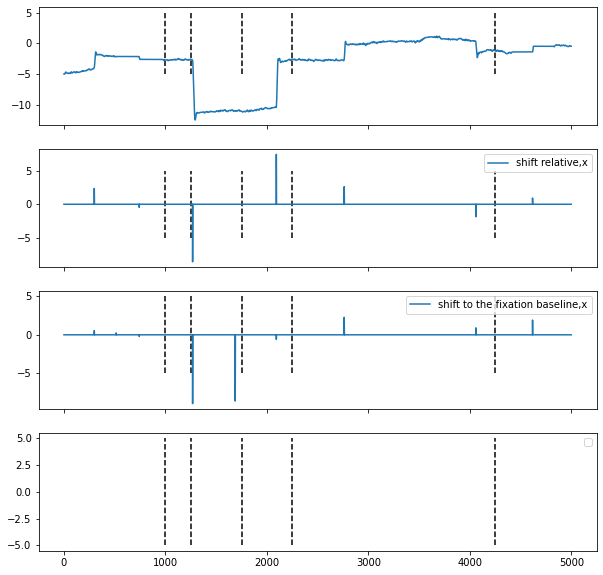

In [59]:
fig,ax = plt.subplots(nrows=4,sharex=True)
ax[0].plot(range(5000),smoothSaccX.loc[trialName])
#ax[0].plot(range(5000),smoothSaccY.loc[trialName],color = 'r')
ax[1].plot(range(5000),shiftDf_relX.loc[trialName],label = 'shift relative,x')
#ax[1].plot(range(5000),shiftDf_relY.loc[trialName],label = 'shift relative,y')

ax[2].plot(range(5000),shiftDf_absX.loc[trialName],label = 'shift to the fixation baseline,x')
#ax[2].plot(range(5000),shiftDf_absY.loc[trialName],label = 'shift to the fixation baseline,y')

#ax[3].plot(range(5000),shiftDf_ctrX.loc[trialName],label = 'shift to the screen center,x')
#ax[3].plot(range(5000),shiftDf_ctrY.loc[trialName],label = 'shift to the screen center,y')

[ax[i].vlines(np.array(eventIndex[1:-3]),-5,5,linestyles = 'dashed',colors = 'black') for i in range(4)]
ax[1].legend()
ax[2].legend()
ax[3].legend()

# shift magnitude

In [ ]:
shiftDf = shiftDf_relX.merge(psyFull[['cue_posi','cue_blk_validity','identifier']],left_index = True,right_on = 'identifier', how = 'inner')
shiftDf.set_index('identifier',inplace=True)

## get towardness count

In [251]:
#tag the towardness using cue condition
leftToward_relX= pd.DataFrame(np.where(shiftDf[shiftDf.cue_posi == 'left'].iloc[:,:5000].values < 0, 1, 0),index = shiftDf[shiftDf.cue_posi == 'left'].index)
leftToward_relX['blk_validity'] = shiftDf[shiftDf.cue_posi == 'left']['cue_blk_validity']
rightToward_relX= pd.DataFrame(np.where(shiftDf[shiftDf.cue_posi == 'right'].iloc[:,:5000].values > 0, 1, 0),index = shiftDf[shiftDf.cue_posi == 'right'].index)
rightToward_relX['blk_validity'] = shiftDf[shiftDf.cue_posi == 'right']['cue_blk_validity']

leftToward_relX['cue_posi'] = 'left'
rightToward_relX['cue_posi'] = 'right'

In [252]:
#tag the awayness using cue condition
leftAway_relX= pd.DataFrame(np.where(shiftDf[shiftDf.cue_posi == 'left'].iloc[:,:2500].values > 0, 1, 0),index = shiftDf[shiftDf.cue_posi == 'left'].index)
leftAway_relX['blk_validity'] = shiftDf[shiftDf.cue_posi == 'left']['cue_blk_validity']
rightAway_relX= pd.DataFrame(np.where(shiftDf[shiftDf.cue_posi == 'right'].iloc[:,:2500].values < 0, 1, 0),index = shiftDf[shiftDf.cue_posi == 'right'].index)
rightAway_relX['blk_validity'] = shiftDf[shiftDf.cue_posi == 'right']['cue_blk_validity']

leftAway_relX['cue_posi'] = 'left'
rightAway_relX['cue_posi'] = 'right'

In [253]:
toward = pd.concat([leftToward_relX,rightToward_relX])
toward.sort_index(inplace=True)

away = pd.concat([leftAway_relX,rightAway_relX])
away.sort_index(inplace=True)

<font color = red> save

In [ ]:
toward.to_csv('gsRelX_toward.csv')
away.to_csv('gsRelX_away.csv')

## get frequency

In [67]:
#get frequency
winsize = 100
towardFreq = toward.iloc[:,:-2].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize
awayFreq = away.iloc[:,:-2].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize

In [68]:
#add back tag
towardFreq = towardFreq.merge(psyFull.reset_index()[['cue_posi','cue_blk_validity','identifier']],right_on = 'identifier',left_index = True, how = 'inner').reset_index(drop = True)
awayFreq = awayFreq.merge(psyFull.reset_index()[['cue_posi','cue_blk_validity','identifier']],right_on = 'identifier',left_index = True, how = 'inner').reset_index(drop = True)

In [69]:
towardFreq.shape

(11242, 5003)

## parse to only select the retrocue/delay

In [77]:
towardShifts.shape

(11242, 5002)

In [71]:
#parse for retrocue
towardRetroX = pd.DataFrame(data=[towardFreq.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
towardRetroX = pd.concat([towardRetroX,towardFreq.iloc[:,-3:]],axis = 1)

In [74]:
awayRetroX = pd.DataFrame(data=[awayFreq.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
awayRetroX = pd.concat([awayRetroX,awayFreq.iloc[:,-3:]],axis = 1)

In [75]:
towardRetroX.to_csv('freqRelX_towardRetro.csv')
awayRetroX.to_csv('freqRelX_awayRetro.csv')

In [76]:
towardRetroX.shape

(11242, 3003)

In [920]:
#parse for retrocue - relX
msRetroX = pd.DataFrame(data=[shiftDf.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
msRetroX['identifier'] = shiftDf.index.values
msRetroX = pd.concat([msRetroX,shiftDf.iloc[:,-2:].reset_index(drop=True),],axis = 1)#


In [89]:
#parse for retrocue - relX, for toward and away
msRetroX_toward = pd.DataFrame(data=[towardShifts.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
msRetroX_toward['identifier'] = towardFreq.identifier
msRetroX_toward = pd.concat([msRetroX_toward,towardFreq[['cue_posi','cue_blk_validity']].reset_index(drop=True),],axis = 1)#


In [91]:
#parse for retrocue - relX, for toward and away
msRetroX_away = pd.DataFrame(data=[awayShifts.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
msRetroX_away['identifier'] = awayFreq.identifier
msRetroX_away = pd.concat([msRetroX_away,awayFreq[['cue_posi','cue_blk_validity']].reset_index(drop=True),],axis = 1)#


In [92]:
msRetroX_toward.to_csv('gsRelX_towardRetro.csv')
msRetroX_away.to_csv('gsRelX_awayRetro.csv')

In [93]:
#parse for retrocue - absX
msRetroX_abs = pd.DataFrame(data=[shiftDf_absX.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
msRetroX_abs['identifier'] = shiftDf_absX.identifier.values
msRetroX_abs = pd.concat([msRetroX_abs,shiftDf_absX.iloc[:,-2:].reset_index(drop=True),],axis = 1)#


In [85]:
#parse for retrocue - ctrX
msRetroX_ctr = pd.DataFrame(data=[shiftDf_ctrX.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
msRetroX_ctr['identifier'] = shiftDf_ctrX.index.values
msRetroX_ctr = msRetroX_ctr.merge(psyFull.reset_index()[['identifier','cue_posi','cue_blk_validity']],on='identifier',how = 'left')

In [95]:
msRetroX_abs.to_csv('gsAbsX_retro.csv')

In [930]:
msRetroX.to_csv('gsRelX_retro.csv')

In [87]:
msRetroX_ctr.to_csv('gsCtrX_retro.csv')

In [ ]:
"""#get the toward and away magnitude for the gazeshifts
gazeShifts = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeShift2d/rej7Subj/gsRelX.csv')
gazeShifts.set_index('TRIALID',inplace=True)
#merge get labels
shiftDf = gazeShifts.merge(psyFull[['cue_posi','cue_blk_validity']],left_index = True,right_index = True, how = 'inner')

#tag the towardness using cue condition
leftToward_relX= pd.DataFrame(np.where(shiftDf[shiftDf.cue_posi == 'left'].iloc[:,:5000].values < 0, shiftDf[shiftDf.cue_posi == 'left'].iloc[:,:5000].values , 0),index = shiftDf[shiftDf.cue_posi == 'left'].index)
leftToward_relX['blk_validity'] = shiftDf[shiftDf.cue_posi == 'left']['cue_blk_validity']
rightToward_relX= pd.DataFrame(np.where(shiftDf[shiftDf.cue_posi == 'right'].iloc[:,:5000].values > 0, shiftDf[shiftDf.cue_posi == 'right'].iloc[:,:5000].values, 0),index = shiftDf[shiftDf.cue_posi == 'right'].index)
rightToward_relX['blk_validity'] = shiftDf[shiftDf.cue_posi == 'right']['cue_blk_validity']

leftToward_relX['cue_posi'] = 'left'
rightToward_relX['cue_posi'] = 'right'

#tag the awayness using cue condition
leftAway_relX= pd.DataFrame(np.where(shiftDf[shiftDf.cue_posi == 'left'].iloc[:,:5000].values > 0, shiftDf[shiftDf.cue_posi == 'left'].iloc[:,:5000].values, 0),index = shiftDf[shiftDf.cue_posi == 'left'].index)
leftAway_relX['blk_validity'] = shiftDf[shiftDf.cue_posi == 'left']['cue_blk_validity']
rightAway_relX= pd.DataFrame(np.where(shiftDf[shiftDf.cue_posi == 'right'].iloc[:,:5000].values < 0, shiftDf[shiftDf.cue_posi == 'right'].iloc[:,:5000].values, 0),index = shiftDf[shiftDf.cue_posi == 'right'].index)
rightAway_relX['blk_validity'] = shiftDf[shiftDf.cue_posi == 'right']['cue_blk_validity']

leftAway_relX['cue_posi'] = 'left'
rightAway_relX['cue_posi'] = 'right'

toward = pd.concat([leftToward_relX,rightToward_relX])
toward.sort_index(inplace=True)

away = pd.concat([leftAway_relX,rightAway_relX])
away.sort_index(inplace=True)

towardRetroX = pd.DataFrame(data=[toward.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
towardRetroX['identifier'] = toward.index.values
towardRetroX = pd.concat([towardRetroX,toward.iloc[:,-2:].reset_index(drop=True)],axis = 1)

awayRetroX = pd.DataFrame(data=[away.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
awayRetroX['identifier'] = away.index.values
awayRetroX = pd.concat([awayRetroX,away.iloc[:,-2:].reset_index(drop=True)],axis = 1)

towardRetroX.to_csv('gsRelX_towardRetro.csv')
awayRetroX.to_csv('gsRelX_awayRetro.csv')
"""

In [229]:
towardRetroX.to_csv('gsRelX_towardRetro.csv')
awayRetroX.to_csv('gsRelX_awayRetro.csv')

# readin (temp)

In [18]:
pathUnparsed = 'Z:/LiteBrite_YueyingDong/temp/unparsed/'
#read behav
psyFull = pd.read_csv('Z:/LiteBrite_YueyingDong/temp/cleanBehav.csv')#.iloc[:,1:]
psyFull.set_index('identifier',inplace=True)
psyFull['cue_posi'] = psyFull.cue_posi.replace({0:'right',1:'left'})

In [19]:
psyFull.shape

(14310, 205)

In [20]:
#temp - this is processed data, unepoched, unrejcted
#saccClean = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/saccPercXY/saccPercXY_Masked_NNinterpolated.csv')

In [47]:
#read the cleaned and interpolated
#gaze, only for retrocue epoch, including the 7 subjects, 
#but rejecting the trials with more than 12.5% gaze data missing
#this is the gaze, I don't know why i named it sacc
#this contains both the x and y 

saccRetro = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/cleanSacc_parsedByEventMarker/rej7Subj/cleanSacc_retrocue2Probe.csv').iloc[:,1:]
saccRetroBL = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/cleanSacc_parsedByEventMarker/rej7Subj/cleanSacc_retrocueBL500ms.csv').iloc[:,1:]


In [48]:
#this is the gaze, I don't know why i named it sacc
saccRetroX = saccRetro[saccRetro.axis == 'x'].reset_index(drop = True)
saccRetroY = saccRetro[saccRetro.axis == 'y'].reset_index(drop = True)


saccRetroBLX = saccRetroBL[saccRetroBL.axis == 'x'].reset_index(drop = True)

In [30]:
#this is the gaze end point of each identified eye movement
shiftDf_CtrX = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeShift2d/rej7Subj/gsCtrX_retro.csv').iloc[:,1:]

In [20]:
#this is the full frequency of entire trial, only for the horizontal channel
#this is calculated using the shiftDf_relX file 
towardFreq =  pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeShift2d/rej7Subj/freqRelX_towardRetro.csv').iloc[:,1:]
awayFreq = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeshift2d/rej7Subj/freqRelX_awayRetro.csv').iloc[:,1:]


In [230]:
#this is the gaze shift magnitude for the toward and away, only for retrocue and delay epochs
towardShiftsRetro = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeShift2d/rej7Subj/gsRelX_towardRetro.csv').iloc[:,1:]
awayShiftsRetro = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeShift2d/rej7Subj/gsRelX_awayRetro.csv').iloc[:,1:]

# gaze plots

## permutation

In [49]:
#permutation with tCluster
perms = 5000
dataN = 2500
tCluster = np.zeros(shape = (3,perms))

condList = ["high","medium","low"]

eg = saccRetroX[np.sum(saccRetroX.iloc[:,:dataN].isnull(),axis = 1) ==0].reset_index(drop = True)
eg = eg.set_index(['blk_validity']).iloc[:,np.r_[np.arange(0,dataN),-1]]



In [20]:
""" #dont ran this, this will start the permutation, readin the result instead
for i in range (perms):
    print(i)
    eg['randLabel'] = np.random.permutation(eg.cue_posi.values) #
    for n,cond in enumerate(condList):
        tArr,pArr = stats.ttest_ind(eg[eg.randLabel == 'right'].loc[cond,].iloc[:,:dataN],
                               eg[eg.randLabel == 'left'].loc[cond,].iloc[:,:dataN],equal_var = False,
                               axis=0, nan_policy='propagate',alternative = 'greater')
        
        #find the clusters that exceed p value threshold  
        consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,
                        findSame = False)
        
        #find the cluster with the largest length,then find its corresponding t values, sum it up
        #note: if no cluster is found, this will return 0
        tCluster[n][i] =  np.round(tArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)
""" 

" #dont ran this, this will start the permutation, readin the result instead\nfor i in range (perms):\n    print(i)\n    eg['randLabel'] = np.random.permutation(eg.cue_posi.values) #\n    for n,cond in enumerate(condList):\n        tArr,pArr = stats.ttest_ind(eg[eg.randLabel == 'right'].loc[cond,].iloc[:,:dataN],\n                               eg[eg.randLabel == 'left'].loc[cond,].iloc[:,:dataN],equal_var = False,\n                               axis=0, nan_policy='propagate',alternative = 'greater')\n        \n        #find the clusters that exceed p value threshold  \n        consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,\n                        findSame = False)\n        \n        #find the cluster with the largest length,then find its corresponding t values, sum it up\n        #note: if no cluster is found, this will return 0\n        tCluster[n][i] =  np.round(tArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)\n"

In [21]:
#pd.DataFrame(tCluster).T.rename(columns = {0:'high',1 :'med',2: 'low'}).to_csv('gazePathPermutation5000_7rej.csv')

In [50]:
tCluster = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/permutationResults_7rej/gazeClusterPermutation5000_7rej.csv').iloc[:,1:].values.T

In [51]:
egH = eg.loc["high"]
trueHT,trueHP = stats.ttest_ind(egH[egH.cue_posi == 'right'].iloc[:,:dataN],
                                egH[egH.cue_posi == 'left'].iloc[:,:dataN],equal_var = False,
                axis=0, nan_policy='propagate',alternative = 'greater')

consGroups = np.array(consecutive(np.where(trueHP <  0.05)[0], stepsize=1,
                findSame = False))
trueTHArr = np.array([trueHT[i].sum() > np.quantile(tCluster[0],0.95) for i in consecutive(np.where(trueHP < 0.05)[0], stepsize=1,
                findSame = False)]) 

hInd = consGroups[trueTHArr]
trueTH =  [np.array(trueHT)[i].sum() for i in hInd]

In [52]:
egM = eg.loc["medium"]
trueMT,trueMP = stats.ttest_ind(egM[egM.cue_posi == 'right'].iloc[:,:dataN],
                                egM[egM.cue_posi == 'left'].iloc[:,:dataN],equal_var = False,
                axis=0, nan_policy='propagate',alternative = 'greater')

consGroups = np.array(consecutive(np.where(trueMP <  0.05)[0], stepsize=1,
                findSame = False))
trueTMArr = np.array([trueMT[i].sum() > np.quantile(tCluster[1],0.95) for i in consecutive(np.where(trueMP < 0.05)[0], stepsize=1,
                findSame = False)]) 
mInd = consGroups[trueTMArr]
trueTM =  [np.array(trueMT)[i].sum() for i in mInd]

In [53]:
egL = eg.loc["low"]
trueLT,trueLP = stats.ttest_ind(egL[egL.cue_posi == 'right'].iloc[:,:dataN],
                                egL[egL.cue_posi == 'left'].iloc[:,:dataN],equal_var = False,
                axis=0, nan_policy='propagate',alternative = 'greater')


consGroups = np.array(consecutive(np.where(trueLP <  0.05)[0], stepsize=1,
                findSame = False))
trueTLArr = np.array([trueLT[i].sum() > np.quantile(tCluster[2],0.95) for i in consecutive(np.where(trueLP < 0.05)[0], stepsize=5,
                findSame = False)]) 
lInd = consGroups[trueTLArr]
trueTL =  [np.array(trueLT)[i].sum() for i in lInd]

[None, None, None]

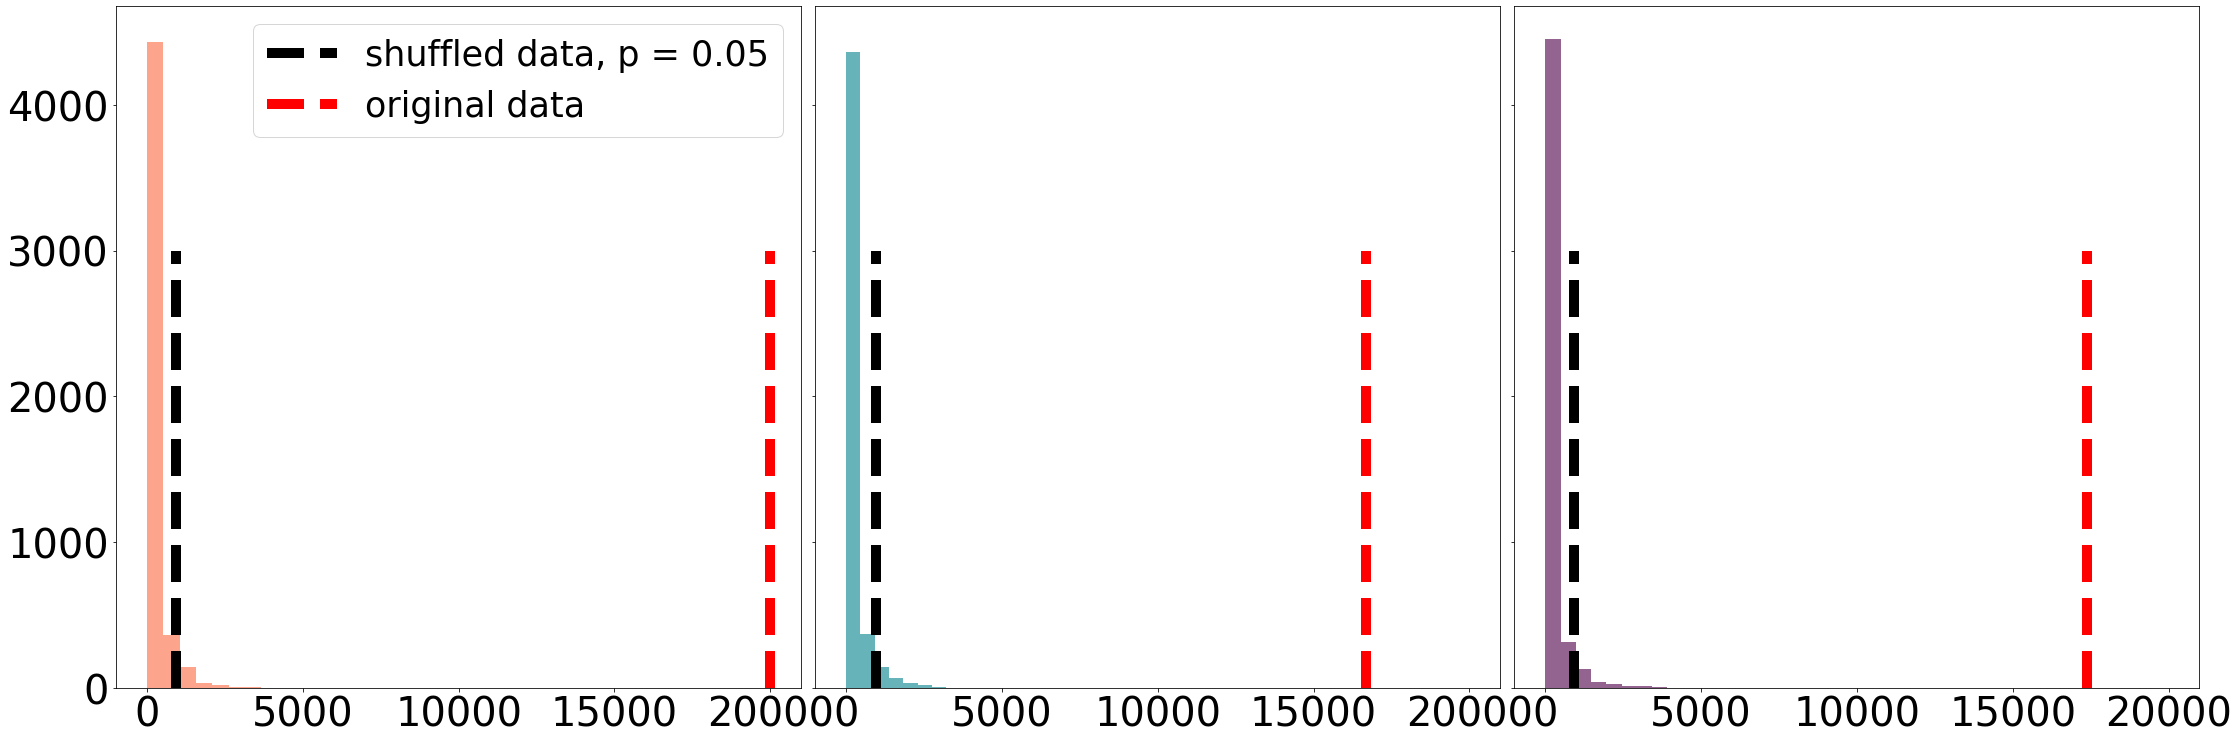

In [54]:
fs(30,10)
t1 = str(np.round(np.quantile(tCluster[0],0.95),2))
t2 = str(np.round(np.quantile(tCluster[1],0.05),2))
t3 = str(np.round(np.quantile(tCluster[2],0.05),2))


fig,ax = plt.subplots(ncols = 3,sharex=True,sharey=True)

ax[0].hist(tCluster[0],color = cList[0])
ax[0].vlines(x=np.quantile(tCluster[0],0.95),color = 'black',linewidth = 10,
           ymin = 0, ymax = 3000,linestyles='dashed',label = 'shuffled data, p = 0.05')
ax[0].vlines(x=trueTH,color = 'red',linewidth = 10,
           ymin = 0, ymax = 3000,linestyles='dashed',label = 'original data')
#ax[0].set_title('High')
ax[0].legend(prop = {'size' : 35})
#ax[0].text(x = np.quantile(tCluster[0],0.95), y = 3000, s = t1)

ax[1].hist(tCluster[1],color = cList[4])
ax[1].vlines(x=np.quantile(tCluster[1],0.95),color = 'black',linewidth = 10,
           ymin = 0, ymax = 3000,linestyles='dashed')
ax[1].vlines(x=trueTM,color = 'red',linewidth = 10,
           ymin = 0, ymax = 3000,linestyles='dashed')
#ax[1].set_title('medium')
#ax[1].text(x = np.quantile(tCluster[1],0.05)-3000, y = 3000, s = t2)


ax[2].hist(tCluster[2],color = cList[2])
ax[2].vlines(x=np.quantile(tCluster[2],0.95),color = 'black',linewidth = 10,
           ymin = 0, ymax = 3000,linestyles='dashed')
ax[2].vlines(x=trueTL,color = 'red',linewidth = 10,
           ymin = 0, ymax = 3000,linestyles='dashed')
#ax[2].set_title('low')
#ax[2].text(x = np.quantile(tCluster[2],0.05)-3000, y = 3000, s = t3)

fig.tight_layout()
[ax[i].tick_params( labelsize=40) for i in range(3)]

#plt.suptitle('permutated significant cluster, tsum; 0.05 threshold')

In [55]:
trueTH,trueTM,trueTL

([19980.768505095417], [16680.702467902447], [17382.827574971918])

In [56]:
sum(tCluster[0]>trueTH)/5000,sum(tCluster[1]>trueTM)/5000,sum(tCluster[2]>trueTL)/5000,

(0.0, 0.0, 0.0)

# gaze plots

In [57]:
saccPos = saccRetroX.copy()
#use the last 100 ms as the baseline mean
saccBL = saccRetroBLX.iloc[:,400:500].mean(axis = 1)
saccPos.iloc[:,:-5] = saccPos.iloc[:,:-5].sub(saccBL,axis = 0)

#prepare for figure
saccPosPercMean = saccPos.groupby(['blk_validity','cue_posi']).mean().iloc[:,:2500]
saccPosPercStderr = saccPos.groupby(['blk_validity','cue_posi']).sem().iloc[:,:2500]

norm_upper = saccPosPercMean + saccPosPercStderr
norm_lower = saccPosPercMean - saccPosPercStderr

In [58]:
print(hInd[0][0],hInd[0][-1])
print(mInd[0][0],mInd[0][-1])
print(lInd[0][0],lInd[0][-1])

397 2499
283 2499
289 2499


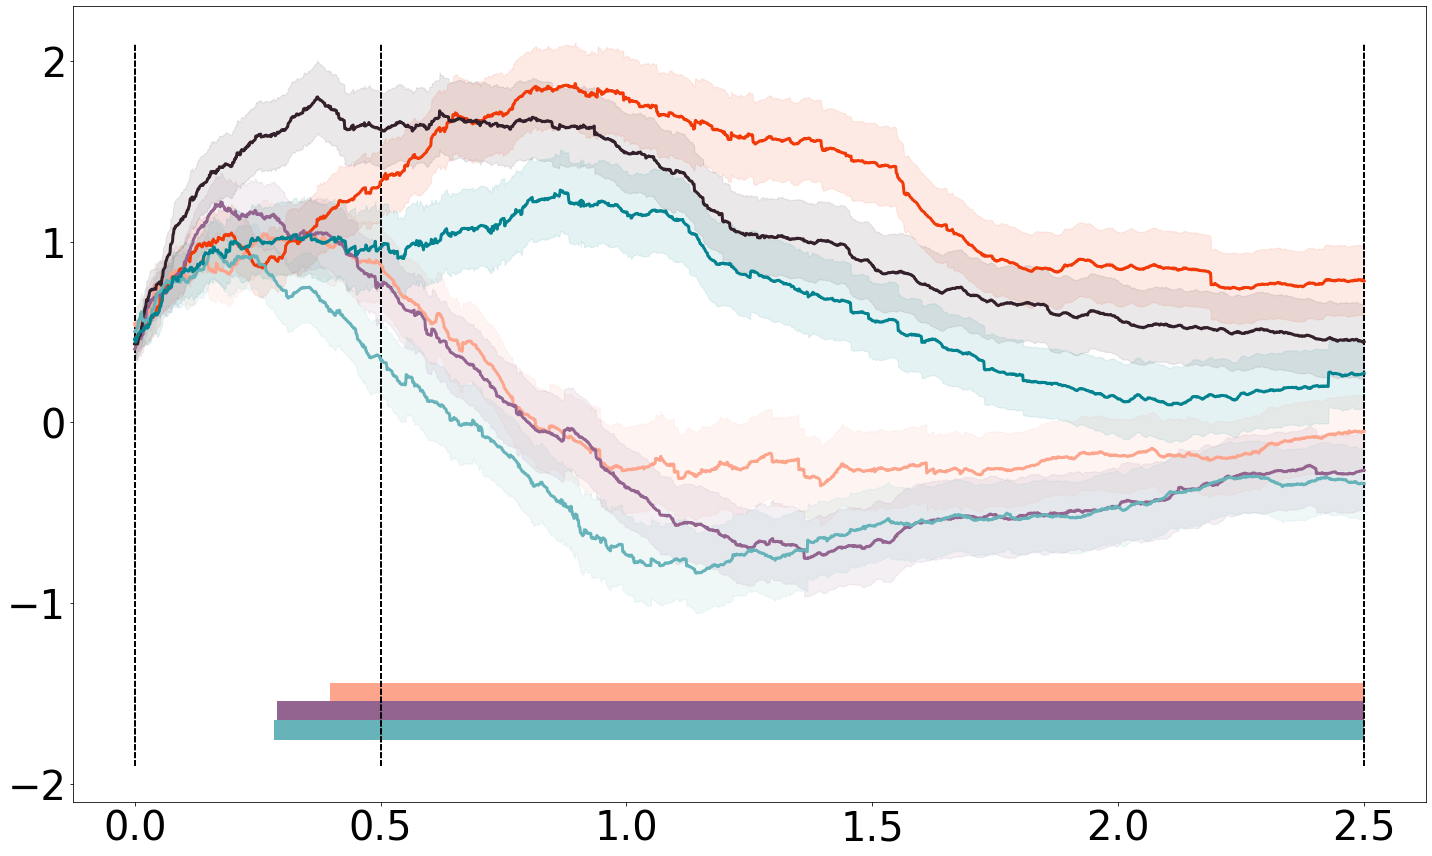

In [59]:
fs(20,12)
fig,ax = plt.subplots(nrows=1,sharex=True,sharey=True)

x = np.linspace(0,2.5,norm_upper.shape[1])
condN = norm_upper.shape[0]
fs(12,6)

[plt.hlines(-1.5,k[0]/1000,k[-1]/1000,colors = cList[0],linewidth = 20) for k in hInd]
[plt.hlines(-1.6,k[0]/1000,k[-1]/1000,colors = cList[2],linewidth = 20) for k in lInd]
[plt.hlines(-1.7,k[0]/1000,k[-1]/1000,colors = cList[4],linewidth = 20) for k in mInd]

[plt.fill_between(x,norm_upper.iloc[i,0:norm_upper.shape[1]],norm_lower.iloc[i,0:norm_upper.shape[1]],
                    color = cList[i],alpha = 0.1, )  for i in range(condN)]
[plt.plot(x,saccPosPercMean.iloc[i,0:norm_upper.shape[1]],color = cList[i],linewidth = 3,) for i in range(condN) ]

[plt.vlines(x[[0,500,2499]],-1.9,
                    norm_upper.max().max(),linestyles = 'dashed',colors= 'black') for i in range(condN) ]


ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.tick_params(labelsize = 40)
fig.tight_layout()
plt.show()

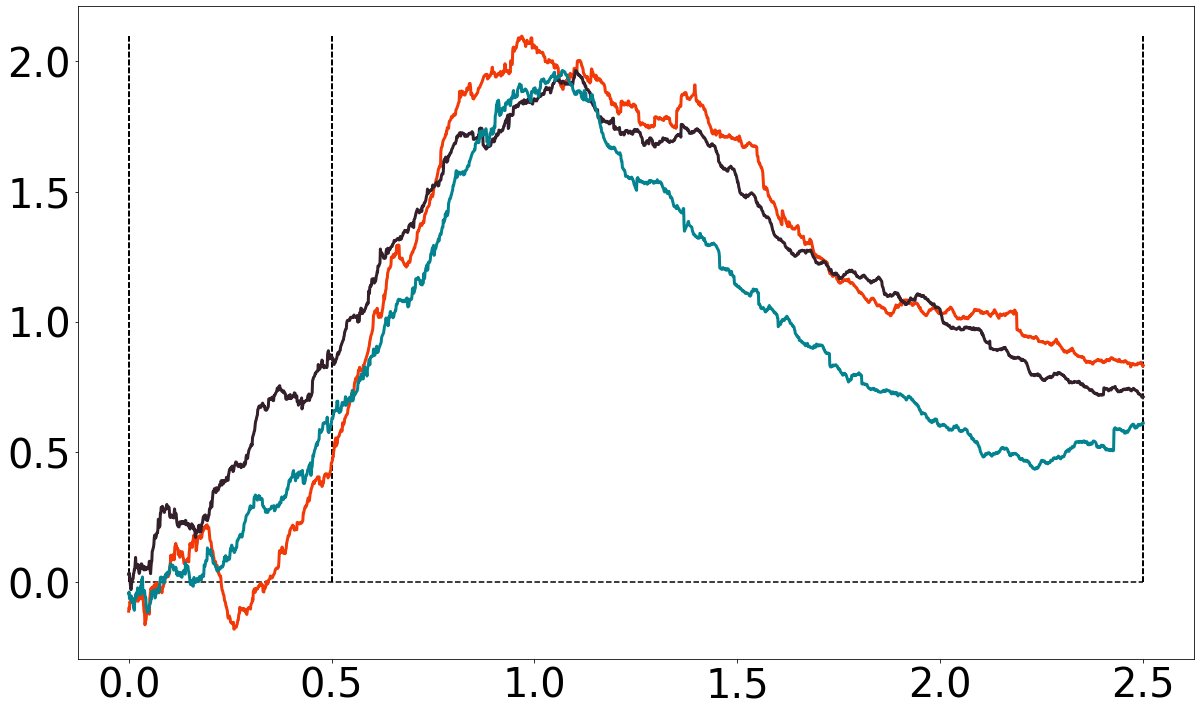

In [109]:
x = np.linspace(0,2.5,2500)
condN = 3
diffMean= saccPosPercMean.iloc[1::2].values - saccPosPercMean.iloc[::2].values

fs(20,12)

[plt.plot(x,diffMean[i],color = ['#f23908','#33202a','#03838f'][i],linewidth = 3, 
            label = ['high','low','medium'][i]) for i in range(3) ]

[plt.vlines(x[[0,500,2499]],0,
                    diffMean.max().max(),linestyles = 'dashed',colors= 'black') for i in range(condN) ]


ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.tick_params(labelsize = 40) 

#plt.title('horizontal gaze position difference, cue right - left',size = 15)
#plt.legend(bbox_to_anchor = (1.2,1),prop={'size': 18})
plt.hlines(0,0,2.5,linestyles = 'dashed',colors= 'black')
plt.show()

In [110]:
saccBinned = saccPos.iloc[:,250:750].groupby(np.arange(500)//250,axis=1).mean()
saccBinned = pd.concat([saccBinned, saccPos.iloc[:,-4:]],axis = 1)

In [111]:
saccBinnedSubj = saccBinned.groupby(['subj','blk_validity','cue_posi']).mean().reset_index()
temp = saccBinnedSubj.iloc[1::2,-2:].values-saccBinnedSubj.iloc[::2,-2:].values
saccBinnedSubj = pd.concat([saccBinnedSubj.iloc[1::2,:-2].reset_index(drop = True),pd.DataFrame(temp)],axis = 1)
saccBinnedSubj = saccBinnedSubj.melt(id_vars=['blk_validity','cue_posi','subj'],value_vars=[0,1],var_name='epoch',value_name='xPos')


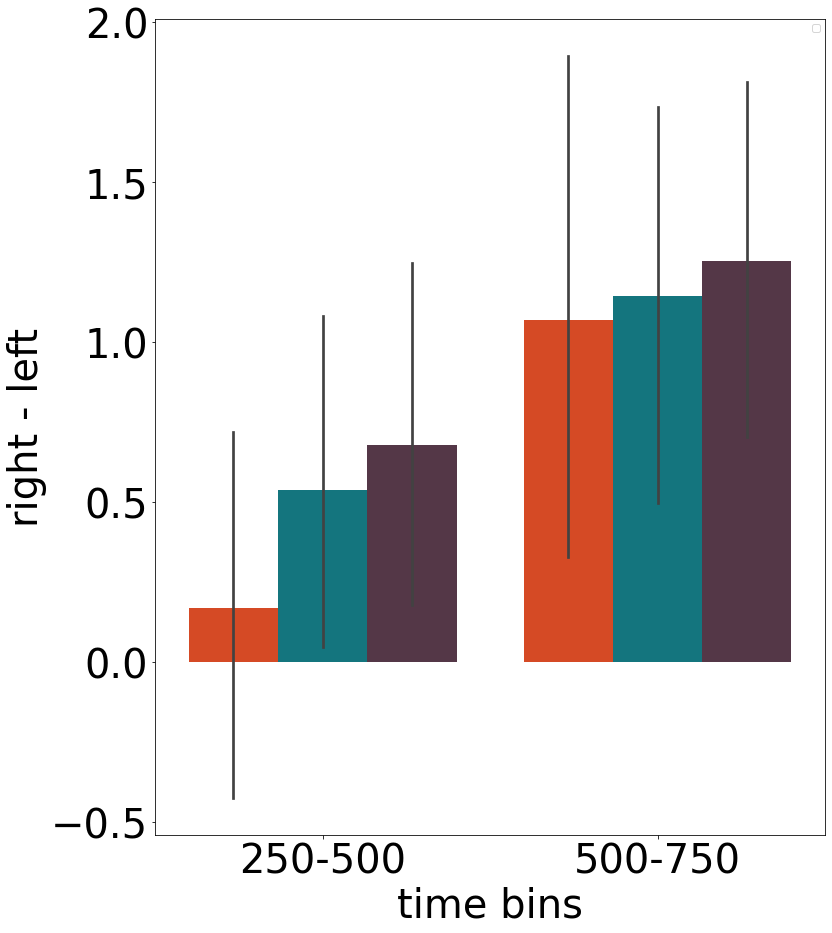

In [112]:
fs(12,15)

fig,ax = plt.subplots(nrows=1,sharex=True,sharey=True)
sns.barplot(hue = 'blk_validity',x = 'epoch',y = 'xPos',
            hue_order= ['high','medium','low'],
            palette=cDict.values(),
            data = saccBinnedSubj,)

plt.tick_params(labelsize = 40,)
plt.xticks(ticks = [0,1],labels = ['250-500','500-750'])
plt.xlabel(xlabel = 'time bins',fontsize = 40)
plt.ylabel(ylabel = 'right - left',fontsize = 40)
plt.legend("")

ax.axes.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

In [113]:
pg.rm_anova(data = saccBinnedSubj.reset_index(drop = True),dv = 'xPos',
            within = ['blk_validity','epoch',],subject= 'subj',effsize = 'np2').round(2)

Source     SS  ddof1  ddof2     MS      F  p-unc  p-GG-corr  \
0          blk_validity   5.21      2     82   2.60   0.40   0.67       0.64   
1                 epoch  30.32      1     41  30.32  15.95   0.00       0.00   
2  blk_validity * epoch   1.35      2     82   0.67   0.81   0.45       0.41   

    np2   eps  
0  0.01  0.86  
1  0.28  1.00  
2  0.02  0.72

Text(0.5, 1.0, 'mean')

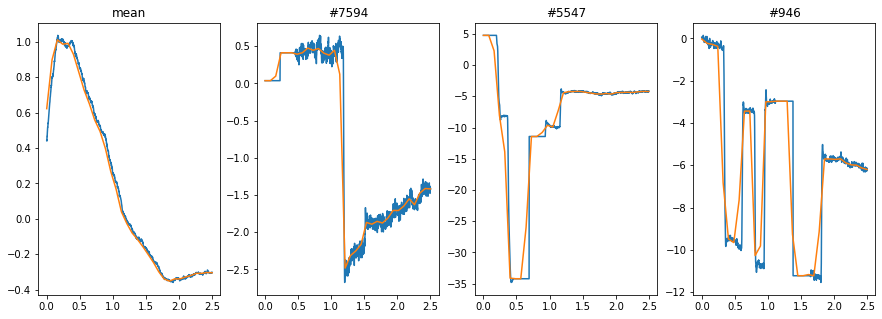

In [91]:
fs(15,5)
binLen = 80
saccPos12 = saccPos.iloc[:,:2500].groupby(np.arange(2500)//binLen,axis=1).mean()

fig,ax = plt.subplots(ncols = 4)
ax[0].plot(np.linspace(0,2.5,2500),saccPos.iloc[:,:2500].mean())
ax[0].plot(np.linspace(0,2.5,32),saccPos12.iloc[:,:32].mean())

for i in range(1,4):
    randTrl = np.random.randint(13740)
    ax[i].plot(np.linspace(0,2.5,2500),saccPos.iloc[randTrl,:2500])
    ax[i].plot(np.linspace(0,2.5,32),saccPos12.iloc[randTrl,:32])
    ax[i].set_title('#'+str(randTrl))

ax[0].set_title('mean')

# heatmap

In [60]:
#test the between block difference
binLen = 80

In [61]:
#create 10 bins, each of 250ms, 
saccSubjMean12Bins = saccPos.iloc[:,:2500].groupby(np.arange(2500)//binLen,axis = 1).mean()
saccSubjMean12Bins = pd.concat([saccSubjMean12Bins,saccPos.iloc[:,-2:]],axis = 1)

#saccSubjMean12Bins = saccSubjMean12Bins.melt(id_vars = [,'blk_validity','cue_posi'],value_vars=np.arange(12),var_name='binIndex',value_name='xPos')

In [62]:
saccSubjMean12Bins.columns = saccSubjMean12Bins.columns.astype(str)

In [63]:
fp = [pg.anova(data = saccSubjMean12Bins, dv = i,
              between = ['cue_posi','blk_validity'])[['F',
                                                           'p-unc']].iloc[2,:] for i in saccSubjMean12Bins.columns[:32].values]

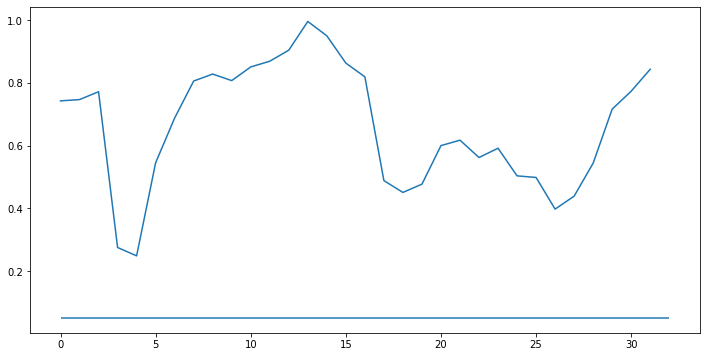

In [64]:
plt.plot(np.array(fp)[:,1])
plt.hlines(0.05,0,32)

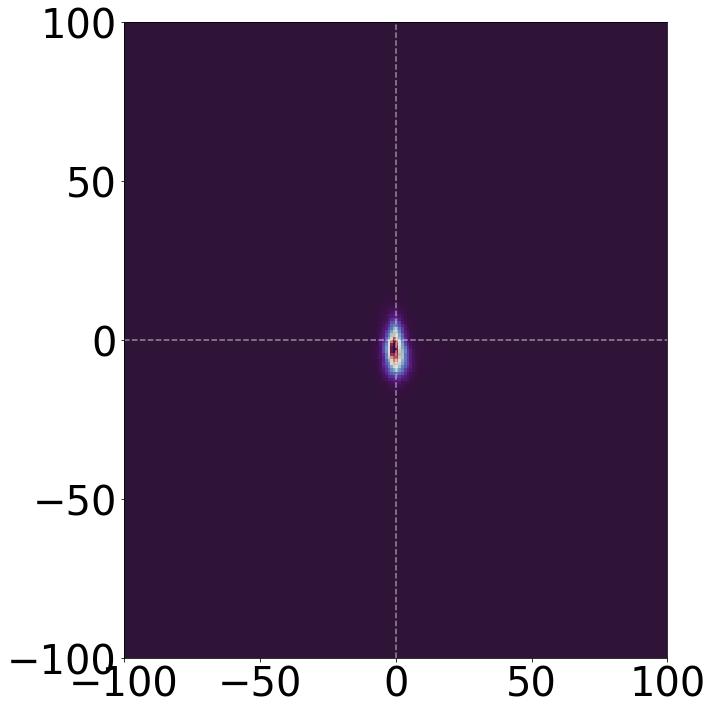

In [65]:
fs(10,10)

allX = saccRetroX.iloc[:,0:2500].to_numpy().flatten()
allY = saccRetroY.iloc[:,0:2500].to_numpy().flatten()

fig,ax = plt.subplots(1)
leftVal = plt.hist2d(allX, allY, bins = (200,200),
                         range = [[-100, 100], [-100, 100]],density=True,cmap = 'twilight_shifted')[0]
plt.vlines(0,-100,100,linestyles='dashed',colors = 'white',alpha = 0.5)
plt.hlines(0,-100,100,linestyles='dashed',colors = 'white',alpha = 0.5)

#plt.title('gaze position during retrocue & delay',size = 15)

ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))

plt.tick_params(labelsize = 40)
fig.tight_layout()
plt.show()


In [66]:
def temptemp(dfX,dfY,startInd,endInd,cond,binN,colorMap = 'twilight_shifted'):
    leftX = dfX.iloc[:,startInd:endInd][(dfX.cue_posi == 'left')
                                          & (dfX['blk_validity'].isin(cond))].to_numpy().flatten()
    
    leftY = dfY.iloc[:,startInd:endInd][(dfY.cue_posi == 'left')
                                          & (dfY['blk_validity'].isin(cond))].to_numpy().flatten()

    rightX = dfX.iloc[:,startInd:endInd][(dfX.cue_posi == 'right')
                                           & (dfX['blk_validity'].isin(cond))].to_numpy().flatten()
    rightY = dfY.iloc[:,startInd:endInd][(dfY.cue_posi == 'right')
                                           & (dfY['blk_validity'] .isin(cond))].to_numpy().flatten()
    plt.tick_params(labelsize=40)
    leftVal = plt.hist2d(leftX, leftY, bins = (binN,binN),
                         range = [[-100, 100], [-100, 100]],density=True,cmap = colorMap)[0]
    rightVal = plt.hist2d(rightX, rightY, bins = (binN,binN),
                          range = [[-100, 100], [-100, 100]],density=True, cmap = colorMap)[0]

    
    leftMinusRight = leftVal - rightVal
    rightMinusLeft = rightVal - leftVal

    return leftVal,rightVal,leftMinusRight,rightMinusLeft



Text(0.5, 1.0, 'left-right')

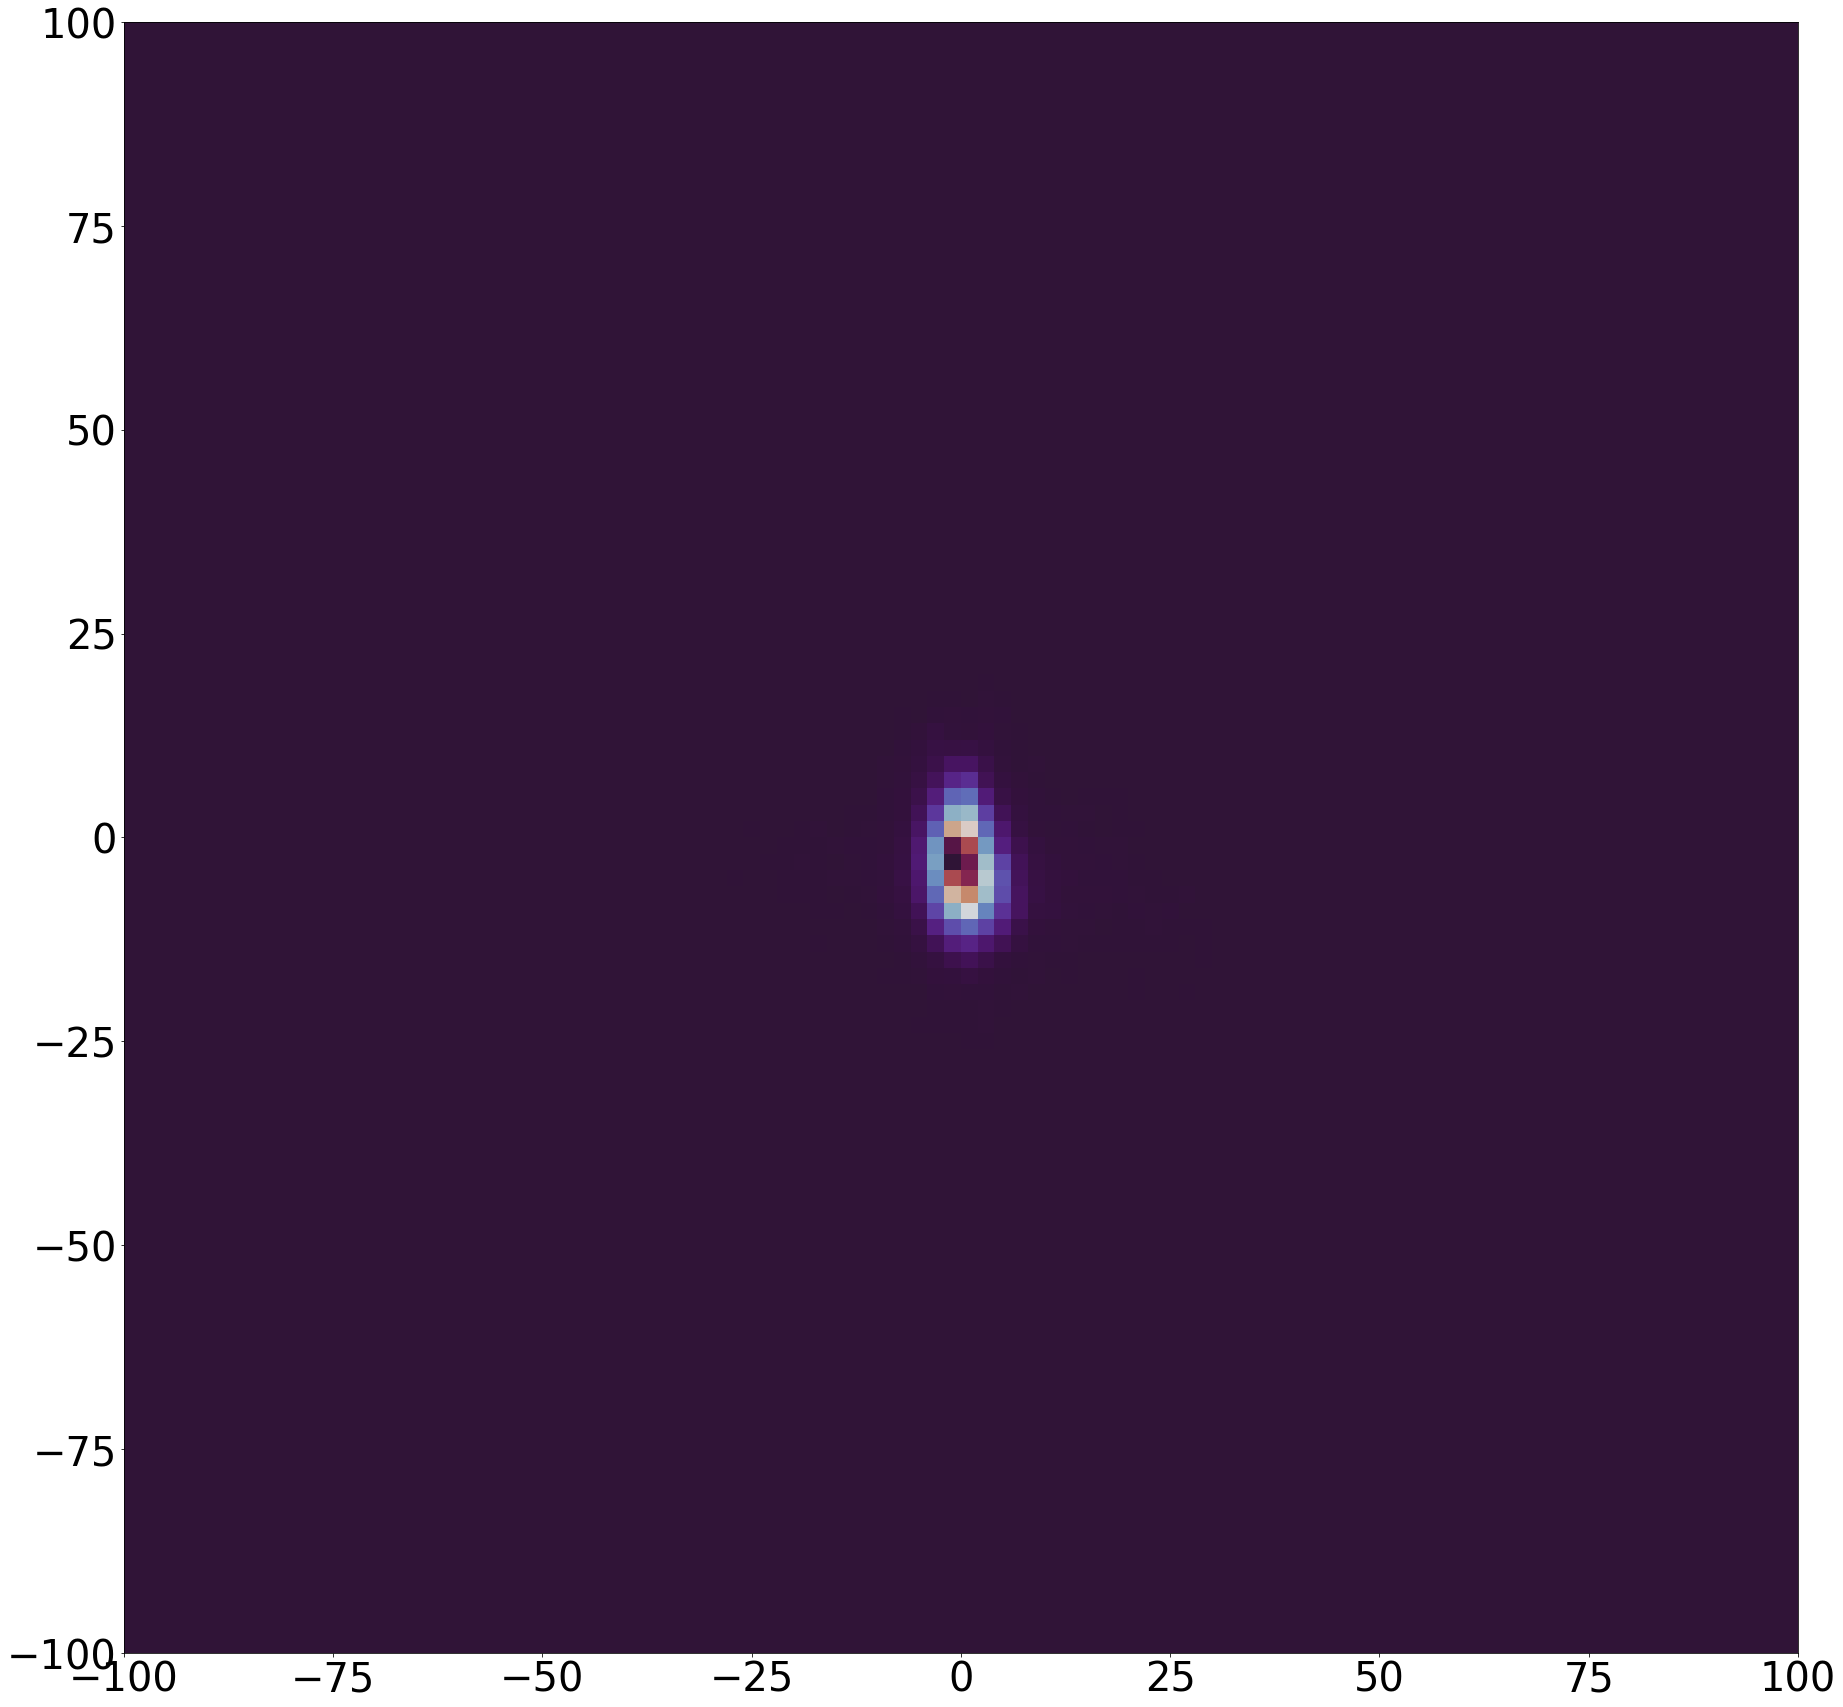

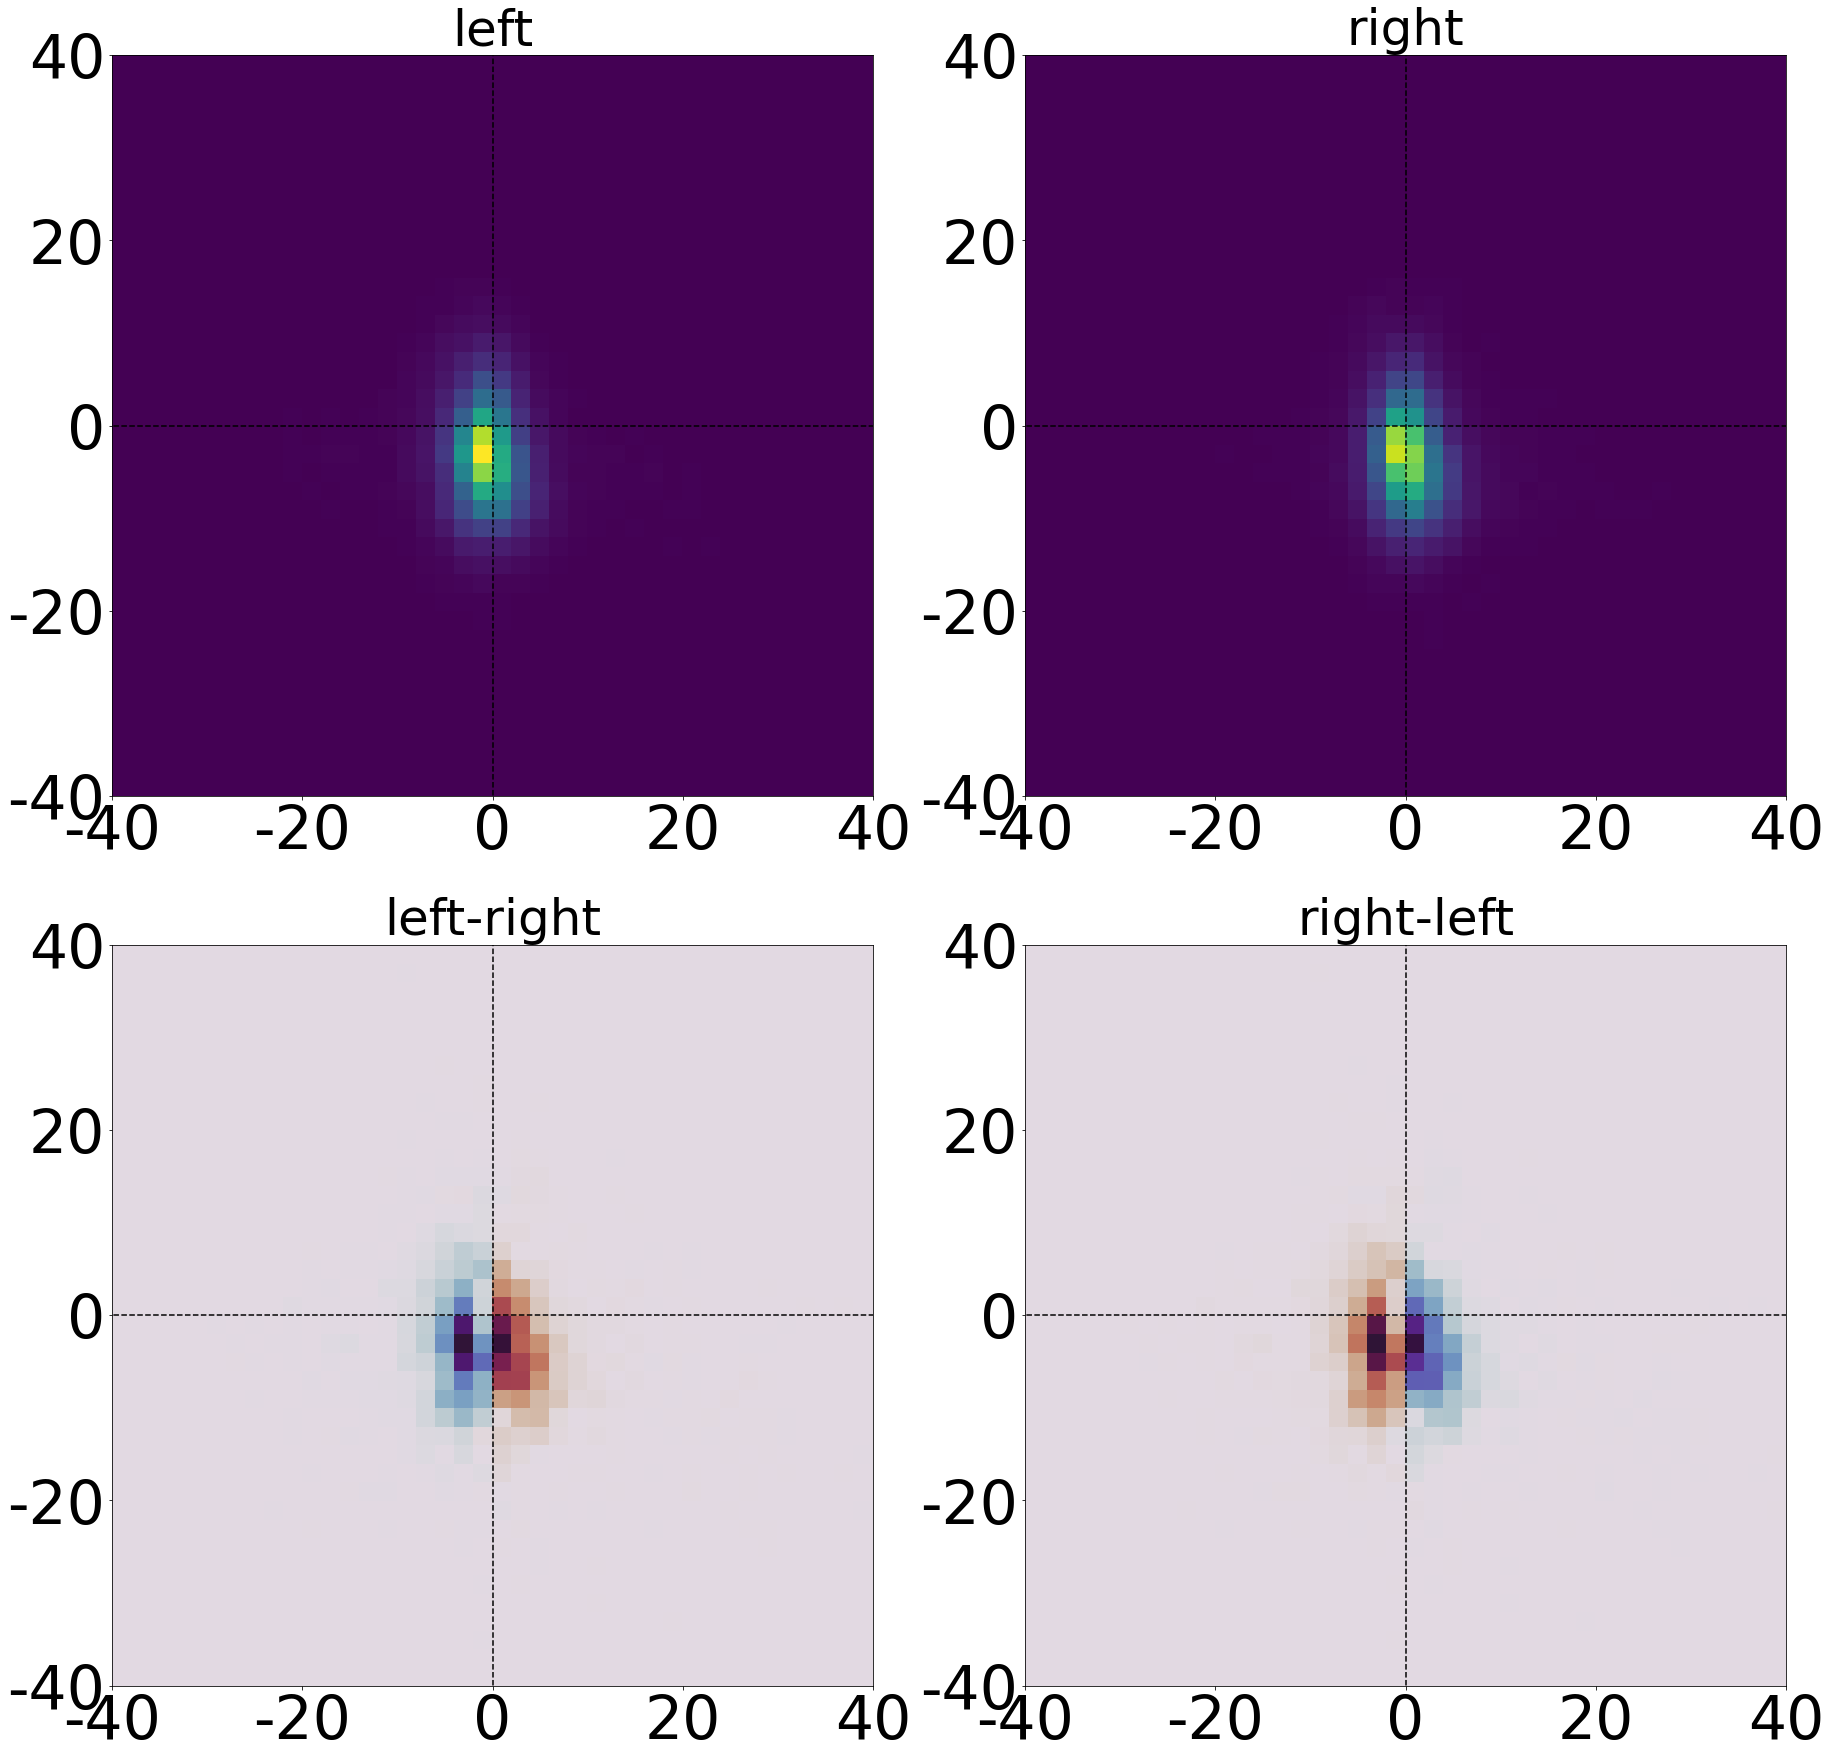

In [79]:
fs(30,30)
leftVal,rightVal,leftMinusRightAll,rightMinusLeftAll = temptemp(saccRetroX,saccRetroY,startInd = 0,endInd = 2500,cond = ["high","medium","low"],binN = 100)

fig,ax = plt.subplots(nrows = 2,ncols = 2)
cax  = ax[0][0].pcolor(leftVal.T,vmin = 0,vmax = 0.014)
ax[0][1].pcolor(rightVal.T,vmin = 0,vmax = 0.014)
cae = ax[1][1].pcolor(leftMinusRightAll.T,cmap = 'twilight_shifted',vmin = -0.003,vmax = 0.003)
ax[1][0].pcolor(rightMinusLeftAll.T,cmap = 'twilight_shifted',vmin = -0.003,vmax = 0.003)

[ax[i][j].vlines(50,0,100,linestyles='dashed',colors = 'black',) for i in range(2) for j in range(2)]
[ax[i][j].hlines(50,0,100,linestyles='dashed',colors = 'black', ) for i in range(2) for j in range(2)]

[ax[i][j].set_xlim(30,70) for i in range(2) for j in range(2)]
[ax[i][j].set_ylim(30,70) for i in range(2) for j in range(2)]

[ax[i][j].tick_params( labelsize=60) for i in range(2) for j in range(2)]


[ax[i][j].set_xticklabels(((ax[0][0].get_xticks()-50)*2).astype(int)) for i in range(2) for j in range(2)]
[ax[i][j].set_yticklabels(((ax[0][0].get_xticks()-50)*2).astype(int)) for i in range(2) for j in range(2)]



ax[0][0].set_title('left',size = 50)
ax[0][1].set_title('right',size = 50)
ax[1][1].set_title('right-left',size = 50)
ax[1][0].set_title('left-right',size = 50)



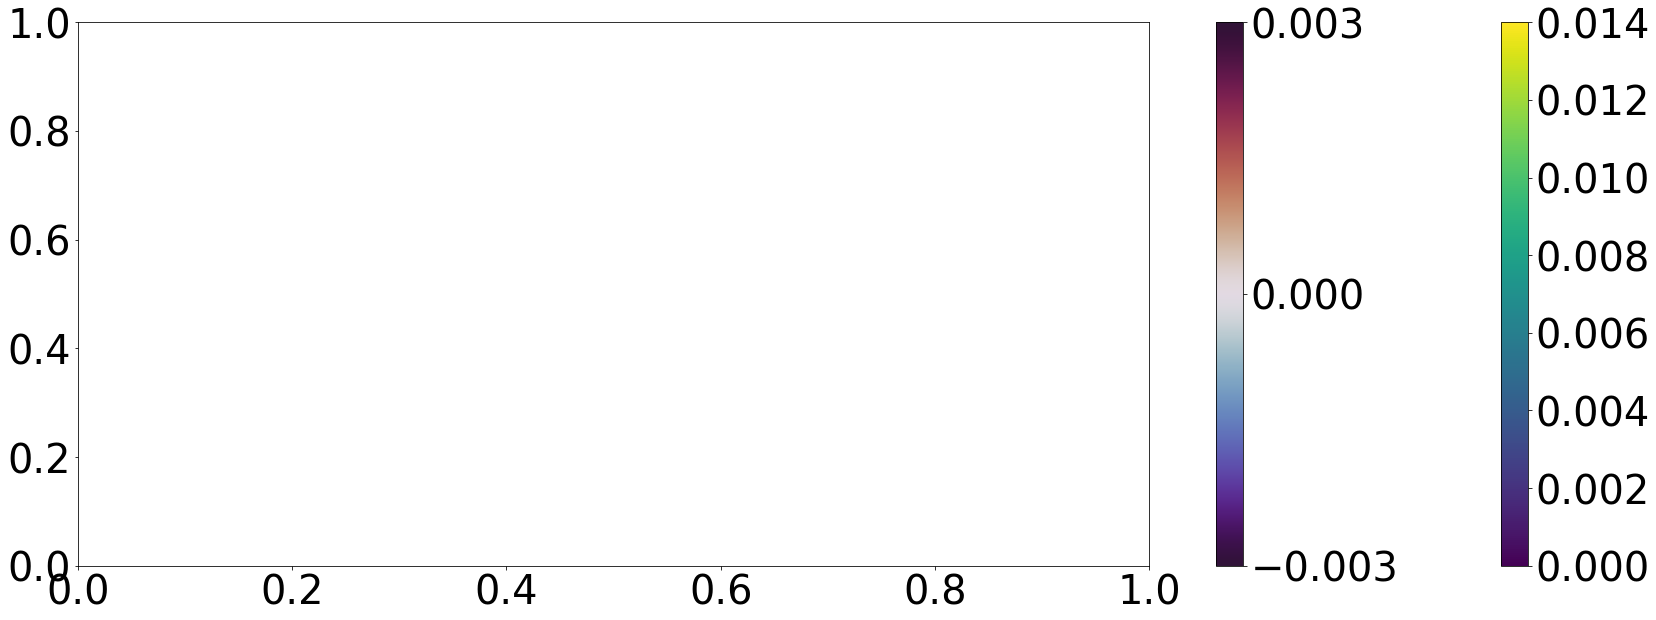

In [85]:
#plot the cbar to save seperately
fs(30,10)
plt.tick_params(labelsize=40)
a = plt.colorbar(cax)
b = plt.colorbar(cae)
for t in a.ax.get_yticklabels():
     t.set_fontsize(40)
for t in b.ax.get_yticklabels():
     t.set_fontsize(40)

b.ax.yaxis.set_major_locator(ticker.MultipleLocator(0.003))


# frequency plot

In [22]:
eventStart = 1


## permutation

In [21]:
towardRetroX = towardFreq
awayRetroX = awayFreq
dataN = 2500

In [22]:
tempToward = towardRetroX.iloc[:,np.r_[0:dataN,-3,-2,-1]]
tempAway = awayRetroX.iloc[:,np.r_[0:dataN,-3,-2,-1]]

tempToward['towardness'] = 'toward'
tempAway['towardness'] = 'away'
towardness = pd.concat([tempToward,tempAway],axis = 0)

In [23]:
#permutation with tmax
perms = 5000
dataN = 2500
tCluster = np.zeros(shape = (3,perms))

eg = towardness.reset_index(drop = True)
eg = eg[np.sum(eg.iloc[:,:dataN].isnull(),axis = 1) ==0].reset_index(drop = True)
eg = eg.set_index(['cue_blk_validity'])

In [24]:
"""#don't ran this, this will start the permutation
for i in range (0,perms):
    print(i)
    eg['randLabel'] = np.random.permutation(eg.towardness.values) #
    for n,cond in enumerate(["['high']","['medium']","['low']"]):#
        tArr,pArr = stats.ttest_ind(eg[eg.randLabel == 'toward'].loc[cond,].iloc[:,:dataN],
                               eg[eg.randLabel == 'away'].loc[cond,].iloc[:,:dataN],equal_var = False,
                               axis=0, nan_policy='propagate',alternative = 'greater')
        
        #find the clusters that exceed p value threshold  
        consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,
                        findSame = False)
        
        #find the cluster with the largest length,then find its corresponding t values, sum it up
        #note: if no cluster is found, this will return 0
        tCluster[n][i] =  tArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum()
"""

'#don\'t ran this, this will start the permutation\nfor i in range (0,perms):\n    print(i)\n    eg[\'randLabel\'] = np.random.permutation(eg.towardness.values) #\n    for n,cond in enumerate(["[\'high\']","[\'medium\']","[\'low\']"]):#\n        tArr,pArr = stats.ttest_ind(eg[eg.randLabel == \'toward\'].loc[cond,].iloc[:,:dataN],\n                               eg[eg.randLabel == \'away\'].loc[cond,].iloc[:,:dataN],equal_var = False,\n                               axis=0, nan_policy=\'propagate\',alternative = \'greater\')\n        \n        #find the clusters that exceed p value threshold  \n        consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,\n                        findSame = False)\n        \n        #find the cluster with the largest length,then find its corresponding t values, sum it up\n        #note: if no cluster is found, this will return 0\n        tCluster[n][i] =  tArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum()\n'

In [25]:
#pd.DataFrame(tCluster).T.rename(columns = {0:'high',1 :'med',2: 'low'}).to_csv('saccClusterPermutation5000.csv')

In [26]:
tCluster = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/saccClusterPermutation5000.csv').iloc[:,1:].values.T

In [27]:
egH = eg.loc["['high']"]
trueHT,trueHP = stats.ttest_ind(egH[egH.towardness == 'toward'].iloc[:,:dataN],
                                egH[egH.towardness == 'away'].iloc[:,:dataN],equal_var = False,
                axis=0, nan_policy='propagate',alternative = 'greater')

consGroups = np.array(consecutive(np.where(trueHP <  0.05)[0], stepsize=1,
                findSame = False))

trueTHArr = np.array([trueHT[i].sum() > np.quantile(tCluster[0],0.95) for i in consecutive(np.where(trueHP < 0.05)[0], stepsize=1,
                findSame = False)]) 

hInd = consGroups[trueTHArr]
trueTH =  [np.array(trueHT)[i].sum() for i in hInd]

In [28]:
egM = eg.loc["['medium']"]
trueMT,trueMP = stats.ttest_ind(egM[egM.towardness == 'toward'].iloc[:,:dataN],
                                egM[egM.towardness == 'away'].iloc[:,:dataN],equal_var = False,
                axis=0, nan_policy='propagate',alternative = 'greater')

consGroups = np.array(consecutive(np.where(trueMP <  0.05)[0], stepsize=1,
                findSame = False))
trueTMArr = np.array([trueMT[i].sum() > np.quantile(tCluster[1],0.95) for i in consecutive(np.where(trueMP < 0.05)[0], stepsize=1,
                findSame = False)]) 
mInd = consGroups[trueTMArr]
trueTM =  [np.array(trueMT)[i].sum() for i in mInd]

In [29]:
egL = eg.loc["['low']"]
trueLT,trueLP = stats.ttest_ind(egL[egL.towardness == 'toward'].iloc[:,:dataN],
                                egL[egL.towardness == 'away'].iloc[:,:dataN],equal_var = False,
                axis=0, nan_policy='propagate',alternative = 'greater')

#I slightly increased the stepsize here b/c a lot of the identified clusters are very close in time < 5 time points apart
#so that they can be considered the same
consGroups = np.array(consecutive(np.where(trueLP <  0.05)[0], stepsize=5,
                findSame = False))

trueTLArr = np.array([trueLT[i].sum() > np.quantile(tCluster[2],0.95) for i in consecutive(np.where(trueLP < 0.05)[0], stepsize=5,
                findSame = False)]) 
lInd = consGroups[trueTLArr]
trueTL =  [np.array(trueLT)[i].sum() for i in lInd]

In [30]:
trueTH,trueTM,trueTL

([3114.4748810573606],
 [2516.9127136145153],
 [1153.4101060531684, 1103.2931452110192])

[None, None, None]

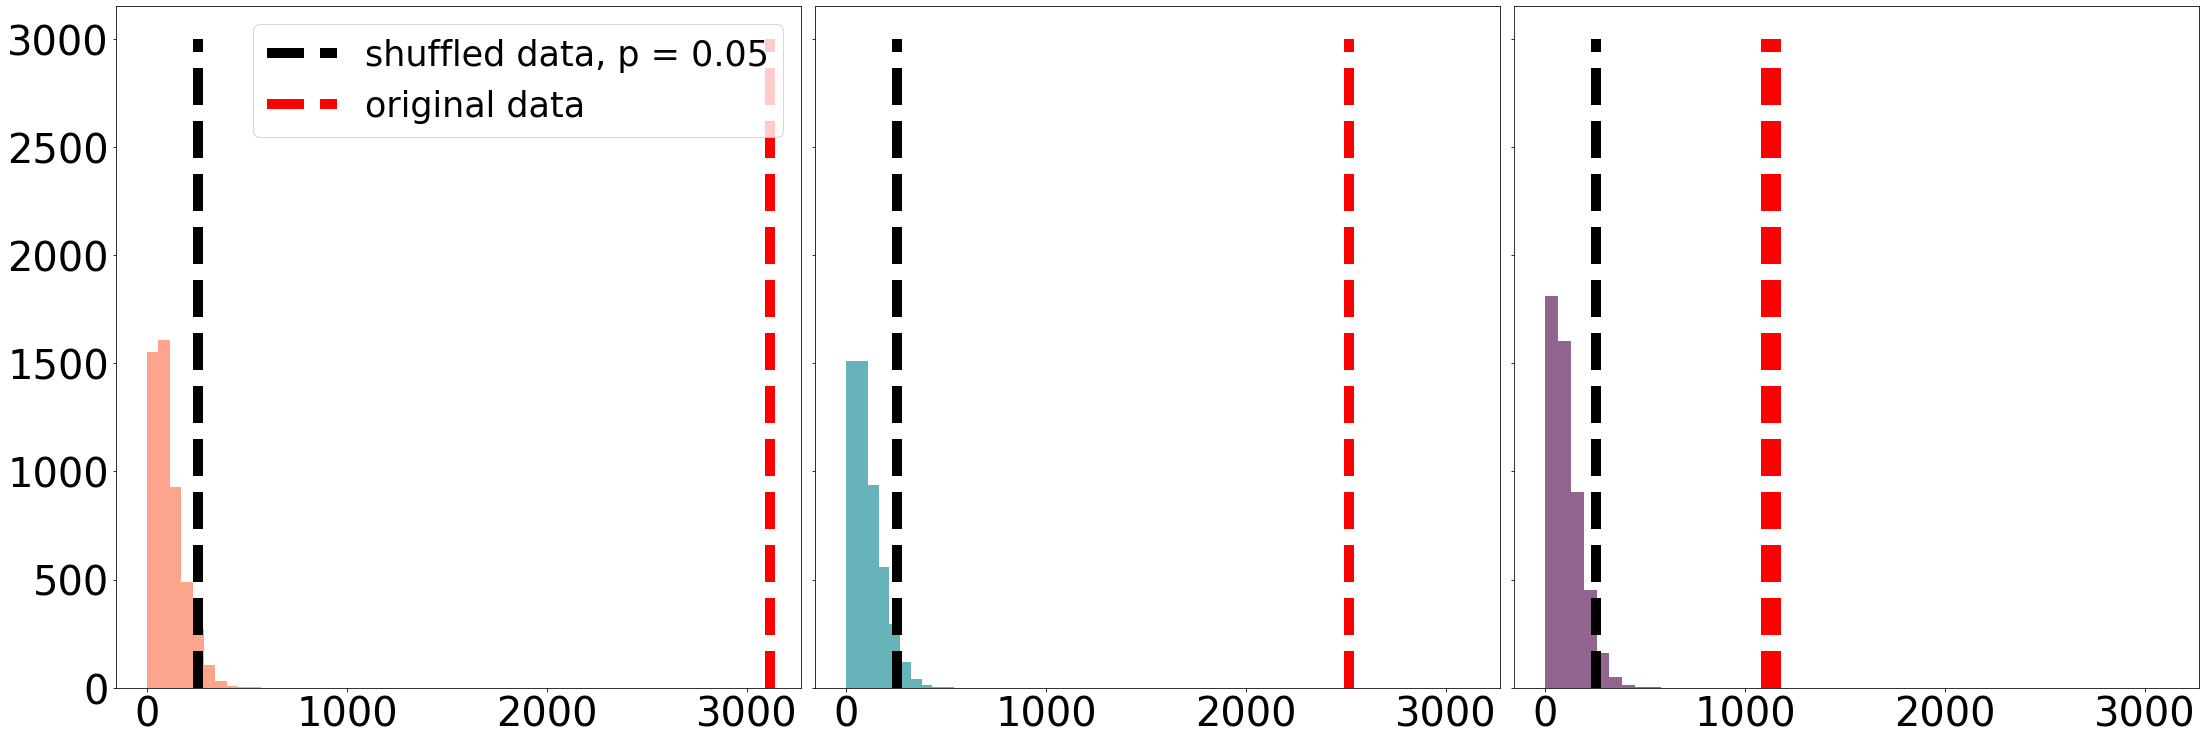

In [31]:
fs(30,10)
t1 = str(np.round(np.quantile(tCluster[0],0.95),2))
t2 = str(np.round(np.quantile(tCluster[1],0.05),2))
t3 = str(np.round(np.quantile(tCluster[2],0.05),2))


fig,ax = plt.subplots(ncols = 3,sharex=True,sharey=True)

ax[0].hist(tCluster[0],color = cList[0])
ax[0].vlines(x=np.quantile(tCluster[0],0.95),color = 'black',linewidth = 10,
           ymin = 0, ymax = 3000,linestyles='dashed',label = 'shuffled data, p = 0.05')
ax[0].vlines(x=trueTH,color = 'red',linewidth = 10,
           ymin = 0, ymax = 3000,linestyles='dashed',label = 'original data')
#ax[0].set_title('High')
ax[0].legend(prop = {'size' : 35})
#ax[0].text(x = np.quantile(tCluster[0],0.95), y = 3000, s = t1)

ax[1].hist(tCluster[1],color = cList[4])
ax[1].vlines(x=np.quantile(tCluster[1],0.95),color = 'black',linewidth = 10,
           ymin = 0, ymax = 3000,linestyles='dashed')
ax[1].vlines(x=trueTM,color = 'red',linewidth = 10,
           ymin = 0, ymax = 3000,linestyles='dashed')
#ax[1].set_title('medium')
#ax[1].text(x = np.quantile(tCluster[1],0.05)-3000, y = 3000, s = t2)


ax[2].hist(tCluster[2],color = cList[2])
ax[2].vlines(x=np.quantile(tCluster[2],0.95),color = 'black',linewidth = 10,
           ymin = 0, ymax = 3000,linestyles='dashed')
ax[2].vlines(x=trueTL,color = 'red',linewidth = 10,
           ymin = 0, ymax = 3000,linestyles='dashed')
#ax[2].set_title('low')
#ax[2].text(x = np.quantile(tCluster[2],0.05)-3000, y = 3000, s = t3)

fig.tight_layout()
[ax[i].tick_params( labelsize=40) for i in range(3)]

#plt.suptitle('permutated significant cluster, tsum; 0.05 threshold')

In [32]:
towardMean = towardRetroX.groupby(['cue_blk_validity']).mean().iloc[:,:2500]
towardSderr = towardRetroX.groupby(['cue_blk_validity',]).sem().iloc[:,:2500]

towardUpp = towardMean + towardSderr
towardLow = towardMean - towardSderr


awayMean = awayRetroX.groupby(['cue_blk_validity']).mean().iloc[:,:2500]
awaySderr = awayRetroX.groupby(['cue_blk_validity',]).sem().iloc[:,:2500]

awayUpp = awayMean + awaySderr
awayLow = awayMean - awaySderr

In [33]:
pH = 1- sum(tCluster[0] < trueTH[0])/5000
pM = [1 - sum(tCluster[1] < i)/5000 for i in trueTM]
pL = [1 - sum(tCluster[2] < i)/5000 for i in trueTL]

In [34]:
hInd[0][[0,-1]],[mInd[i][[0,-1]] for i in range(len(mInd))],[lInd[i][[0,-1]] for i in range(len(lInd))]


(array([335, 990], dtype=int64),
 [array([424, 998], dtype=int64)],
 [array([288, 689], dtype=int64), array([719, 983], dtype=int64)])

In [35]:
pH,pM,pL

(0.0, [0.0], [0.0, 0.0])

## mean

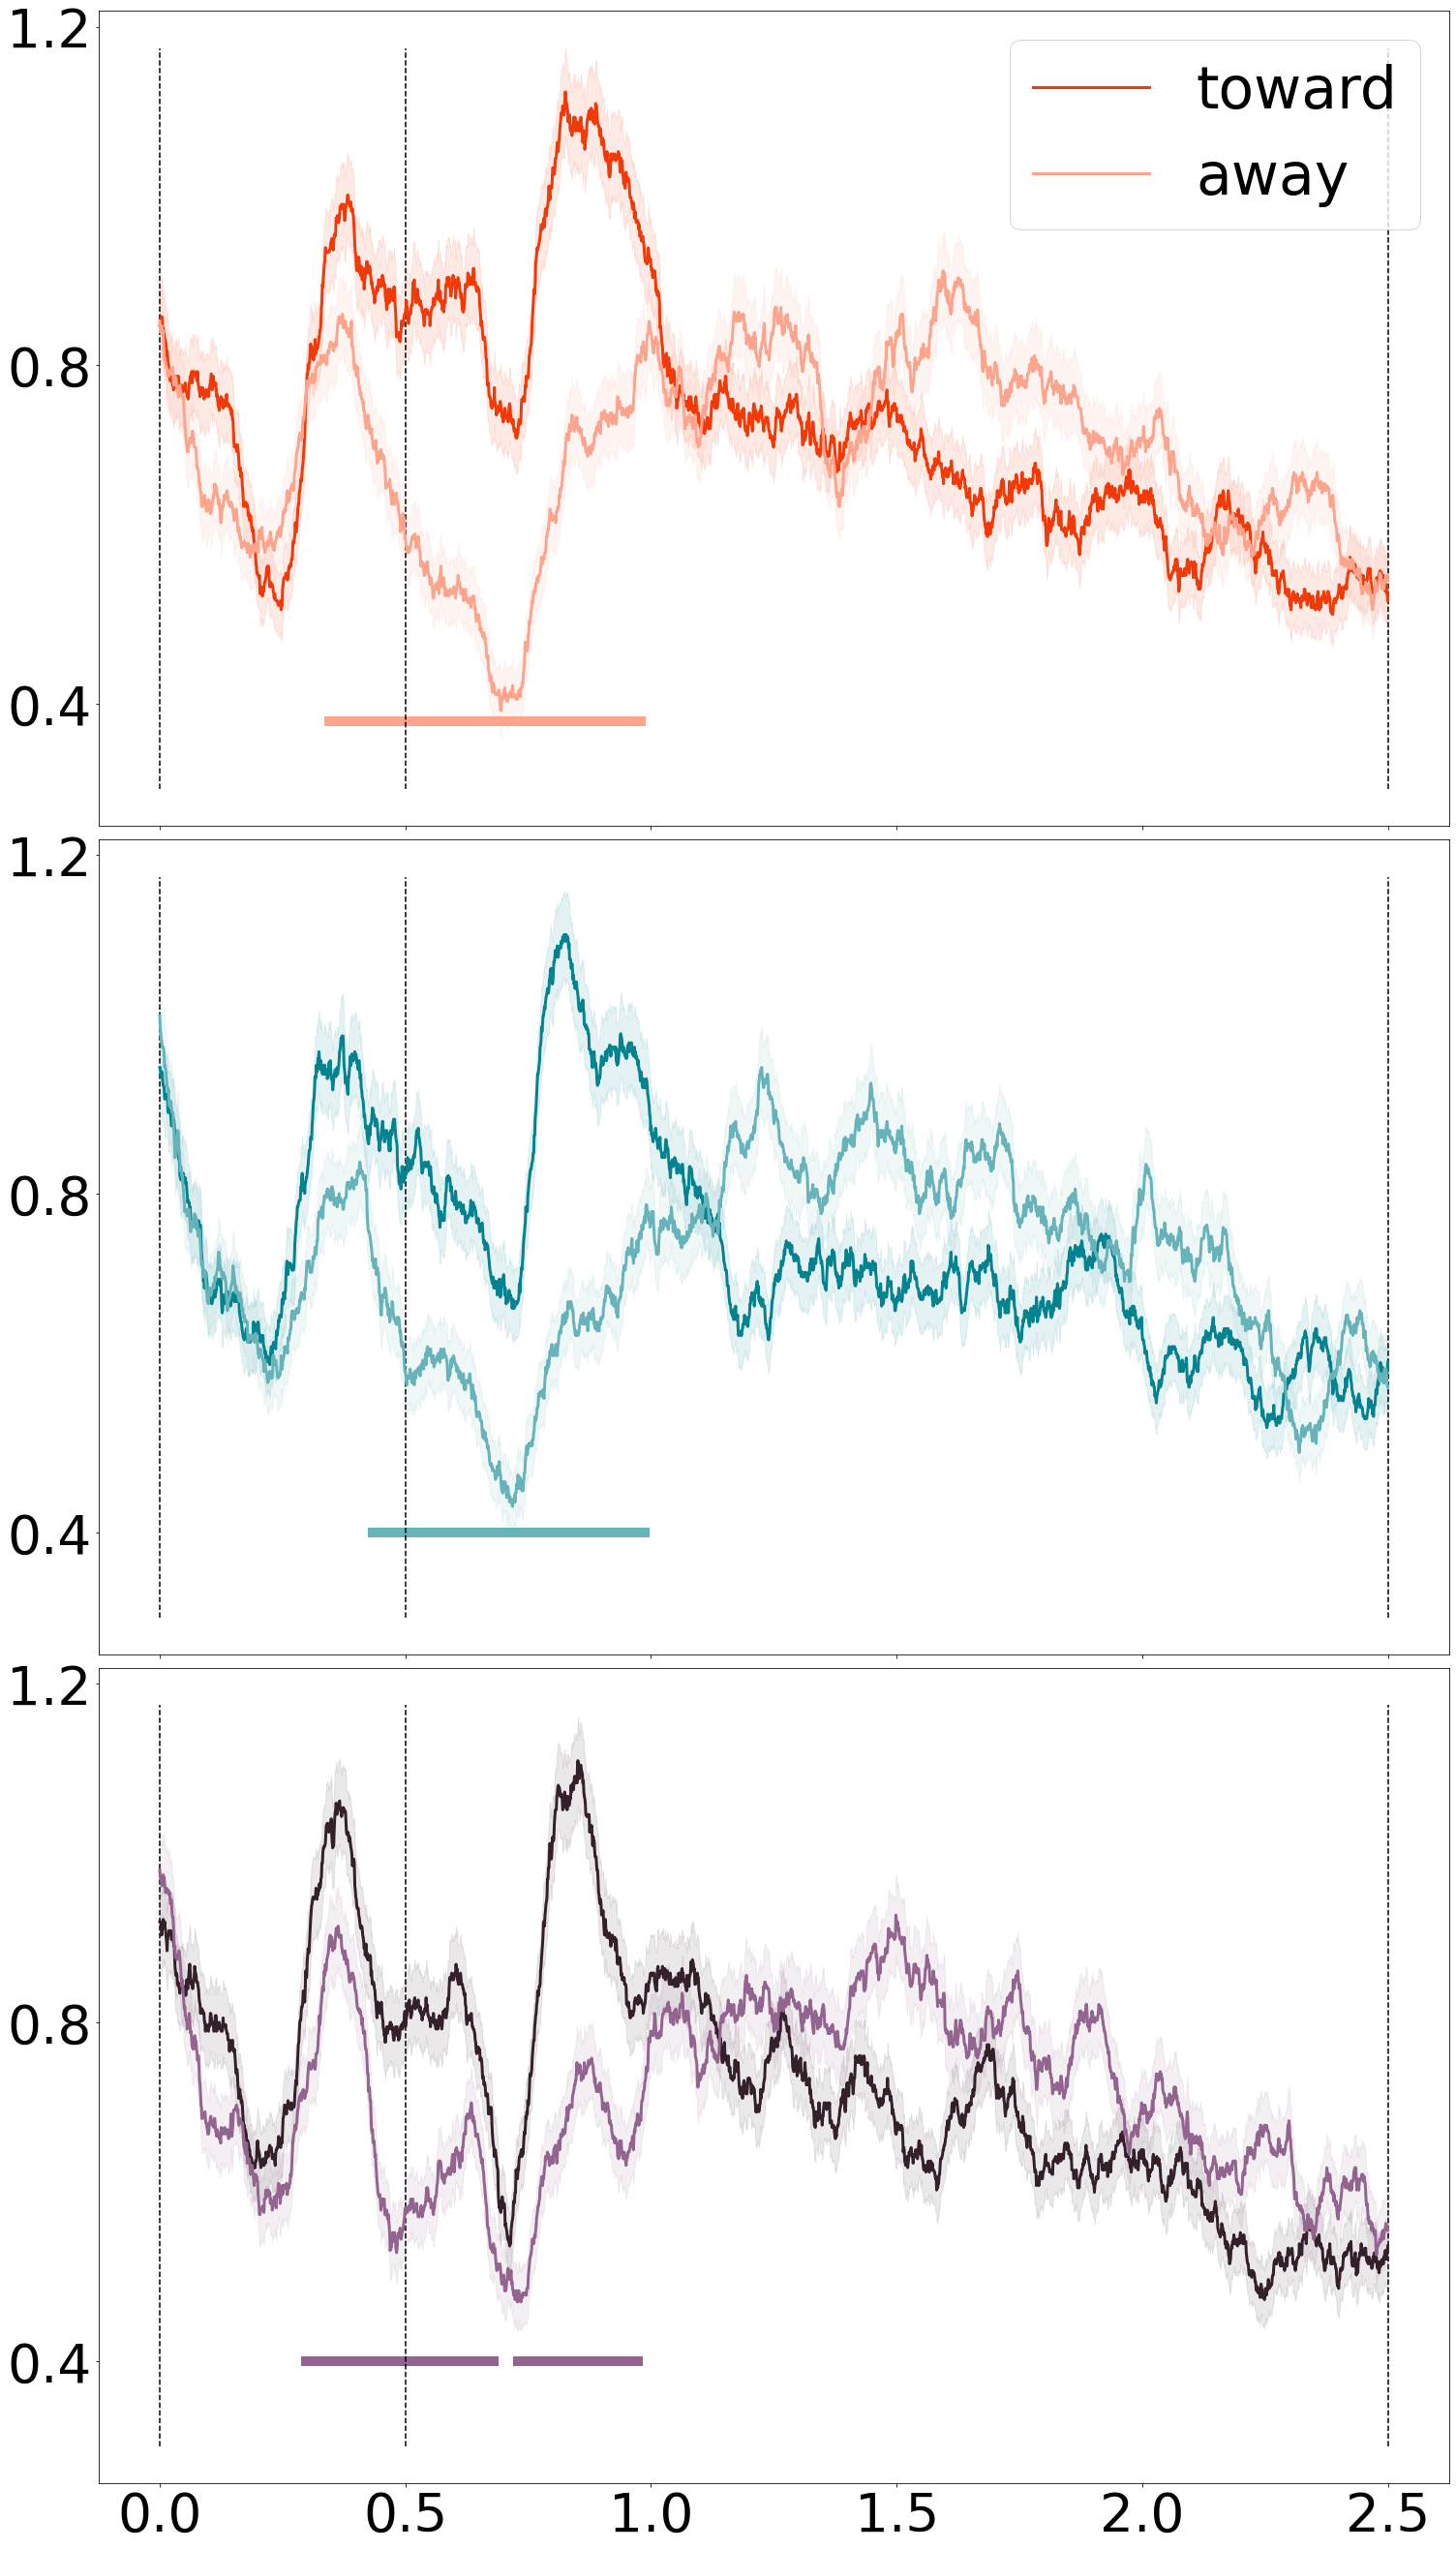

In [42]:
fs(20,36)

x = np.linspace(0,2.5,2500)
fig,ax = plt.subplots(nrows = 3,sharex = True,sharey=True)
cDictToward = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#33202a'}
cDictAway = {"['high']":'#fda48c',"['medium']":'#66b3ba',"['low']":'#93648f'}

[ax[0].hlines(0.38,k[0]/1000,k[-1]/1000,colors = cList[0],linewidth = 10) for k in hInd]
[ax[2].hlines(0.4,k[0]/1000,k[-1]/1000,colors = cList[2],linewidth = 10) for k in lInd]
[ax[1].hlines(0.4,k[0]/1000,k[-1]/1000,colors = cList[4],linewidth = 10) for k in mInd]


[ax[n%3].fill_between(x,towardUpp.iloc[i,0:towardUpp.shape[1]],
                    towardLow.iloc[i,0:towardUpp.shape[1]],
                    color =  cDictToward[towardUpp.index[i]],alpha = 0.1)  for n,i in enumerate([0,2,1])]#
[ax[n%3].plot(x,towardMean.iloc[i,0:towardUpp.shape[1]],color = cDictToward[towardUpp.index[i]],
               linewidth = 3,label = 'toward') for n,i in  enumerate([0,2,1]) ]

[ax[n%3].fill_between(x,awayUpp.iloc[i,0:awayUpp.shape[1]],
                    awayLow.iloc[i,0:awayUpp.shape[1]],
                    color =  cDictAway[awayUpp.index[i]],alpha = 0.1, )  for n,i in enumerate([0,2,1])]
[ax[n%3].plot(x,awayMean.iloc[i,0:awayUpp.shape[1]],color = cDictAway[awayUpp.index[i]],
              linewidth = 3,label = 'away') for n,i in  enumerate([0,2,1])]#


#add text and event marker
[ax[i].vlines((np.array(eventIndex[3:-3])-eventIndex[3])/1000,0.3,towardUpp.max().max(),
           linestyles = 'dashed',colors= 'black') for i in range(len(towardMean))]

#for i,m in zip((np.array(eventIndex[3:-4])-eventIndex[3])/1000,events[3:-4]):
    #ax[0].text(i,towardUpp.max().max(),m,c = 'black',size = 30)

#plt.ylim(0,1)
ax[0].legend(prop = {'size' : 60})
plt.tight_layout()
[ax[i].tick_params( labelsize=55) for i in range(3) ]
[ax[i].yaxis.set_major_locator(ticker.MultipleLocator(0.4)) for i in range(3)]

plt.show()



In [23]:
temp = towardRetroX.iloc[:,:2500].values - awayRetroX.iloc[:,:2500].values 
freqDiff = pd.concat([pd.DataFrame(temp),towardRetroX.iloc[:,-3:]],axis =1)

In [24]:
diffMean = freqDiff.groupby(['cue_blk_validity']).mean().iloc[:,:2500]
diffSderr = freqDiff.groupby(['cue_blk_validity',]).sem().iloc[:,:2500]

diffUpp = diffMean + diffSderr
diffLow = diffMean - diffSderr


## permutation for the block comparison

In [45]:
#downsample, take mean of every 80ms
binLen = 10

towardnessDiff = pd.DataFrame(tempToward.iloc[:,:1000].values- tempAway.iloc[:,:1000].values)
towardnessDiff100 = towardnessDiff.groupby(np.arange(1000)//binLen,axis=1).mean()
towardnessDiff100 = pd.concat([towardnessDiff100, tempAway.iloc[:,-4:]],axis = 1)

towardnessDiff100.columns = towardnessDiff100.columns.astype(str)

In [507]:
k = [pg.anova(data = towardnessDiff100, dv = i,
              between = ['cue_blk_validity'])[['F','p-unc']].iloc[0,:] for i in towardnessDiff100.columns[:100].values]

In [508]:
"""
# for each iteraction

perms = 5000
fCluster = np.zeros(perms) # permutation iteration x data x f and p 

for n in range(perms):
        print(n)
        # shuffle block label
        towardnessDiff100['randLabel'] = np.random.permutation(towardnessDiff100.cue_blk_validity.values)

        # for each time point, 2 way anova with blk reliability and cued item as dv, and the data as dv
        # get the f score for the interaction effect
        fpThis = np.array([pg.anova(data = towardnessDiff100, dv = i,
              between = ['randLabel'])[['F','p-unc']].iloc[0,:] for i in towardnessDiff100.columns[:100].values])
        fArr = fpThis[:,0]

        # find the clusters that exceed p value threshold; slightly increase the threshold to account for the
        # noise level
        consGroups = consecutive(np.where(fpThis[:,1] < 0.05)[0], stepsize=2,
                        findSame = False)
        
        # find the cluster with the largest length,then find its corresponding t values, sum it up
                #note: if no cluster is found, this will return 0
        fCluster[n] =  np.round(fArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)
"""

"\n# for each iteraction\n\nperms = 5000\nfCluster = np.zeros(perms) # permutation iteration x data x f and p \n\nfor n in range(perms):\n        print(n)\n        # shuffle block label\n        towardnessDiff100['randLabel'] = np.random.permutation(towardnessDiff100.cue_blk_validity.values)\n\n        # for each time point, 2 way anova with blk reliability and cued item as dv, and the data as dv\n        # get the f score for the interaction effect\n        fpThis = np.array([pg.anova(data = towardnessDiff100, dv = i,\n              between = ['randLabel'])[['F','p-unc']].iloc[0,:] for i in towardnessDiff100.columns[:100].values])\n        fArr = fpThis[:,0]\n\n        # find the clusters that exceed p value threshold; slightly increase the threshold to account for the\n        # noise level\n        consGroups = consecutive(np.where(fpThis[:,1] < 0.05)[0], stepsize=2,\n                        findSame = False)\n        \n        # find the cluster with the largest length,then find it

In [509]:
fCluster = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/permutationResults_7rej/saccInteractionClusterPermutation5000_el100hz_first1000ms_7rej.csv').iloc[:,1:].T.values[0]

In [510]:
#pd.DataFrame(fCluster).to_csv('saccInteractionClusterPermutation5000_el100hz_first1000ms_7rej')

In [511]:
realF = np.array(k)[:,0]
realP = np.array(k)[:,1]

consGroups = consecutive(np.where(realP <= 0.05)[0], stepsize=2,
                        findSame = False)
fsum = [realF[i].sum() for i in consGroups]


(0.0, 50.0)

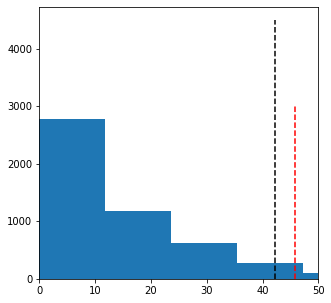

In [512]:
fs(5,5)
plt.hist(fCluster,bins = 10)
plt.vlines([fsum],0,3000,linestyles = 'dashed',color ='r')
plt.vlines(np.percentile(fCluster,95),0,4500,linestyles = 'dashed',color ='black')
plt.xlim(0,50)

In [513]:
sum(fCluster > fsum[0])/5000

0.0368

In [514]:
consGroups[0]

array([62, 63, 64, 65, 66, 68, 69, 70, 71], dtype=int64)

NameError: name 'consGroups' is not defined

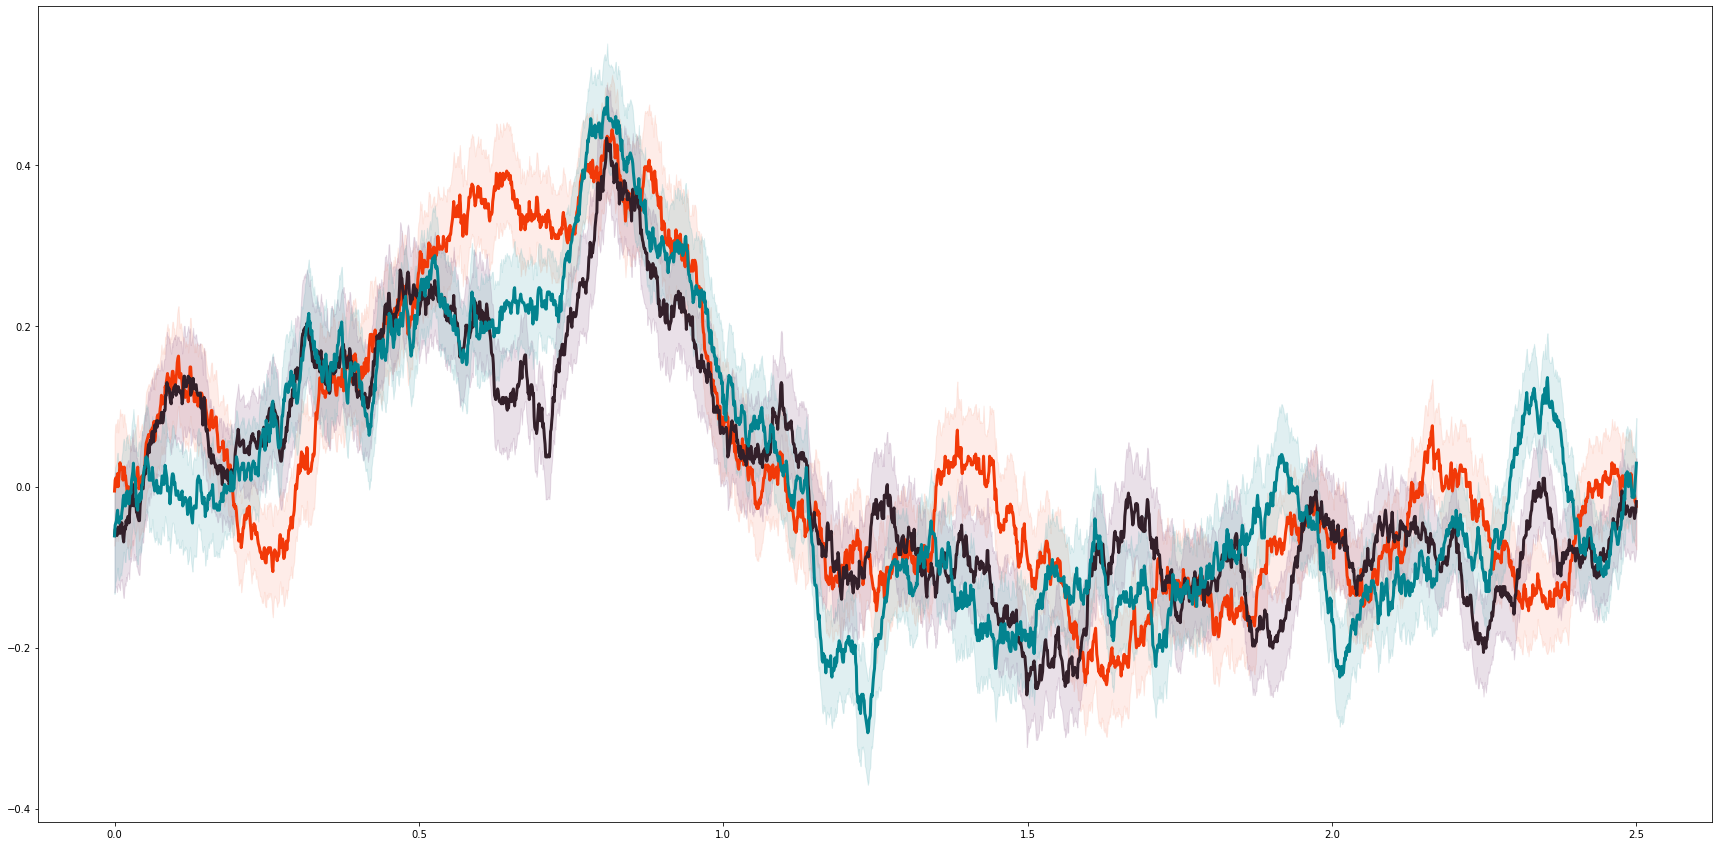

In [29]:
x = np.linspace(0,2.5,2500)
condN = 3
diffMean= towardMean - awayMean

fs(30,15)
fig,ax = plt.subplots(nrows=1,sharex=True,sharey=True)

[plt.plot(x,diffMean.iloc[i,:],color = cDictToward[diffMean.index[i]],
          linewidth = 3,label = diffMean.index[i]) for i in range(condN) ]

[plt.fill_between(x,diffUpp.iloc[i,0:diffUpp.shape[1]],
                    diffLow.iloc[i,0:diffLow.shape[1]],
                    color =  cDictAway[awayUpp.index[i]],alpha = 0.2, ) for i in range(condN)]
ax.hlines(-0.25,consGroups[0][0]/100,consGroups[0][-1]/100,colors = 'gray',linewidth = 20)

plt.vlines((np.array(eventIndex[3:-3])-eventIndex[3])/1000,-0.25,0.55,
           linestyles = 'dashed',colors= 'black')

#for i,m in zip((np.array(eventIndex[3:-4])-eventIndex[3])/1000,events[3:-4]):
   # plt.text(i,diffMean.max().max(),m,c = 'black',size = 30)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.tick_params( labelsize=40)
#plt.legend()
plt.hlines(0,0,2.5,linestyles = 'dashed',colors= 'black')
plt.show()

# binned avg

In [46]:
towardnessDiff = pd.DataFrame(tempToward.iloc[:,:2500].values- tempAway.iloc[:,:2500].values)


In [47]:
towardnessDiff250 = towardnessDiff.groupby(np.arange(2500)//250,axis=1).mean()
towardnessDiff250 = pd.concat([towardnessDiff250, tempAway.iloc[:,-4:]],axis = 1)
towardnessDiff250['subj'] = [ast.literal_eval(i)[0] for i in towardnessDiff250.identifier]
towardnessDiff250 = towardnessDiff250.groupby(['subj','cue_blk_validity','towardness']).mean().reset_index()
towardnessDiff250 = towardnessDiff250.melt(id_vars=['subj','cue_blk_validity','towardness'],value_vars=np.arange(10),var_name='epoch',value_name='freqDiff')


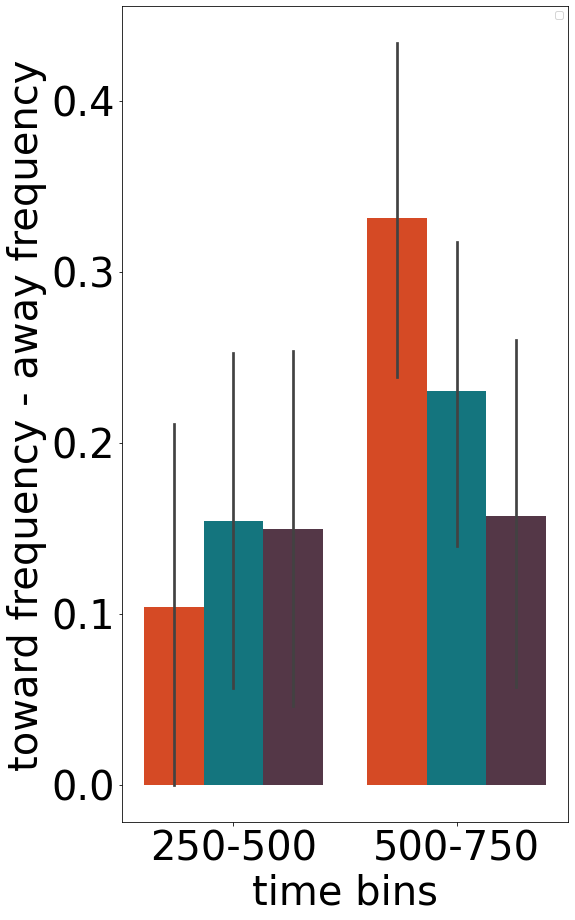

In [48]:
fs(8,15)

fig,ax = plt.subplots(nrows=1,sharex=True,sharey=True)
sns.barplot(x = 'epoch',hue = 'cue_blk_validity',y = 'freqDiff',palette=cDict.values(),
            hue_order= ["['high']","['medium']","['low']"],
            data = towardnessDiff250[towardnessDiff250.epoch.isin([1,2,])],
            ax = ax)

plt.tick_params(labelsize = 40,)
plt.xticks(ticks = [0,1],labels = ['250-500','500-750'])
plt.xlabel(xlabel = 'time bins',fontsize = 40)
plt.ylabel(ylabel = 'toward frequency - away frequency',fontsize = 40)
plt.legend("")

ax.axes.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

In [519]:
pg.rm_anova(data = towardnessDiff250[towardnessDiff250.epoch.isin([1,2,])].reset_index(drop = True),
            dv = 'freqDiff', subject = 'subj',
            within = ['cue_blk_validity','epoch'],effsize = 'np2')

Source        SS  ddof1  ddof2        MS         F  \
0          cue_blk_validity  0.174848      2     82  0.087424  1.394707   
1                     epoch  0.680362      1     41  0.680362  5.726314   
2  cue_blk_validity * epoch  0.533818      2     82  0.266909  6.124092   

      p-unc  p-GG-corr       np2       eps  
0  0.253724   0.253888  0.032898  0.909470  
1  0.021376   0.021376  0.122550  1.000000  
2  0.003320   0.003328  0.129957  0.999308

In [520]:
saccFreqBinned = towardnessDiff.iloc[:,500:750].mean(axis= 1)
saccFreqBinned = pd.concat([saccFreqBinned, tempAway.iloc[:,-4:]],axis = 1)
saccFreqBinned['subj'] = [ast.literal_eval(i)[0] for i in saccFreqBinned.identifier]
saccFreqBinned = saccFreqBinned.groupby(['subj','cue_blk_validity','towardness']).mean().reset_index()
saccFreqBinned.rename(columns={0:'freqDiff'},inplace=True)

In [521]:
saccFreqBinned

subj cue_blk_validity towardness  freqDiff
0    148         ['high']       away  0.316735
1    148          ['low']       away  0.677959
2    148       ['medium']       away -0.020800
3    149         ['high']       away -0.321818
4    149          ['low']       away  0.086087
..   ...              ...        ...       ...
121  195          ['low']       away -0.527647
122  195       ['medium']       away -0.107097
123  197         ['high']       away  0.464167
124  197          ['low']       away  0.214021
125  197       ['medium']       away  0.167347

[126 rows x 4 columns]

In [522]:
pg.rm_anova(data = saccFreqBinned,subject = 'subj',
         dv = 'freqDiff',within = ['cue_blk_validity'],effsize='np2').round(3)

Source  ddof1  ddof2      F  p-unc    np2    eps
0  cue_blk_validity      2     82  7.131  0.001  0.148  0.996

In [523]:
saccFreqBinned = towardnessDiff.iloc[:,250:500].mean(axis= 1)
saccFreqBinned = pd.concat([saccFreqBinned, tempAway.iloc[:,-4:]],axis = 1)
saccFreqBinned['subj'] = [ast.literal_eval(i)[0] for i in saccFreqBinned.identifier]
saccFreqBinned = saccFreqBinned.groupby(['subj','cue_blk_validity','towardness']).mean().reset_index()
saccFreqBinned.rename(columns={0:'freqDiff'},inplace=True)

In [524]:
pg.anova(data = saccFreqBinned,
         dv = 'freqDiff',between = ['cue_blk_validity'],effsize='np2').round(3)

Source  ddof1  ddof2     F  p-unc    np2
0  cue_blk_validity      2    123  0.27  0.764  0.004

# first detected ms magnitude

In [476]:
twTemp = towardShiftsRetro.iloc[:,250:750].abs()
awTemp = awayShiftsRetro.iloc[:,250:750].abs()

In [477]:
twTemp['500to750FstNonZero'] = twTemp.replace(0, np.nan).bfill(1).iloc[:, 0]
awTemp['500to750FstNonZero'] = awTemp.replace(0, np.nan).bfill(1).iloc[:, 0]

In [478]:
sum(twTemp['500to750FstNonZero'].isnull()),sum(awTemp['500to750FstNonZero'].isnull())

(6826, 7959)

In [543]:
gsMag_toward = pd.concat([twTemp['500to750FstNonZero'],towardShiftsRetro[['identifier','blk_validity']]],axis = 1)
gsMag_away = pd.concat([awTemp['500to750FstNonZero'],awayShiftsRetro[['identifier','blk_validity']]],axis = 1)

In [544]:
gsMag_toward['subj'] = [ast.literal_eval(i)[0] for i in gsMag_toward.identifier]
gsMag_away['subj'] = [ast.literal_eval(i)[0] for i in gsMag_away.identifier]

In [545]:
gsMagMean_toward = gsMag_toward.groupby(['subj','blk_validity']).mean().reset_index(drop = False)
gsMagMean_away = gsMag_away.groupby(['subj','blk_validity']).mean().reset_index(drop = False)

In [546]:
gsMagMean_toward['type'] = 'toward'
gsMagMean_away['type'] = 'away'

In [548]:
gsMagMean = pd.concat([gsMagMean_toward,gsMagMean_away]).reset_index(drop = True)

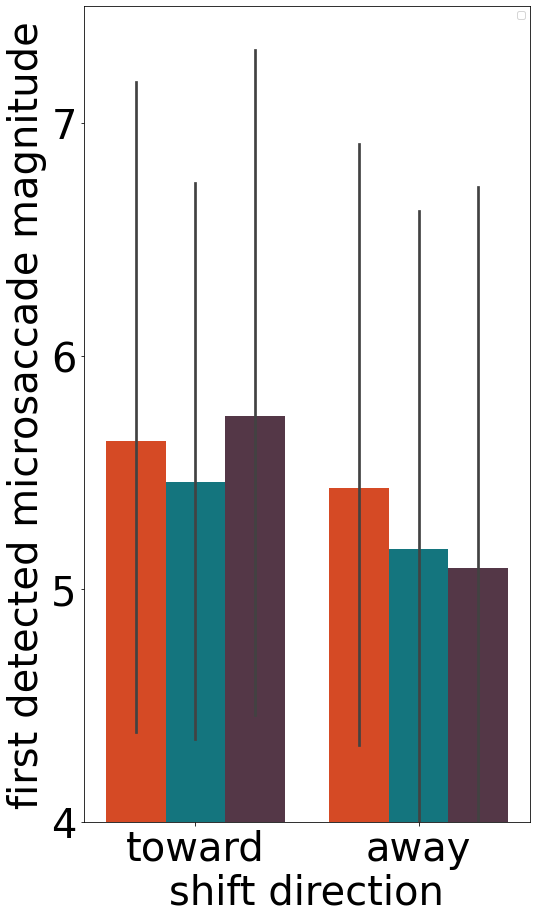

In [563]:
fs(8,15)
fig,ax = plt.subplots(nrows=1,sharex=True,sharey=True)

sns.barplot(x = 'type',hue = 'blk_validity',y = '500to750FstNonZero',
            hue_order = ["['high']","['medium']","['low']"],
            palette = cDict.values(),
            data= gsMagMean)
plt.ylim(4,7.5)
plt.tick_params(labelsize = 40,)
plt.xlabel(xlabel = 'shift direction',fontsize = 40)
plt.legend("")

plt.ylabel('first detected microsaccade magnitude',fontsize = 40)
ax.axes.yaxis.set_major_locator(ticker.MultipleLocator(1))

In [555]:
pg.rm_anova(data = gsMagMean,dv = '500to750FstNonZero',
            within = ['blk_validity','type'],subject= 'subj',effsize = 'np2').round(2)

Source    SS  ddof1  ddof2    MS     F  p-unc  p-GG-corr  \
0         blk_validity  2.01      2     82  1.01  0.46   0.63       0.63   
1                 type  9.12      1     41  9.12  5.66   0.02       0.02   
2  blk_validity * type  2.39      2     82  1.20  0.97   0.38       0.38   

    np2   eps  
0  0.01  0.96  
1  0.12  1.00  
2  0.02  0.93

# temp

In [156]:
#split the df into left and rightward saccades
leftShift = pd.DataFrame(np.where(shiftDf_relX.iloc[:,:2500].values < 0, 1, 0))
rightShift = pd.DataFrame(np.where(shiftDf_relX.iloc[:,:2500].values > 0, 1, 0))

In [209]:
#get frequency
winsize = 100
leftFreq = leftShift.rolling(window = winsize,min_periods = 1,axis = 1).sum()*freq/winsize
rightFreq = rightShift.rolling(window = winsize,min_periods = 1,axis = 1).sum()*freq/winsize

#add back tag
leftFreq = pd.concat([leftFreq,shiftDf_relX.iloc[:,-3:]],axis = 1)
rightFreq = pd.concat([rightFreq,shiftDf_relX.iloc[:,-3:]],axis = 1)

In [210]:
leftMean = leftFreq.groupby(['cue_blk_validity','cue_posi']).mean()
leftSderr = leftFreq.groupby(['cue_blk_validity','cue_posi']).sem()

leftUpp = leftMean + leftSderr
leftLow = leftMean - leftSderr

rightMean = rightFreq.groupby(['cue_blk_validity','cue_posi']).mean()
rightSderr = rightFreq.groupby(['cue_blk_validity','cue_posi']).sem()

rightUpp = rightMean + rightSderr
rightLow = rightMean - rightSderr



In [211]:
cListReverse = ['#f23908','#fda48c','#33202a','#93648f','#03838f','#66b3ba']

In [242]:
leftMinusRightFreq = leftFreq.iloc[:,:2500].values - rightFreq.iloc[:,:2500].values  
leftMinusRightFreq = pd.concat([pd.DataFrame(leftMinusRightFreq),shiftDf_relX.iloc[:,-3:]],axis = 1)

In [243]:
freqDiffMean = leftMinusRightFreq.groupby(['cue_blk_validity','cue_posi']).mean()
freqDiffSderr = leftMinusRightFreq.groupby(['cue_blk_validity','cue_posi']).sem()

freqDiffUpp = freqDiffMean + freqDiffSderr
freqDiffLow = freqDiffMean - freqDiffSderr


'left'

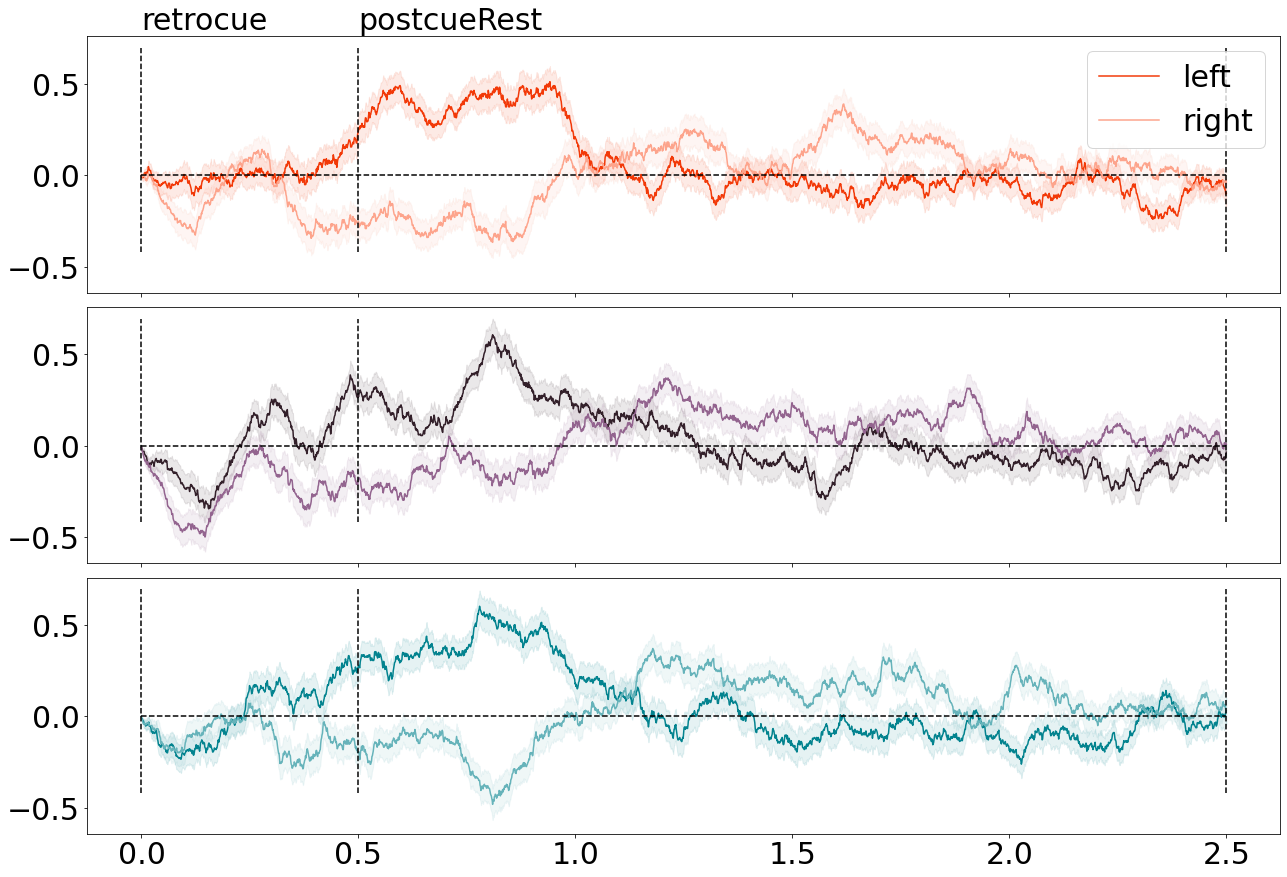

In [247]:
fs(20,12)
xAxis = np.linspace(0,2.5,2500)
fig,ax = plt.subplots(nrows=3,ncols=1,sharex=True,sharey=True)
[ax[i//2].plot(xAxis,freqDiffMean.iloc[i,:],c = cListReverse[i],label = freqDiffMean.reset_index().iloc[i,:].cue_posi) for i in range(6)]
[ax[i//2].fill_between(xAxis,freqDiffUpp.iloc[i,:],freqDiffLow.iloc[i,:],
                       color = cListReverse[i],alpha = 0.1) for i in range(6)]

#add text and event marker
[ax[i].vlines((np.array(eventIndex[3:-3])-eventIndex[3])/1000,freqDiffUpp.min().min(),freqDiffUpp.max().max(),
           linestyles = 'dashed',colors= 'black',) for i in range(3)]
[ax[i].hlines(0,0,2.5,linestyles = 'dashed',colors= 'black',) for i in range(3)]

for i,m in zip((np.array(eventIndex[3:-4])-eventIndex[3])/1000,events[3:-4]):
    ax[0].text(i,freqDiffUpp.max().max()+ 0.1,m,c = 'black',size = 30)

#plt.ylim(0,1)
ax[0].legend(prop = {'size' : 30},bbox_to_anchor = (1.,1))
plt.tight_layout()

[ax[i].tick_params( labelsize=30) for i in range(3) ]

plt.show()

# saccade x cue direction

In [62]:
fs(10,5)


In [31]:
#replace 0 with nan
msRetroX_4scatter = shiftDf_CtrX.replace(0,np.nan)

In [32]:
leftscatter = msRetroX_4scatter[msRetroX_4scatter.cue_posi == 'left'].iloc[:,:2500].reset_index(drop = True)
rightscatter = msRetroX_4scatter[msRetroX_4scatter.cue_posi == 'right'].iloc[:,:2500].reset_index(drop = True)

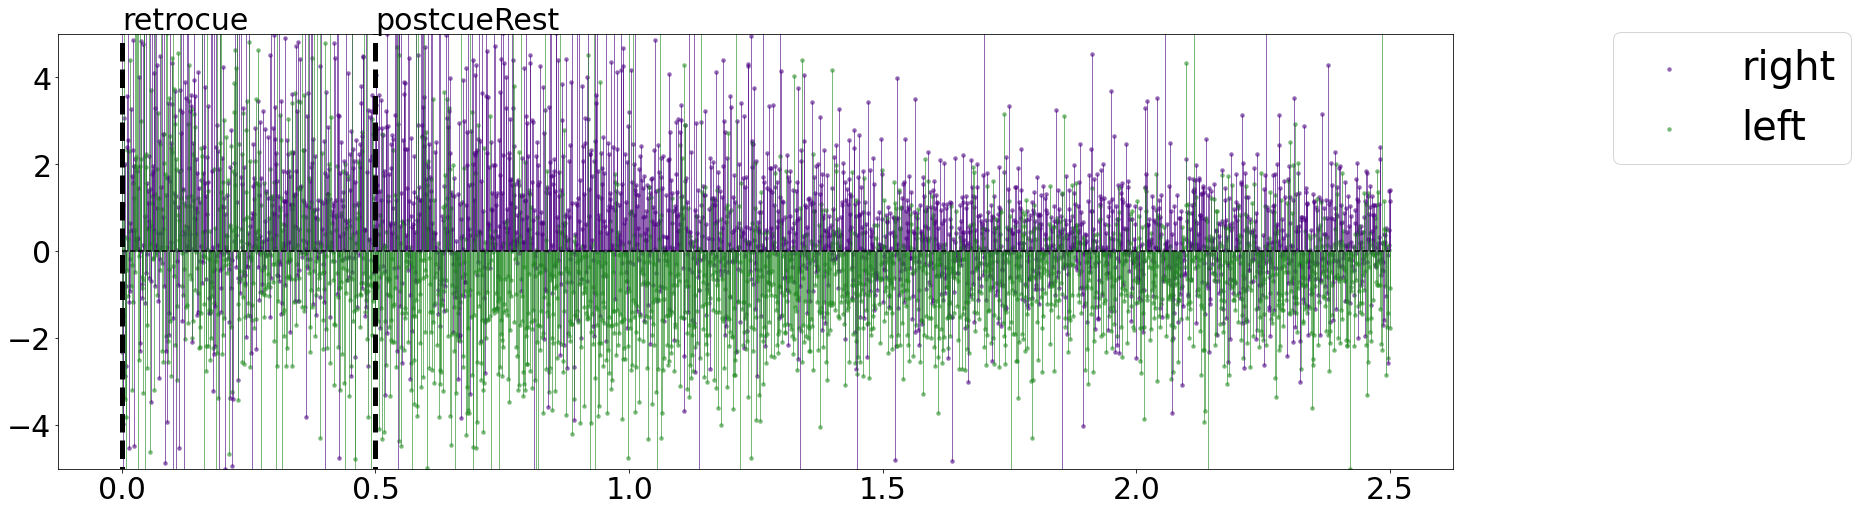

In [33]:
fs(25,8)
x = np.linspace(0,2.5,2500)
transparency = 0.6
markSize = 20
fig,ax = plt.subplots(1)


plt.vlines(x,np.nanmean(rightscatter,axis = 0),0,alpha = transparency,color = 'indigo', linewidth=1,)
sns.scatterplot(x,np.nanmean(rightscatter,axis = 0),alpha = transparency,s = markSize,color = 'indigo', linewidth=0,
                edgecolors='none',label = 'right')


plt.vlines(x,0,np.nanmean(leftscatter,axis = 0),alpha = transparency,color = 'forestgreen', linewidth=1,)
sns.scatterplot(x,np.nanmean(leftscatter,axis = 0),alpha = transparency,s = markSize,color = 'forestgreen', linewidth=0,
                edgecolors='none',label = 'left')


plt.vlines([0,0.5],-20,20,linestyles = 'dashed',colors= 'black',linewidth = 5)


for i,m in zip([0,0.5],['retrocue','postcueRest']):
    plt.text(i,5.1,m,c = 'black',fontsize = 30)

plt.legend(bbox_to_anchor=(1.1, 1.05), prop = {'size' : 40})
plt.hlines(0,0,2.5,linestyles = 'dashed',colors= 'black')

#ax.set_facecolor((128/256, 128/256, 128/256))
plt.ylim(-5,5)
plt.tick_params( labelsize=30)
plt.show()

In [34]:
#get the mean location of the saccade land point
temp = pd.concat([msRetroX_4scatter.iloc[:,1000:2500].mean(axis =1),shiftDf_CtrX.iloc[:,-3:]],axis =1).rename(columns = {0:'meanSaccadeLandingLocation'})
temp['subj'] = [ast.literal_eval(i)[0] for i in temp.identifier]

#get another df for the subj avged
tempSubj = temp.groupby(['subj','cue_posi']).mean().reset_index()

Text(0.5, 0, 'mean horizontal position \n of saccade end point')

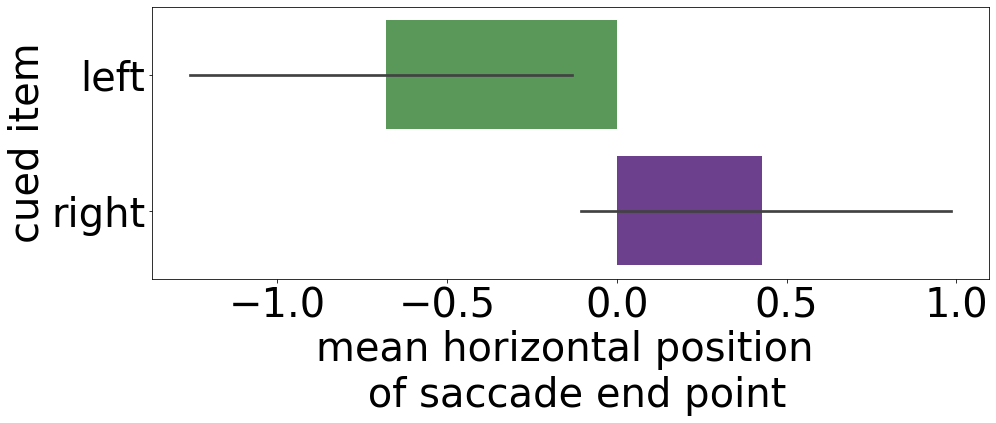

In [35]:
fs(15,5)
fig, ax = plt.subplots()
sns.barplot(y = 'cue_posi', x ='meanSaccadeLandingLocation', orient = 'h',
            data = tempSubj,palette=['forestgreen','indigo'],alpha = 0.8)
plt.tick_params(labelsize = 40)
plt.ylabel('cued item',fontsize = 40)
plt.xlabel('mean horizontal position \n of saccade end point',fontsize = 40)

In [36]:
stats.ttest_rel(tempSubj[tempSubj.cue_posi == 'left'].meanSaccadeLandingLocation,
                tempSubj[tempSubj.cue_posi == 'right'].meanSaccadeLandingLocation, alternative = 'less')


Ttest_relResult(statistic=-7.868522631684228, pvalue=5.036476352666571e-10)

In [37]:
len(tempSubj.subj.unique())

42

In [38]:
leftArr = tempSubj[tempSubj.cue_posi == 'right'].meanSaccadeLandingLocation.values
rightArr = tempSubj[tempSubj.cue_posi == 'left'].meanSaccadeLandingLocation.values

In [39]:
cohenD = np.mean(leftArr-rightArr)/np.std(leftArr-rightArr)

In [40]:
cohenD

1.2288567798957606

# get magnitude x towardness

In [400]:
#for toward df, cast the away to 0
#mag= magnitude, X = horizontal gaze channel
leftToward_magX = shiftDf[shiftDf.cue_posi == 'left'].iloc[:,:5000].where(shiftDf[shiftDf.cue_posi == 'left'].iloc[:,:5000]<0,0)
rightToward_magX = shiftDf[shiftDf.cue_posi == 'right'].iloc[:,:5000].where(shiftDf[shiftDf.cue_posi == 'right'].iloc[:,:5000]>0,0)

#concate, and check if the index is the same, if it is, bring back the tag
toward_magX = pd.concat([leftToward_magX,rightToward_magX]).sort_index()

if sum(toward_magX.index!= shiftDf.index):
    raise AttributeError("index of toward dataframe doesn't match shift dataframe")
else:
    toward_magX = pd.concat([toward_magX,shiftDf[['cue_posi','cue_blk_validity']]],axis = 1)

In [401]:
#do the same for away
leftAway_magX = shiftDf[shiftDf.cue_posi == 'left'].iloc[:,:5000].where(shiftDf[shiftDf.cue_posi == 'left'].iloc[:,:5000]>0,0)
rightAway_magX = shiftDf[shiftDf.cue_posi == 'right'].iloc[:,:5000].where(shiftDf[shiftDf.cue_posi == 'right'].iloc[:,:5000]<0,0)

#concate, and check if the index is the same, if it is, bring back the tag
away_magX = pd.concat([leftAway_magX,rightAway_magX]).sort_index()

if sum(away_magX.index!= shiftDf.index):
    raise AttributeError("index of away dataframe doesn't match shift dataframe")
else:
    away_magX = pd.concat([away_magX,shiftDf[['cue_posi','cue_blk_validity']]],axis = 1)

# get magnitude density

In [402]:
tempToward = gsToward_magX.iloc[:,np.r_[0,np.arange(eventInfo['retrocue'],eventInfo['probecue'])+1,-2,-1]]
tempAway = gsAway_magX.iloc[:,np.r_[0,np.arange(eventInfo['retrocue'],eventInfo['probecue'])+1,-2,-1]]

tempToward['subj'] = [ast.literal_eval(i)[0] for i in tempToward.TRIALID]
tempAway['subj'] = [ast.literal_eval(i)[0] for i in tempAway.TRIALID]

NameError: name 'gsToward_magX' is not defined

In [397]:
def gsMagCount(df,colName,cond,
                 timeStart = 1,timeEnd = 2500,
                 binRange = np.r_[-1,np.arange(0,101,5)],binLabel = np.arange(0,101,5)):
    #count the number of gaze shifts at a certain magnitude
    gsArr = df[df[colName] == cond].iloc[:,timeStart:timeEnd].abs().values.flatten()
    binnedVal = pd.cut(gsArr,bins = binRange,labels=binLabel,).value_counts()
    return binnedVal

In [398]:
towardHigh = np.zeros(shape = (len(readIn),21))
towardMed = np.zeros(shape = (len(readIn),21))
towardLow = np.zeros(shape = (len(readIn),21))

#disregard block validity
for n,i in enumerate(readIn):
    towardHigh[n] = gsMagCount(tempToward[(tempToward.subj ==i)],'cue_blk_validity',"['high']")
    towardMed[n] = gsMagCount(tempToward[(tempToward.subj ==i)],'cue_blk_validity',"['medium']",)
    towardLow[n] = gsMagCount(tempToward[(tempToward.subj ==i)],'cue_blk_validity',"['low']",)

#create the df

towardHigh = pd.DataFrame(towardHigh,index=readIn)
towardMed = pd.DataFrame(towardMed,index=readIn)
towardLow = pd.DataFrame(towardLow,index=readIn)

towardHigh['blk_validity'] = 'high'
towardMed['blk_validity'] = 'medium'
towardLow['blk_validity'] = 'low'
#make the three df into one
towardMagCnt = pd.concat([towardHigh,towardMed,towardLow]).reset_index().sort_values(['index','blk_validity']).set_index('index')

NameError: name 'tempToward' is not defined

In [399]:
#do the same for away
awayHigh = np.zeros(shape = (len(readIn),21))
awayMed = np.zeros(shape = (len(readIn),21))
awayLow = np.zeros(shape = (len(readIn),21))

#disregard block validity
for n,i in enumerate(readIn):
    awayHigh[n] = gsMagCount(tempAway[(tempAway.subj ==i)],'cue_blk_validity',"['high']",)
    awayMed[n] = gsMagCount(tempAway[(tempAway.subj ==i)],'cue_blk_validity',"['medium']",)
    awayLow[n] = gsMagCount(tempAway[(tempAway.subj ==i)],'cue_blk_validity',"['low']",)


#create the df

awayHigh = pd.DataFrame(awayHigh,index=readIn)
awayMed = pd.DataFrame(awayMed,index=readIn)
awayLow = pd.DataFrame(awayLow,index=readIn)

awayHigh['blk_validity'] = 'high'
awayMed['blk_validity'] = 'medium'
awayLow['blk_validity'] = 'low'
#make the three df into one
awayMagCnt = pd.concat([awayHigh,awayMed,awayLow]).reset_index().sort_values(['index','blk_validity']).set_index('index')

NameError: name 'tempAway' is not defined

In [74]:
#convert from counts to density
towardMagDens = towardMagCnt.iloc[:,1:].copy()
awayMagDens = awayMagCnt.iloc[:,1:].copy()

towardMagDens['gsType'] = 'toward'
awayMagDens['gsType'] = 'away'

gsMagDens = pd.concat([towardMagDens,awayMagDens]).reset_index().rename(columns={'index':'subj'})

gsMagDens = gsMagDens.sort_values(by = ['subj','blk_validity','gsType']).reset_index(drop = True)
gsMagDens.set_index('subj',inplace=True)
sftCnt = gsMagDens.groupby(['subj']).sum().sum(axis = 1).reset_index()

gsMagDens = gsMagDens.merge(sftCnt,how = 'left',on = 'subj').rename(columns={0:'shiftCnt'})
gsMagDens.iloc[:,1:-3] = gsMagDens.iloc[:,1:-3].div(gsMagDens.iloc[:,-1],axis =0)*100

# get magnitude point estimate

#avg or sum
tempToward['avgShiftMagnitude'] = tempToward.iloc[:,1:2501].sum(axis = 1)
tempAway['avgShiftMagnitude'] = tempAway.iloc[:,1:2501].sum(axis = 1)

In [397]:
fristShift = shiftDf_ctrX.iloc[:,eventInfo['retrocue']+100:eventInfo['probecue']].replace(0, np.nan).bfill(1).iloc[:, 0]
fristShift = pd.concat([fristShift,shiftDf_ctrX.TRIALID],axis = 1).reset_index(drop = True)
fristShift = fristShift.rename(columns={fristShift.columns[0]: 'magnitude'}) #rename the df for better interpretation

In [398]:
fristShift = fristShift.merge(psyFull[['cue_posi','cue_blk_validity','participant']],right_index=True, how = 'inner', left_on = 'TRIALID').reset_index(drop = True)
nullSaccTrl = fristShift[fristShift.magnitude.isnull()].TRIALID

In [399]:
fristShift = fristShift[~fristShift.magnitude.isnull()].reset_index(drop = True)

In [400]:
leftCongruency = (fristShift.magnitude < 0)& (fristShift.cue_posi  == 'left') #cue = 1 = left,magnitude < 0 
rightCongruency = (fristShift.magnitude > 0)& (fristShift.cue_posi == 'right') #cue = 0 =  right,magnitude >0
fristShift['toward'] = (leftCongruency |rightCongruency).replace(False,'away').replace(True,'toward')

In [401]:
shift1mean = fristShift.groupby(['participant','cue_blk_validity','toward','cue_posi']).mean().reset_index()
shift2mean = fristShift.groupby(['participant','cue_blk_validity','cue_posi']).mean().reset_index()

In [402]:
spaceCLabel = ['lefttoward', 'leftaway', 'rightoward', 'rightaway']
spaceCList = ['#7C3626','#FFCDBC','#414770','#5B85AA']
spaceCDict = dict(zip(spaceCLabel,spaceCList))

<AxesSubplot:xlabel='magnitude', ylabel='cue_blk_validity'>

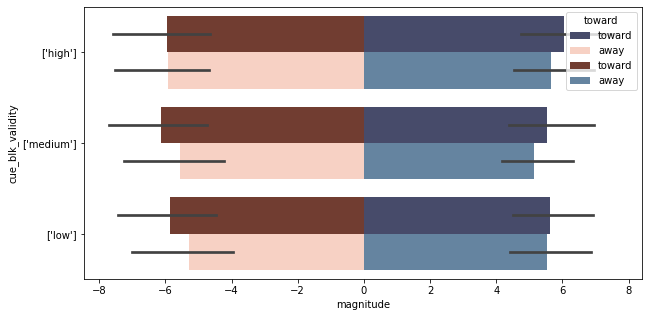

In [403]:
fs(10,5)

fig,ax = plt.subplots()
#, 
sns.barplot(y = 'cue_blk_validity',hue = 'toward',x = 'magnitude',orient = 'h',
            palette=[spaceCDict['rightoward'],spaceCDict['leftaway']], order = ["['high']","['medium']","['low']"],hue_order=['toward','away'],
            data = shift1mean[shift1mean.cue_posi == 'right'],ax = ax,)#, 
sns.barplot(y = 'cue_blk_validity',hue = 'toward',x = 'magnitude',orient = 'h',
            palette=[spaceCDict['lefttoward'],spaceCDict['rightaway']], order = ["['high']","['medium']","['low']"],hue_order=['toward','away'],
            data = shift1mean[shift1mean.cue_posi == 'left'],ax = ax)
#plt.legend(labels=['Hell Yeh', 'Nah Bruh'])#.remove()


In [404]:
shift1mean['absMag'] = shift1mean.magnitude.abs()

<AxesSubplot:xlabel='cue_blk_validity', ylabel='absMag'>

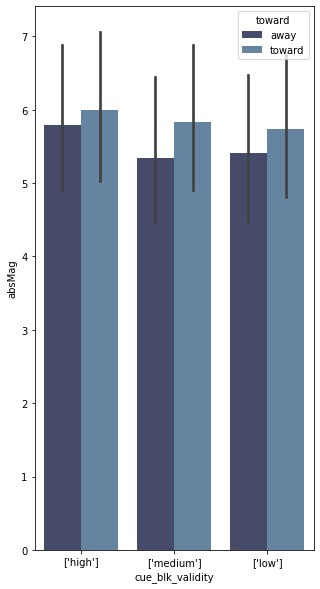

In [405]:
fs(5,10)

sns.barplot(x = 'cue_blk_validity',hue = 'toward',y = 'absMag',
            palette=[spaceCDict['rightoward'],spaceCDict['rightaway']],order = ["['high']","['medium']","['low']"],
            data = shift1mean)#ax = ax[1], 

# plots

In [75]:
gsMagDenSubj = gsMagDens.groupby(['subj','blk_validity','gsType',]).mean().reset_index()

In [76]:
gsMagDenMean = gsMagDenSubj.groupby(['blk_validity','gsType']).mean().iloc[:,:-1]
gsMagDenStdErr = gsMagDenSubj.groupby(['blk_validity','gsType']).sem().iloc[:,:-1]

upper = gsMagDenMean + gsMagDenStdErr
lower = gsMagDenMean - gsMagDenStdErr


In [77]:
fs(10,5)

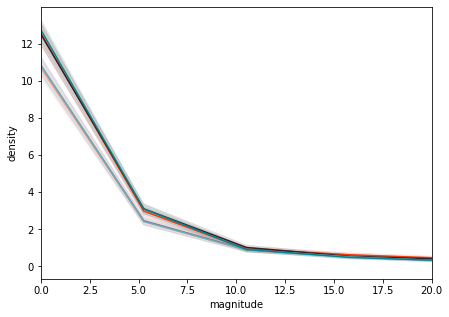

In [83]:
x = np.linspace(0,100,gsMagDenMean.shape[1])

[plt.plot(x,gsMagDenMean.iloc[i,:],c = cList[i]) for i in range(6)]
[plt.fill_between(x,upper.iloc[i,:],lower.iloc[i,:],color = cList[i],alpha = 0.1) for i in range(6)]

#plt.xlim(0,5)
plt.ylabel('density')
plt.xlabel('magnitude')
plt.xlim(0,20)
#plt.ylim(0,2)
plt.show()

In [79]:
titleArr = ['5%','10%','15%','20%','25%']

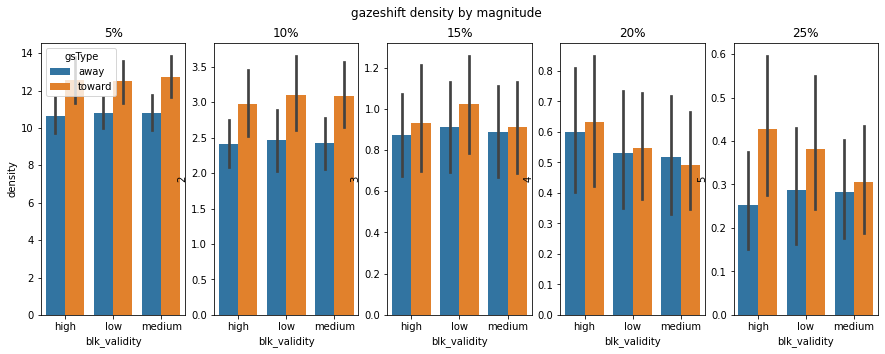

In [80]:
fs(15,5)
fig,ax = plt.subplots(ncols=5)
[sns.barplot(x = 'blk_validity',hue ='gsType',y = i,data= gsMagDenSubj,ax = ax[i-1]) for i in np.arange(1,6)]
[ax[i].get_legend().remove() for i in np.arange(1,5)]
[ax[i].set_title(titleArr[i]) for i in np.arange(5)]
ax[0].set_ylabel('density')
fig.suptitle('gazeshift density by magnitude')
plt.show()

In [81]:
gsMagDenSubj['gsMagAbove5Binned'] = gsMagDenSubj.iloc[:,4:-1].sum(axis = 1)

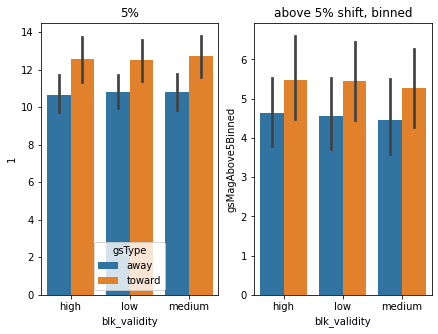

In [82]:
fs(7,5)
fig,ax = plt.subplots(ncols =2)
sns.barplot(x = 'blk_validity',hue ='gsType',y = 1,data= gsMagDenSubj,ax = ax[0])
sns.barplot(x = 'blk_validity',hue ='gsType',y = 'gsMagAbove5Binned',data= gsMagDenSubj,ax = ax[1])

ax[0].set_title('5%')
ax[1].set_title('above 5% shift, binned')
ax[1].get_legend().remove()

# wip

In [43]:
def eDist(a,b): #eucleadian distance
    return np.sqrt(a**2+b**2)

In [44]:
def findGazeShift2d(xvec,yvec,threshold = 6, countTogether = 50, 
                   baseline = None, winlen = 50,shiftmin = 0.2,
                   baselinePadding = 0,shiftWhere = False,):
    """
    @ xvec =  the gaze position horizontal channel
    @ yvec = the gaze position vertical channel
    @ threshold = the velocity filter threshold
    @ countTogether = the maximum delay for two gaze shift cluster to be count as one
    @ baseline = if ***none***, calculate relative baseline  (i.e. in regard to position before and after shift)
                if ***list***, it indicate baseline rage, e.g. [500,1000]
                if ***numeric***, use the numeric value as baseline
    @ winlen = for the onset of each identified gazeshift cluster, get the [-winlen,0] and [winlen, 2+ winlen]
            to calculate the mean gaze position before and after the shift occur
    @ shiftmin = the minimum shift in gaze position for it to be considered as a real shift
            default = 0.2% 
    @ baselinePadding = the padding to add before the identified gaze shift, this is only meaningful if baseline
                        is None (i.e. the shift regarding to gaze position before and after)
    @ shiftWhere = if True, only return the index where shift occurs. This is useful if use needs to combine
                    the horizontal and vertical gaze arrays. 
                    
    """
    # get speed vector
    # since we are using 4 time points to calculate the speed array (see find abs speed sacc function)
    # the len of dx, dy is 4 points less than the length of xvec. 
    dx = find_abs_speed_pup(xvec).astype(float)
    dy = find_abs_speed_pup(yvec).astype(float)
    dxySqrt = eDist(dx,dy)

    #get threshold, then get a boolean array, for finding threshold crossing clusters
    thresholdx = np.nanmedian(dxySqrt) + medianVariance(dxySqrt) *threshold
    cx = dxySqrt>thresholdx
    
    # Deselect period at the beginning and the end of the position array i.e.掐头去尾
    # and re-identify the saccade cluster after applying both masks
    # if two clusteres are close enough (50ms), then count them as one
    onsetoffsetmask = np.r_[np.zeros(winlen + baselinePadding),np.ones(len(cx) - 3*winlen - 2* baselinePadding),np.zeros(2*winlen + baselinePadding)].astype(bool) #to deselect data in the first and last 50ms 
    maskedcx = np.where(cx & onsetoffsetmask)[0] 
    msCluster = consecutive(maskedcx,countTogether)
    
    # initialize the output array with zeros, calculate the mean pos before and after the shift
    gazeshift = np.zeros(len(xvec))   

    # if user only needs to know the location where shift occured, return a boolean array
    # where 1 =  shift occur, 0 = no shift
    if shiftWhere:
        try:
            fillLoc = np.array([i[0] for i in msCluster]) 
            gazeshift[fillLoc] = 1
        except IndexError:
            pass
        return gazeshift

    try:
        for i in msCluster:
            #if user doesn't provide a baseline value, use relative baseline
            if baseline == None:
                befIndex = [i[0] - winlen - baselinePadding,i[0]- baselinePadding]
            else:
                befIndex = baseline
            
            #calculate gaze position before the shift occured 
            if type(baseline) != int:
                try:
                    posbef = np.nanmean(xvec.iloc[befIndex[0] : befIndex[1]])
                except AttributeError: # this is to account for when using df.apply(raw = True),xvec is an array, not series
                    posbef = np.nanmean(xvec[befIndex[0] : befIndex[1]])
            else: #if user decide to use a numerical value as the baseline, use that
                posbef = baseline

            #calculate the gaze position afte the shift
            try:
                posaft = np.nanmean(xvec.iloc[i[-1] : i[-1] + winlen]) 
            except:    
                posaft = np.nanmean(xvec[i[-1]: i[-1] + winlen]) 

            if abs(posaft - posbef) > shiftmin: 
                #toss away a ms if its less than a minimum visual degree 
                gazeshift[i[0]] = posaft - posbef 
            else:
                pass
    except IndexError: #i.e. if msCluster is empty, it gives error when trying to index i[0], in this case just return the 0 array
        return gazeshift
    return gazeshift

In [246]:
q = tempToward.groupby(['cue_blk_validity',]).mean()
q = q.abs()

In [247]:
k = tempAway.groupby(['cue_blk_validity',]).mean()
k = k.abs()

In [254]:
binlen = 100


#get each subject's sacc profile, and bin them
saccSubj = q.iloc[:,:-1].groupby(np.arange(len(q.columns)-1)//binlen, axis=1).mean()
saccNorm = saccSubj.div(saccSubj.sum(axis = 1), axis=0)*100

In [255]:

#get each subject's sacc profile, and bin them
saccSubj2 = k.iloc[:,:-1].groupby(np.arange(len(k.columns)-1)//binlen, axis=1).mean()
saccNorm2 = saccSubj2.div(saccSubj2.sum(axis = 1), axis=0)*100

<AxesSubplot:ylabel='cue_blk_validity'>

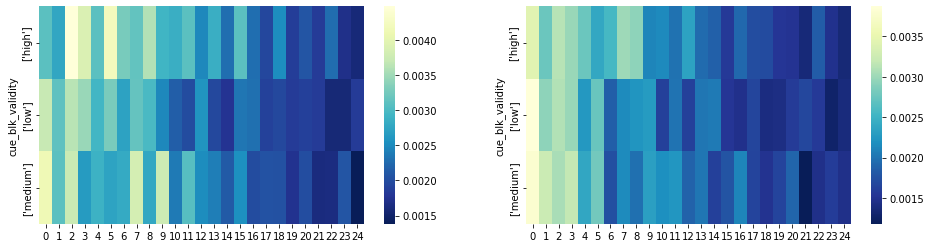

In [256]:
fs(16,4)
fig,ax = plt.subplots(ncols = 2)

sns.heatmap(saccSubj,cmap="YlGnBu_r",ax = ax[0])
sns.heatmap(saccSubj2,cmap="YlGnBu_r",ax = ax[1])

In [411]:
eg = shiftDf_ctrX.iloc[:,eventInfo['retrocue']+100:eventInfo['probecue']]
eg = eg.abs()#need to cast the df to abs value because of the .idxmax() function
firstMsIndex = (eg  != 0).idxmax(1) #find the first occurence of non zero column


In [407]:
#add back the magnitude, and the labels
firstShiftDf = firstMsIndex.reset_index().set_index(shiftDf_ctrX.TRIALID).merge(psyFull[['cue_posi','cue_blk_validity','cue_condition']],
                                                                 left_index=True,right_index=True,how = 'inner').merge(fristShift[['TRIALID','magnitude','toward']],how='left',left_index=True,right_on='TRIALID')
firstShiftDf = firstShiftDf.set_index('TRIALID').drop(['index'],axis = 1).rename(columns={0:'msIndex'})

In [475]:
qq = firstShiftDf[~firstShiftDf.magnitude.isnull()].reset_index(drop = False)

In [476]:
#add some additional features
qq['magAbs'] = qq.magnitude.abs()
qq['magAbsLog'] = np.log(qq['magAbs'])
qq['msIndex'] = qq.msIndex.astype(float)/1000
qq['subj'] = [ast.literal_eval(i)[0] for i in qq.TRIALID]

(2.25, 2.34)

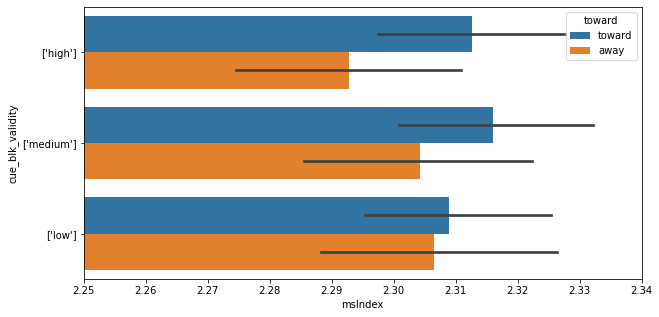

In [535]:
fs(10,5)
sns.barplot(y = 'cue_blk_validity',x = 'msIndex',hue = 'toward',data = qq,orient='h')
plt.xlim(2.25,2.34)

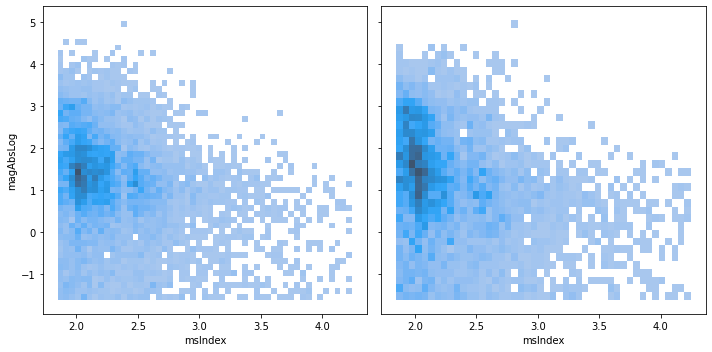

In [474]:
fig,ax = plt.subplots(ncols = 2,sharex=True, sharey=True)
sns.histplot(x = 'msIndex',y = 'magAbsLog', data = qq[qq.toward == 'toward'],ax = ax[0])
sns.histplot(x = 'msIndex',y = 'magAbsLog',data = qq[qq.toward == 'away'],ax = ax[1])

fig.tight_layout()


# tag trial type change

In [508]:
psyTag = psyFullRaw[['identifier','cue_blk_validity','cue_condition','participant','blk.thisN','trials.thisN']]

In [511]:
psyTag['cueCondBinary'] = psyTag.cue_condition.replace('valid',0).replace('invalid',1)

In [518]:
#tag in which direction did the cue condition change for this trial
psyTag['changed'] = np.r_[np.nan,np.diff(psyTag.cueCondBinary.values),]
psyTag['changed'] = psyTag['changed'].replace(1,'valid2Invalid').replace(-1,'invalid2Valid').replace(0,np.nan).fillna(psyTag.cue_condition)

In [571]:
invalid2ValidTrl = psyTag[psyTag.changed == 'invalid2Valid'].identifier.values
invalidConsecutive = psyTag[psyTag.changed == 'invalid'].identifier.values

valid2InvalidTrl = psyTag[psyTag.changed == 'valid2Invalid'].identifier.values
validConsecutive = psyTag[psyTag.changed == 'valid'].identifier.values

(2.25, 2.5)

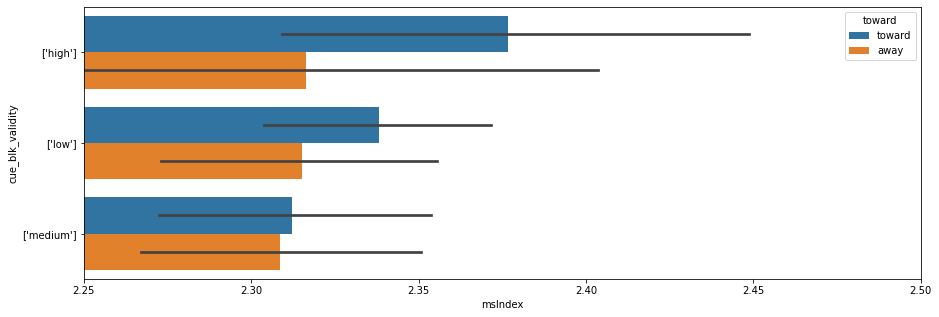

In [578]:
sns.barplot(y = 'cue_blk_validity',x = 'msIndex',hue = 'toward',data = qq[qq.TRIALID.isin(invalid2ValidTrl)],orient='h')
plt.xlim(2.25,2.5)

(2.25, 2.5)

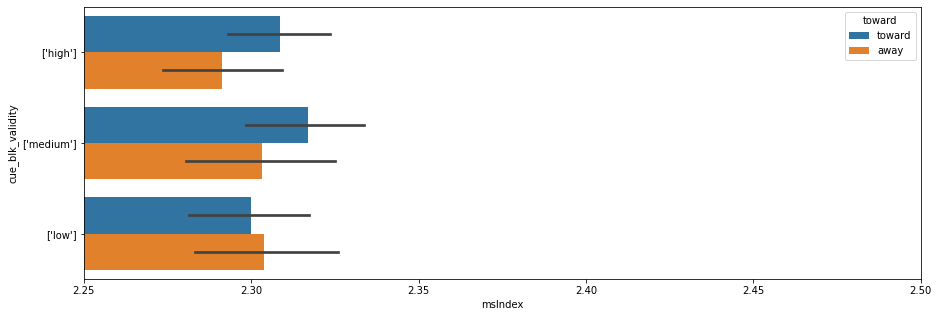

In [579]:
sns.barplot(y = 'cue_blk_validity',x = 'msIndex',hue = 'toward',data = qq[~qq.TRIALID.isin(invalid2ValidTrl)],orient='h')
plt.xlim(2.25,2.5)

Text(0.5, 1.0, 'magnitude consecutive valid trial')

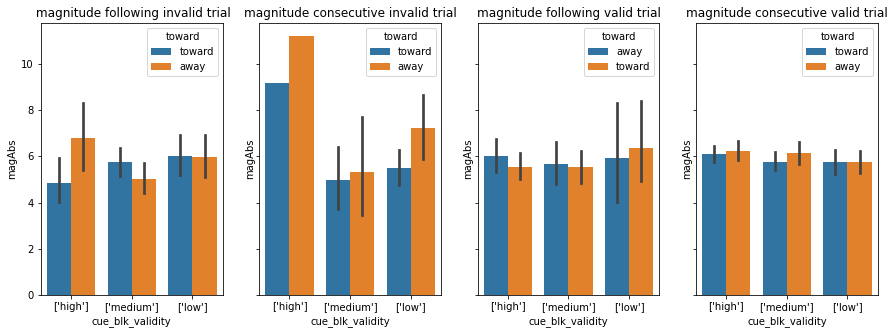

In [575]:
fs(15,5)
fig,ax = plt.subplots(ncols = 4,sharey=True,sharex=True)
sns.barplot(x = 'cue_blk_validity',y = 'magAbs',hue = 'toward',
            data = qq[qq.TRIALID.isin(invalid2ValidTrl)],ax = ax[0])
sns.barplot(x = 'cue_blk_validity',y = 'magAbs',hue = 'toward',order = ["['high']","['medium']","['low']"],
            data = qq[qq.TRIALID.isin(invalidConsecutive)],ax = ax[1])
sns.barplot(x = 'cue_blk_validity',y = 'magAbs',hue = 'toward',
            data = qq[qq.TRIALID.isin(valid2InvalidTrl)],ax = ax[2])
sns.barplot(x = 'cue_blk_validity',y = 'magAbs',hue = 'toward',
            data = qq[qq.TRIALID.isin(validConsecutive)],ax = ax[3])
ax[0].set_title(' magnitude following invalid trial')
ax[1].set_title('magnitude consecutive invalid trial')
ax[2].set_title('magnitude following valid trial')
ax[3].set_title('magnitude consecutive valid trial')

# 6.27 pupil & behav

## normalize using median

## behavioral 

In [933]:
def posToDeg(x,y,arctan2 = False, oneSided = False):

    if type(x) != np.array: #conversion
        x = np.array(x)
        y = np.array(y)

    rad = np.arctan(y/x)
    deg = abs((rad*180/np.pi)-90)

    return deg


In [608]:
#create df for mouse activity
mouseDf = psyFull[['mouse.x','mouse.y','mouse_click','mouse_time']].rename(columns=dict(zip(['mouse.x','mouse.y','mouse_click','mouse_time'],['mousePosX','mousePosY','mouseClick','mouseTime'])))
mouseDf['mousePosX'] = [ast.literal_eval(i) for i in mouseDf.mousePosX]
mouseDf['mousePosY'] = [ast.literal_eval(i) for i in mouseDf.mousePosY]

mouseDf['mouseTime'] = [ast.literal_eval(i) for i in mouseDf.mouseTime]
mouseDf['mouseClick'] = [ast.literal_eval(i) for i in mouseDf.mouseClick]

In [1180]:
fs(6,5)

In [1181]:
eg =np.random.randint(14310)


distance to probed item 6.0
distance to cued item 6.0


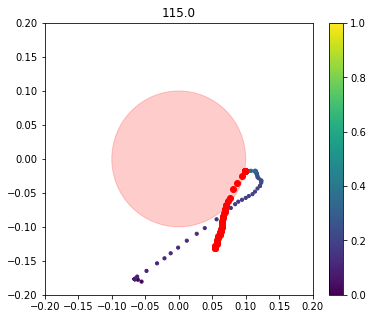

In [1182]:
#get click
clickWhereX = np.array(mouseDf.mousePosX[eg])[np.array(mouseDf.mouseClick[eg]).astype(bool)]
clickWhereY = np.array(mouseDf.mousePosY[eg])[np.array(mouseDf.mouseClick[eg]).astype(bool)]
#plot mouse tracjectory and mouse click location
plt.scatter(mouseDf.mousePosX[eg],mouseDf.mousePosY[eg],c = np.linspace(0,3,len(mouseDf.mousePosY[eg])),s = 10)
plt.scatter(clickWhereX,clickWhereY, c = 'r')
#add probe circle
circle1 = plt.Circle((0, 0), 0.1, color='r',alpha = 0.2)
plt.gca().add_patch(circle1)

#set titles and other figure params
plt.title(psyFull.probed_item_ori[eg])
print('distance to probed item',psyFull.abs_distance_to_probed_item[eg])
print('distance to cued item',psyFull.abs_distance_to_cued_item[eg])

plt.ylim(-0.2,0.2)
plt.xlim(-0.2,0.2)
plt.colorbar()

In [1130]:
#movement initiation
minMoveLen = 0.01

#initial pos, plus or minus some eucledian distance = first initiation
mousePosEDist = [((np.array(egX) - egX[0])**2 + (np.array(egY) - egY[0])**2)**0.5 for egX,egY in zip(mouseDf.mousePosX.values,mouseDf.mousePosY.values)]

#if move more than 1% count it as movement
initMovementIndex = np.zeros(len(mousePosEDist))
for n,i in enumerate(mousePosEDist):
    try:
        initMovementIndex[n] = np.where(i>= minMoveLen)[0][0]
    except: initMovementIndex[n] = np.nan

In [1140]:
#reject trials without movement
mouseDf = mouseDf[~np.isnan(initMovementIndex)]
initMovementIndex = initMovementIndex[np.where(np.isnan(initMovementIndex) == False)]

In [1183]:
#pull out features

In [1148]:
#get the mouse's relative degree regarding to the screen center (0-pi)
mouseDf['mouseDeg'] = [posToDeg(x,y) for x,y in zip(mouseDf.mousePosX,mouseDf.mousePosY)]
mouseDf['initMoveRT'] = [i[int(n)] for n,i in zip(initMovementIndex, mouseDf.mouseTime)]
#mouse first click
mouseDf['firstClickRT'] = [t[np.where(np.array(i)>0)[0][0]] for t,i in zip(mouseDf.mouseTime,mouseDf.mouseClick)]
mouseDf['firstClickRsp'] = [d[np.where(np.array(i)>0)[0][0]] for d,i in zip(mouseDf.mouseDeg,mouseDf.mouseClick)]
#mouse last release
mouseDf['lastReleaseRT'] = [t[np.where(np.array(i)>0)[0][-1]] for t,i in zip(mouseDf.mouseTime,mouseDf.mouseClick)]
mouseDf['lastReleaseRsp'] = [d[np.where(np.array(i)>0)[0][-1]] for d,i in zip(mouseDf.mouseDeg,mouseDf.mouseClick)]

#add the err terms too
mouseDf['firstClickErr'] = [min(abs(p - q),180-abs(p-q)) for p,q in zip(mouseDf.firstClickRsp,mouseDf.probedStimDeg)]
mouseDf['lastReleaseErr'] = [min(abs(p - q),180-abs(p-q)) for p,q in zip(mouseDf.lastReleaseRsp,mouseDf.probedStimDeg)]

#total number of clicks in a given trial
mouseDf['totalClicks'] = [len(consecutive(np.where(np.array(i)>0)[0])) for i in mouseDf.mouseClick]

In [1205]:
#reorder the columns
mouseDf = mouseDf[['mousePosX','mousePosY','mouseDeg','mouseTime','mouseClick','initMoveRT','firstClickRT','firstClickRsp','lastReleaseRT','lastReleaseRsp','totalClicks']]

In [1215]:
#prepare for merging with psychopy output df
psyColumnsOfInterest = ['randomized_probe_dot_degree','cue_blk_validity','cue_condition','abs_distance_to_probed_item','probed_item_ori','cued_item_ori','participant']
newName = ['randDegInit','blkValidity','cueCondition','rspErr','probedStimDeg','cuedStimDeg','subj']
psyFullRelevant = psyFull[psyColumnsOfInterest].rename(columns = dict(zip(psyColumnsOfInterest,newName)))

#merge
mouseDf = mouseDf.merge(psyFullRelevant,how = 'left', left_index = True,right_index = True)


In [1275]:
#look at mean
meanMouse = mouseDf.groupby(['subj','blkValidity','cueCondition']).mean().reset_index()

In [1247]:
fs(5,5)

Text(0.5, 1.0, 'initialize mouse movement RT')

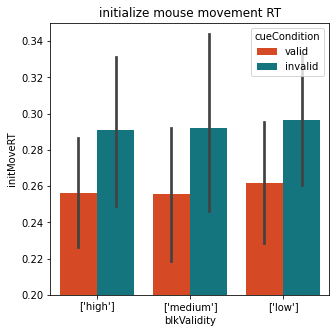

In [1257]:
fig,ax = plt.subplots(ncols = 1)
sns.barplot(x = 'blkValidity',y = 'initMoveRT',order = ["['high']","['medium']","['low']"],hue_order=['valid','invalid'], 
            hue = 'cueCondition',palette = cDict.values(), data =meanMouse)
plt.ylim(0.2,0.35)
plt.title('initialize mouse movement RT')

Text(0.5, 1.0, 'last release RT')

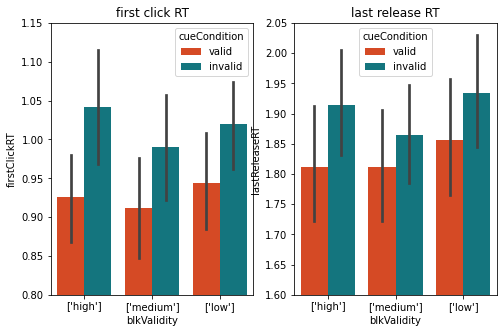

In [1301]:
fs(8,5)
fig,ax = plt.subplots(ncols = 2)

sns.barplot(x = 'blkValidity',y = 'firstClickRT',order = ["['high']","['medium']","['low']"],hue_order=['valid','invalid'], 
            hue = 'cueCondition',palette = cDict.values(), data =meanMouse,ax = ax[0])
sns.barplot(x = 'blkValidity',y = 'lastReleaseRT',order = ["['high']","['medium']","['low']"],hue_order=['valid','invalid'], 
            hue = 'cueCondition',palette = cDict.values(), data =meanMouse,ax = ax[1])

ax[0].set_ylim(0.8,1.15)
ax[1].set_ylim(1.6,2.05)

ax[0].set_title('first click RT')
ax[1].set_title('last release RT')


Text(0.5, 1.0, 'last release Err')

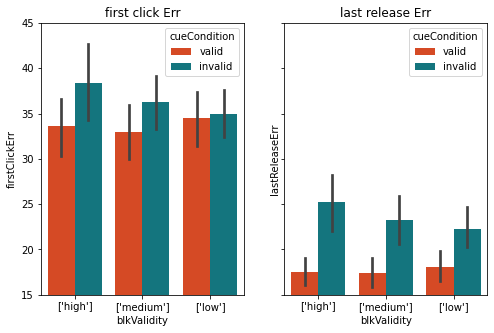

In [1304]:
fs(8,5)
fig,ax = plt.subplots(ncols = 2,sharey = True)

sns.barplot(x = 'blkValidity',y = 'firstClickErr',order = ["['high']","['medium']","['low']"],hue_order=['valid','invalid'], 
            hue = 'cueCondition',palette = cDict.values(), data =meanMouse,ax = ax[0])
sns.barplot(x = 'blkValidity',y = 'lastReleaseErr',order = ["['high']","['medium']","['low']"],hue_order=['valid','invalid'], 
            hue = 'cueCondition',palette = cDict.values(), data =meanMouse,ax = ax[1])


ax[0].set_ylim(15,45)
ax[0].set_title('first click Err')
ax[1].set_title('last release Err')


Text(0.5, 1.0, 'number of clicks on the probe')

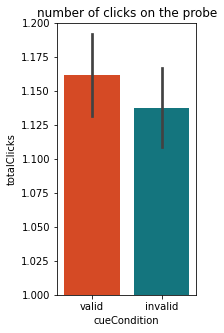

In [1324]:
#number of clicks
sns.barplot(x = 'cueCondition',y = 'totalClicks',order=['valid','invalid'], 
            palette = cDict.values(), data =meanMouse)
plt.ylim(1,1.2)

plt.title('number of clicks on the probe')

<AxesSubplot:xlabel='index', ylabel='blk.thisN'>

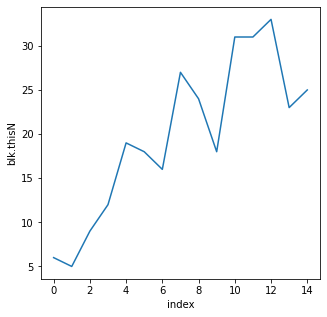

In [ ]:
fs(5,5)
# Most of the no movement trials are in later blocks
subjOfInterest = psyFull.iloc[np.isnan(initMovementIndex)].participant

q  = psyFull.iloc[np.isnan(initMovementIndex)]['blk.thisN'].value_counts().reset_index()
sns.lineplot(x = 'index', y = 'blk.thisN', data =q)

Text(0.5, 1.0, 'avg err ')

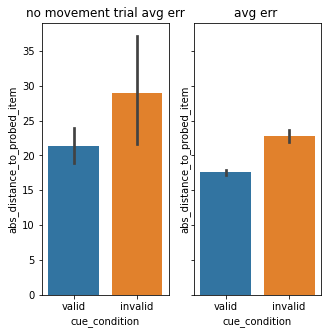

In [ ]:
#avg error on no movement trial is higher than usual
fig,ax = plt.subplots(ncols = 2,sharey = True)
sns.barplot(x = 'cue_condition', y = 'abs_distance_to_probed_item',data  = psyFull.iloc[np.isnan(initMovementIndex)],ax = ax[0])
sns.barplot(x = 'cue_condition', y = 'abs_distance_to_probed_item',data  = psyFull,ax = ax[1])

ax[0].set_title('no movement trial avg err')
ax[1].set_title('avg err ')

# 6.28 mouse and pupil

In [13]:
#read cleaned and retrocue baseline normalized pupil,3000ms
cleanPupRetro = pd.read_csv( 'Z:/LiteBrite_Yueying/temp/cleanPupRetroNorm.csv').iloc[:,1:] 
cleanPupRetro.set_index('identifier',inplace = True)

#read processed mouse trajectory file
mouseDf = pd.read_csv('mouseTrajProcessed.csv',index_col='identifier')

In [14]:
#read the trial change tag, get trials where previous trial is invalid
trlChangeTag = pd.read_csv('psyTagChange.csv',index_col = 'identifier')
chgTrl = trlChangeTag[trlChangeTag.changed.isin(['invalid2Valid','invalid'])].index.values

In [15]:
vviqAll = pd.read_csv('Z:/LiteBrite_Yueying/temp/vviq_auc.csv').iloc[:,1:]

In [18]:
#trials where more than 1 nan occured during the retrocue& delay window
nanInDelayTrl = cleanPupRetro[cleanPupRetro.iloc[:,0:2500].isnull().sum(axis =1) > 0].index.values

In [74]:
#find the delay epoch, take the mean value of the pupil.
temp = cleanPupRetro.iloc[:,500:2500].mean(axis = 1).reset_index().rename(columns = {0:'delayMeanPup'})

#merge onto the mouse df for running corrlation
temp = mouseDf.merge(temp,how = 'inner',left_index = True,right_on = 'identifier')

#add the cued item brightness
temp = temp.merge(psyFull['cued_item'].reset_index(),on = 'identifier')
temp.rename(columns = {'cued_item':'cuedItem'},inplace = True)

#reject the nan countaining trials nanInDelayTrl
temp = temp[~temp.identifier.isin(nanInDelayTrl)].set_index('identifier')

In [116]:
#correlation
pupInitMoveRT = temp.groupby(['subj','cuedItem','blkValidity','cueCondition'])[['delayMeanPup','initMoveRT']].corr().reset_index()
pupfstClickRT = temp.groupby(['subj','cuedItem','blkValidity','cueCondition'])[['delayMeanPup','firstClickRT']].corr().reset_index()
puplstReleaseRT = temp.groupby(['subj','cuedItem','blkValidity','cueCondition'])[['delayMeanPup','lastReleaseRT']].corr().reset_index()
pupfstClickErr = temp.groupby(['subj','cuedItem','blkValidity','cueCondition'])[['delayMeanPup','firstClickErr']].corr().reset_index()
puplstReleaseErr = temp.groupby(['subj','cuedItem','blkValidity','cueCondition'])[['delayMeanPup','lastReleaseErr']].corr().reset_index()


Text(0.5, 1.05, 'correlation between delay pupil mean and first movement rt')

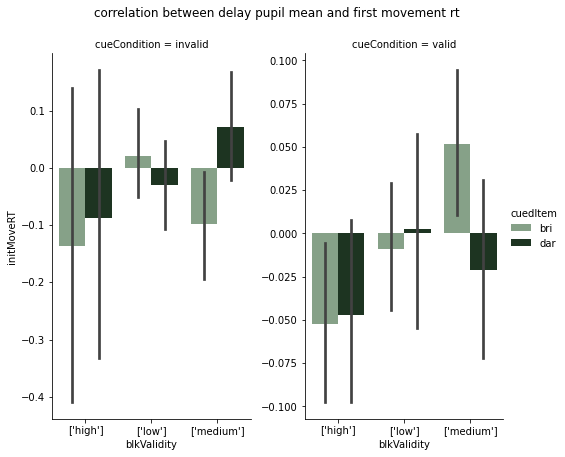

In [158]:
sns.catplot(hue = 'cuedItem',y = 'initMoveRT',kind = 'bar',col = 'cueCondition',
            x = 'blkValidity',data = pupInitMoveRT.iloc[::2],height=6, aspect=.6,sharey = False,
            palette= ['#81A684','#19381F'])
plt.suptitle('correlation between delay pupil mean and first movement rt',y = 1.05)


Text(0.5, 1.05, 'correlation between delay pupil mean and first click rt')

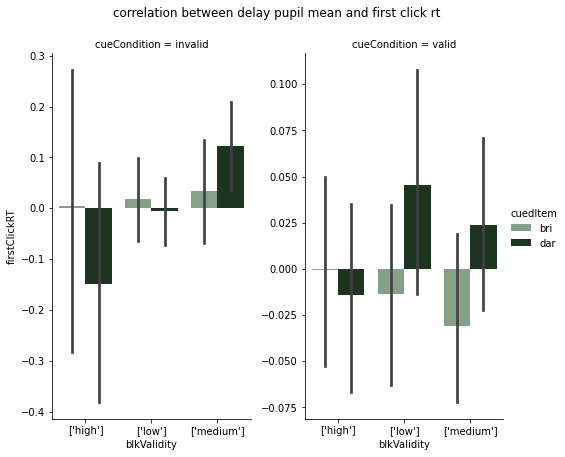

In [161]:
sns.catplot(hue = 'cuedItem',y = 'firstClickRT',kind = 'bar',col = 'cueCondition',
            x = 'blkValidity',data = pupfstClickRT.iloc[::2],height=6, aspect=.6,sharey = False,
            palette= ['#81A684','#19381F'])
plt.suptitle('correlation between delay pupil mean and first click rt',y = 1.05)

Text(0.5, 1.05, 'correlation between delay pupil mean and last release rt')

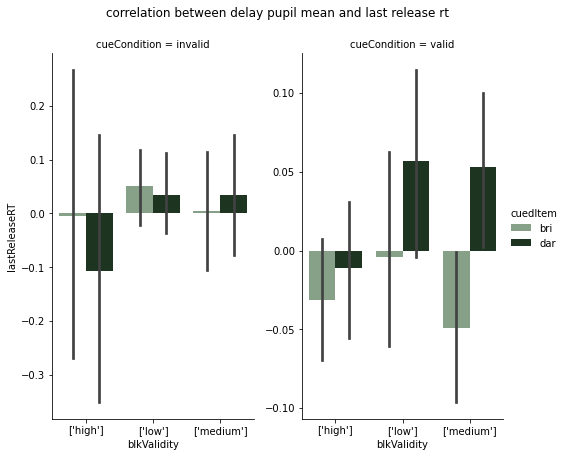

In [162]:
sns.catplot(hue = 'cuedItem',y = 'lastReleaseRT',kind = 'bar',col = 'cueCondition',
            x = 'blkValidity',data = puplstReleaseRT.iloc[::2],height=6, aspect=.6,sharey = False,
            palette= ['#81A684','#19381F'])
plt.suptitle('correlation between delay pupil mean and last release rt',y = 1.05)

Text(0.5, 1.05, 'correlation between delay pupil mean and first click error ')

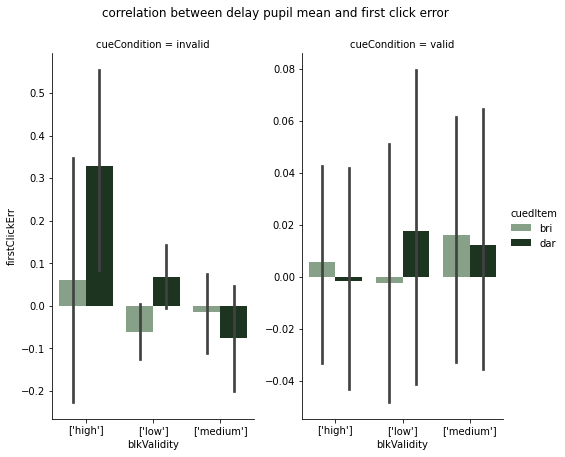

In [163]:
sns.catplot(hue = 'cuedItem',y = 'firstClickErr',kind = 'bar',col = 'cueCondition',
            x = 'blkValidity',data = pupfstClickErr.iloc[::2],height=6, aspect=.6,sharey = False,
            palette= ['#81A684','#19381F'])
plt.suptitle('correlation between delay pupil mean and first click error ',y = 1.05)

Text(0.5, 1.05, 'correlation between delay pupil mean and response error ')

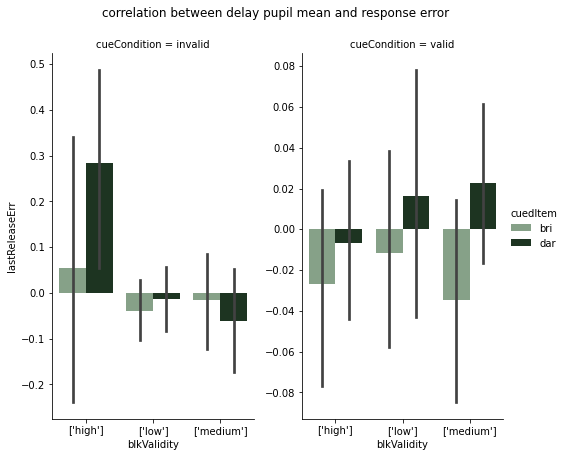

In [164]:
sns.catplot(hue = 'cuedItem',y = 'lastReleaseErr',kind = 'bar',col = 'cueCondition',
            x = 'blkValidity',data = puplstReleaseErr.iloc[::2],height=6, aspect=.6,sharey = False,
            palette= ['#81A684','#19381F'])
plt.suptitle('correlation between delay pupil mean and response error ',y = 1.05)

In [190]:
#rej trials whose previous trial is invalid containing trials

In [183]:
tempNoChange = temp[~temp.index.isin(chgTrl)]

In [184]:
#correlation
pupInitMoveRT = tempNoChange.groupby(['subj','cuedItem','blkValidity','cueCondition'])[['delayMeanPup','initMoveRT']].corr().reset_index()
pupfstClickRT = tempNoChange.groupby(['subj','cuedItem','blkValidity','cueCondition'])[['delayMeanPup','firstClickRT']].corr().reset_index()
puplstReleaseRT = tempNoChange.groupby(['subj','cuedItem','blkValidity','cueCondition'])[['delayMeanPup','lastReleaseRT']].corr().reset_index()
pupfstClickErr = tempNoChange.groupby(['subj','cuedItem','blkValidity','cueCondition'])[['delayMeanPup','firstClickErr']].corr().reset_index()
puplstReleaseErr = tempNoChange.groupby(['subj','cuedItem','blkValidity','cueCondition'])[['delayMeanPup','lastReleaseErr']].corr().reset_index()


Text(0.5, 1.05, 'correlation between delay pupil mean and first movement rt')

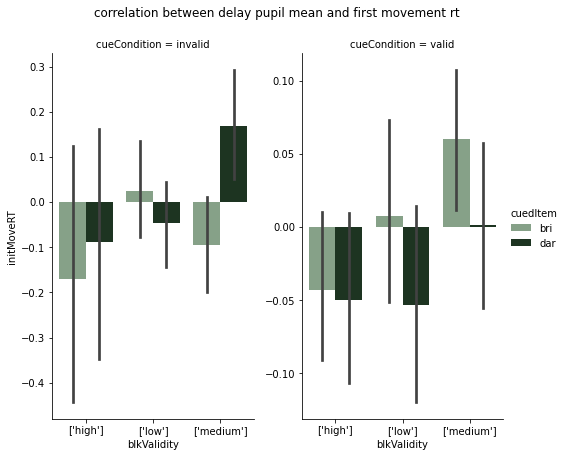

In [185]:
sns.catplot(hue = 'cuedItem',y = 'initMoveRT',kind = 'bar',col = 'cueCondition',
            x = 'blkValidity',data = pupInitMoveRT.iloc[::2],height=6, aspect=.6,sharey = False,
            palette= ['#81A684','#19381F'])
plt.suptitle('correlation between delay pupil mean and first movement rt',y = 1.05)


Text(0.5, 1.05, 'correlation between delay pupil mean and first click rt')

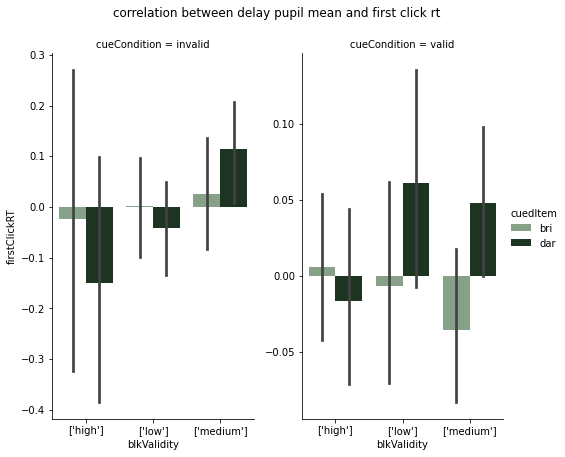

In [186]:
sns.catplot(hue = 'cuedItem',y = 'firstClickRT',kind = 'bar',col = 'cueCondition',
            x = 'blkValidity',data = pupfstClickRT.iloc[::2],height=6, aspect=.6,sharey = False,
            palette= ['#81A684','#19381F'])
plt.suptitle('correlation between delay pupil mean and first click rt',y = 1.05)

Text(0.5, 1.05, 'correlation between delay pupil mean and last release rt')

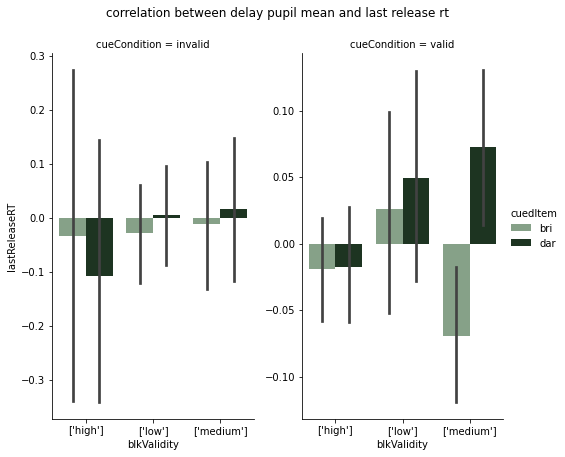

In [187]:
sns.catplot(hue = 'cuedItem',y = 'lastReleaseRT',kind = 'bar',col = 'cueCondition',
            x = 'blkValidity',data = puplstReleaseRT.iloc[::2],height=6, aspect=.6,sharey = False,
            palette= ['#81A684','#19381F'])
plt.suptitle('correlation between delay pupil mean and last release rt',y = 1.05)

Text(0.5, 1.05, 'correlation between delay pupil mean and first click error ')

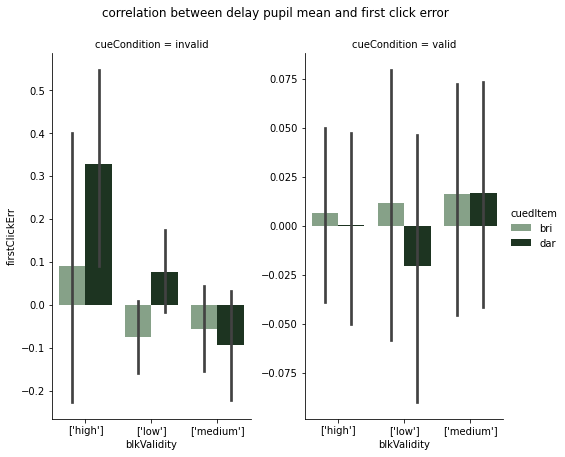

In [188]:
sns.catplot(hue = 'cuedItem',y = 'firstClickErr',kind = 'bar',col = 'cueCondition',
            x = 'blkValidity',data = pupfstClickErr.iloc[::2],height=6, aspect=.6,sharey = False,
            palette= ['#81A684','#19381F'])
plt.suptitle('correlation between delay pupil mean and first click error ',y = 1.05)

Text(0.5, 1.05, 'correlation between delay pupil mean and response error ')

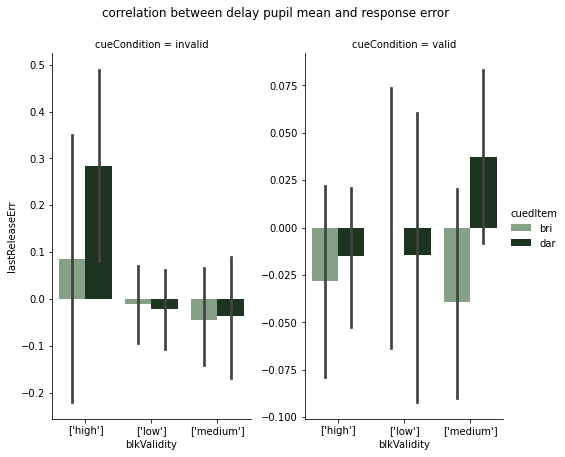

In [189]:
sns.catplot(hue = 'cuedItem',y = 'lastReleaseErr',kind = 'bar',col = 'cueCondition',
            x = 'blkValidity',data = puplstReleaseErr.iloc[::2],height=6, aspect=.6,sharey = False,
            palette= ['#81A684','#19381F'])
plt.suptitle('correlation between delay pupil mean and response error ',y = 1.05)

In [92]:
saccPos

0         1         2         3         4         5         6  \
0      0.020729  0.010312  0.010312  0.072813  0.093646  0.088437  0.025937   
1      0.109375  0.104167  0.109375  0.109375  0.114583  0.151042  0.166667   
2     -0.022083 -0.011667 -0.095000 -0.095000 -0.006458 -0.011667  0.076875   
3     -0.042865 -0.042865 -0.053281 -0.027240 -0.022031  0.009219  0.024844   
4      0.045000  0.018958  0.029375  0.029375 -0.033125 -0.053958 -0.053958   
...         ...       ...       ...       ...       ...       ...       ...   
13839  0.112813  0.175313  0.180521 -0.027812 -0.027812 -0.012188 -0.038229   
13840 -0.033021  0.097188  0.091979  0.045104 -0.012188 -0.038229  0.024271   
13841 -0.027865 -0.017448  0.117969  0.086719  0.076302  0.055469  0.055469   
13842  0.085208  0.064375  0.012292 -0.039792  0.017500  0.106042  0.106042   
13843 -0.080781 -0.070365 -0.054740  0.033802  0.049427  0.018177  0.007760   

              7         8         9        10        11        12        13  \
0      0.046771  0.083229  0.072813  0.051979  0.051979  0.098854  0.062396   
1      0.151042  0.130208  0.119792  0.072917  0.062500  0.026042  0.015625   
2      0.076875  0.097708  0.097708  0.108125  0.102917  0.087292  0.087292   
3      0.004010 -0.027240 -0.105365 -0.110573 -0.167865 -0.162656 -0.173073   
4     -0.053958 -0.022708 -0.022708 -0.137292 -0.137292 -0.043542 -0.038333   
...         ...       ...       ...       ...       ...       ...       ...   
13839 -0.012188  0.013854 -0.033021 -0.027812 -0.017396 -0.012188  0.003437   
13840  0.102396  0.076354  0.076354  0.175313  0.149271  0.154479  0.164896   
13841  0.055469  0.117969  0.144010  0.154427  0.133594  0.102344  0.128385   
13842 -0.029375 -0.013750 -0.008542  0.080000 -0.050208 -0.081458 -0.081458   
13843  0.065052  0.122344  0.111927  0.065052  0.065052  0.096302  0.070260   

             14        15        16        17        18        19        20  \
0      0.062396  0.051979  0.046771  0.010312  0.015521  0.046771  0.036354   
1      0.041667  0.046875  0.046875  0.062500  0.098958  0.098958  0.125000   
2      0.097708  0.113333  0.128958  0.066458  0.082083  0.066458  0.071667   
3     -0.183490 -0.219948 -0.245990 -0.245990 -0.245990 -0.214740 -0.199115   
4     -0.048750 -0.048750 -0.017500 -0.017500 -0.007083 -0.022708 -0.022708   
...         ...       ...       ...       ...       ...       ...       ...   
13839 -0.059062 -0.012188 -0.006979  0.024271 -0.017396 -0.006979 -0.012188   
13840  0.180521  0.164896  0.170104  0.102396  0.149271  0.128438  0.102396   
13841  0.065885  0.055469  0.081510  0.159635  0.190885  0.164844  0.149219   
13842 -0.065833 -0.008542 -0.050208 -0.055417  0.064375  0.059167  0.059167   
13843  0.007760  0.054635  0.065052  0.028594  0.054635  0.059844  0.049427   

             21        22        23        24        25        26        27  \
0      0.015521  0.010312  0.067604  0.067604  0.078021  0.078021  0.041562   
1      0.125000  0.161458  0.161458  0.140625  0.114583  0.067708  0.072917   
2      0.165417  0.222708  0.222708  0.295625  0.290417  0.217500  0.207083   
3     -0.199115 -0.199115 -0.188698 -0.173073 -0.157448 -0.094948 -0.079323   
4      0.013750  0.050208  0.050208 -0.017500 -0.027917  0.024167  0.008542   
...         ...       ...       ...       ...       ...       ...       ...   
13839  0.039896  0.050313  0.008646  0.008646 -0.017396 -0.017396 -0.012188   
13840  0.081562 -0.001771 -0.043437 -0.116354 -0.105937 -0.079896 -0.059062   
13841  0.133594  0.185677  0.242969  0.237760  0.242969  0.133594  0.133594   
13842  0.059167  0.064375  0.053958  0.059167  0.085208  0.100833  0.038333   
13843 -0.002656  0.002552  0.002552 -0.080781 -0.080781 -0.085990 -0.002656   

             28        29        30        31        32        33        34  \
0      0.051979  0.083229  0.088437  0.083229  0.005104  0.005104  0.072813   
1      0.010417  0.005208 -0.031250  0.083333  0.156250  0.1

## re-normalize using median

In [ ]:
#read in the cleaned but unparsed&un-nomalized pupil data
cleanPup = pd.read_csv( 'Z:/LiteBrite_Yueying/temp/cleanPup.csv',index_col='TRIALID').iloc[:,1:]

In [276]:
#parse, use 100ms baseline
blWin = 100

#read in necessary file for parsing
pathUnparsed = 'Z:/LiteBrite_Yueying/temp/unparsed/'
eventDf = pd.concat((pd.read_csv(f).iloc[:,1:] for f in glob.glob(pathUnparsed + 'event'+'/*.csv')), ignore_index=True).reset_index(drop = True)

#find trial timing using the event df
startInd = int(eventDf.stim.mean())
pupAllBLEvent =  [startInd+1- blWin,startInd+1 ]
pupAllEvent =  [startInd+1,(startInd+3751)]

#parse
pupAllBL = cleanPup.iloc[:,pupAllBLEvent[0]:pupAllBLEvent[1]]
pupAll = cleanPup.iloc[:,pupAllEvent[0]:pupAllEvent[1]]


In [277]:
#exclude trial if nan occured in baseline
pupAllBL = pupAllBL[~pupAllBL.isnull().sum(axis =1)<1]

In [334]:
#change the name to stay consistent
oldName = ['participant','cue_blk_validity','cued_item']
newName = ['subj','blkValidity','cuedItem']

#add the median baseline,excluding nan-containing baseline trials
cleanPupAll = pupAll.merge(pupAllBL.median(axis = 1).reset_index().rename(columns = {0:'blMedianPup'}),
            left_index = True,right_on = 'TRIALID',how = 'inner')
cleanPupAll.set_index('TRIALID',inplace = True)

#also add the mean baseline
cleanPupAll['blMeanPup'] = pupAllBL.iloc[:,:-2].mean(axis = 1)

#add back baseline tags
pupAllBL = pd.concat([pupAllBL,cleanPup[['cue_blk_validity','cued_item']].rename(columns = dict(zip(oldName,newName)))],axis = 1)

### try to fix the baseline by using median nomralize

In [330]:
##trying to fix the baseline thing
"""
#median normalize
cleanPupAllNorm = cleanPupAll.iloc[:,:-1].sub(cleanPupAll.blMedianPup,axis = 0)
cleanPupAllNorm = pd.concat([cleanPupAllNorm,cleanPup[['participant',
            'cue_blk_validity','cued_item']].rename(columns = dict(zip(oldName,newName)))],axis = 1)
"""
#mean normalize
cleanPupAllNorm = cleanPupAll.iloc[:,:-1].sub(cleanPupAll.blMeanPup,axis = 0)
cleanPupAllNorm = pd.concat([cleanPupAllNorm,cleanPup[['participant',
            'cue_blk_validity','cued_item']].rename(columns = dict(zip(oldName,newName)))],axis = 1)



In [327]:
#reject trials which, after normalization, has outlying values.
cleanPupAllNormTemp = cleanPupAllNorm[(cleanPupAllNorm.iloc[:,0] < cleanPupAllNorm.iloc[:,0].mean() + 2.5 *cleanPupAllNorm.iloc[:,0].std()) &
                          (cleanPupAllNorm.iloc[:,0] > cleanPupAllNorm.iloc[:,0].mean() - 2.5 *cleanPupAllNorm.iloc[:,0].std())]

pupAllBLTemp = pupAllBLTemp[pupAllBLTemp.index.isin(cleanPupAllNormTemp.index)]

In [432]:

normmean, norm_sterr = pupilPlot(normPup = cleanPupAllNormTemp,blPup = pupAllBLTemp,
          eventt = 3.85,levels=['blkValidity', 'cuedItem'],
          blt  = 0.5,cList = cList,figH=3,figW=8,
          eventBoundary = epoch_array[:-1]+0.1,
          eventName = epoch_name[:-1],)

NameError: name 'cleanPupAllNormTemp' is not defined

### split by behavior

In [30]:
#only select valid trials,subj-wise z score, and select the top 30% and lower30% 
validMouseDf = mouseDf[mouseDf.cueCondition =='valid']

#add a zscored column
q = validMouseDf[['subj','lastReleaseErr']].pivot(columns = 'subj',values='lastReleaseErr').apply(lambda x: stats.zscore(x,nan_policy = 'omit'))
validMouseDf['zscoredRspErr'] = q.sum(axis = 1)

In [470]:
#within subj partition
perfLow,perfHigh = validMouseDf.zscoredRspErr.quantile([0.3,0.7])

perfWorstIndex = validMouseDf[validMouseDf.zscoredRspErr > perfHigh].index.values
perfBestIndex = validMouseDf[validMouseDf.zscoredRspErr < perfLow].index.values
perfMedIndex = validMouseDf[(validMouseDf.zscoredRspErr > perfLow) & (validMouseDf.zscoredRspErr < perfHigh)].index.values

In [480]:
perfLow,perfHigh = validMouseDf.rspErr.quantile([0.3,0.7])

perfWorstIndex = validMouseDf[validMouseDf.rspErr > perfHigh].index.values
perfBestIndex = validMouseDf[validMouseDf.rspErr < perfLow].index.values
perfMedIndex = validMouseDf[(validMouseDf.rspErr > perfLow) & (validMouseDf.zscoredRspErr < perfHigh)].index.values

no baseline passed in


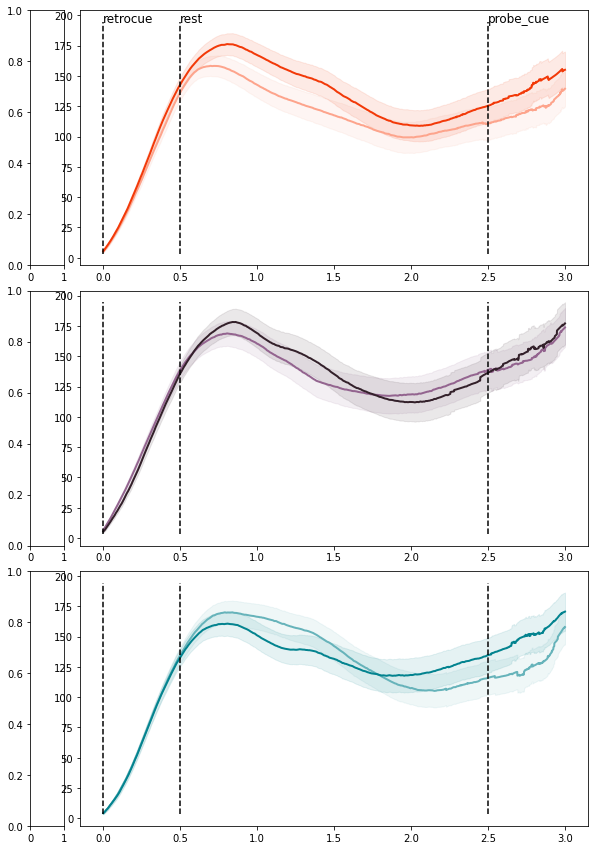

In [481]:
#grand - retro
normmean, norm_sterr = pupilPlot(normPup = cleanPupRetro[cleanPupRetro.index.isin(perfWorstIndex)],blPup = None,
          eventt = 3,
          blt  = 0.5,cList = cList,
          eventBoundary = epoch_array[2:-1]-0.75,
          eventName = epoch_name[2:-1],figW = 10,figH = 5)

no baseline passed in


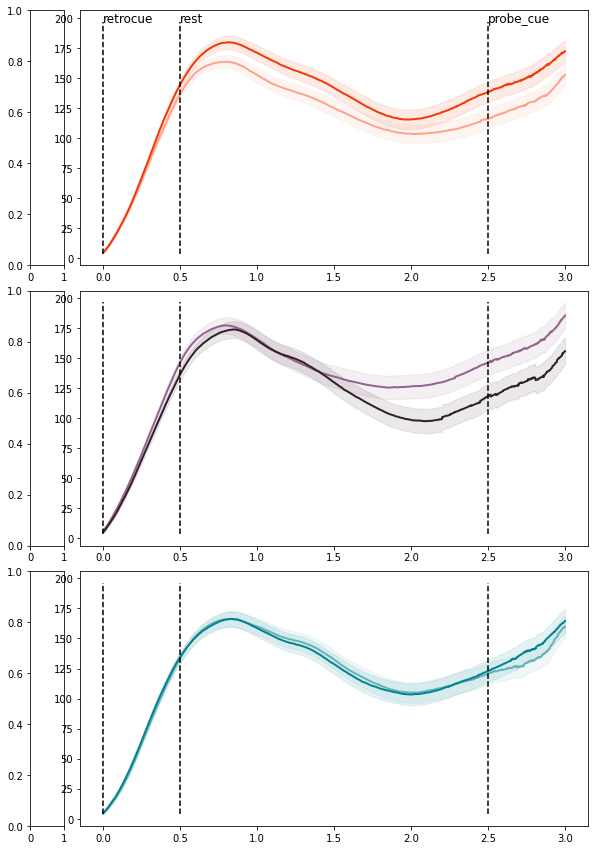

In [482]:
normmean, norm_sterr = pupilPlot(normPup = cleanPupRetro[cleanPupRetro.index.isin(perfMedIndex)],blPup = None,
          eventt = 3,
          blt  = 0.5,cList = cList,
          eventBoundary = epoch_array[2:-1]-0.75,
          eventName = epoch_name[2:-1],figW = 10,figH = 5)

no baseline passed in


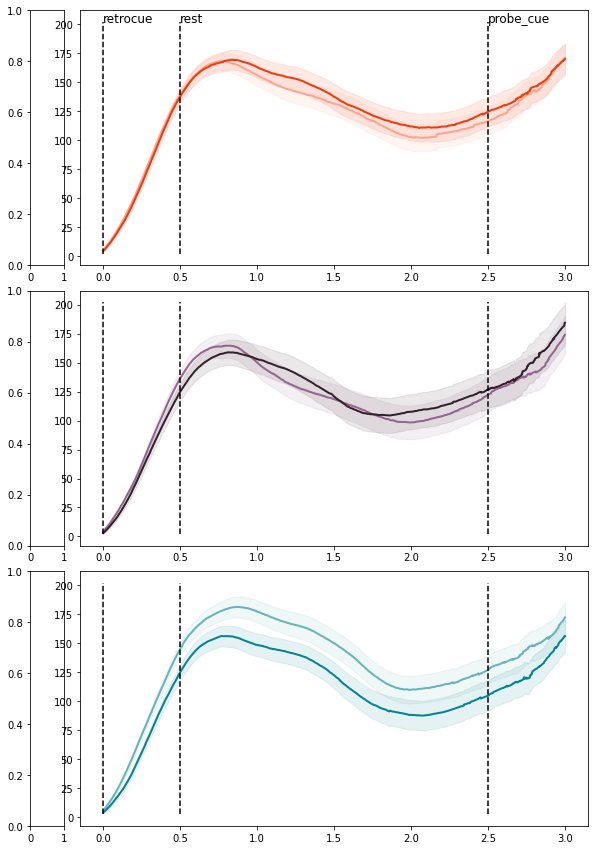

In [483]:
normmean, norm_sterr = pupilPlot(normPup = cleanPupRetro[cleanPupRetro.index.isin(perfBestIndex)],blPup = None,
          eventt = 3,
          blt  = 0.5,cList = cList,
          eventBoundary = epoch_array[2:-1]-0.75,
          eventName = epoch_name[2:-1],figW = 10,figH = 5)

# 6.29 split by vviq, then by trials

In [27]:
temp.head(2)

mousePosX  \
identifier                                                         
('148', 0, 0)  [0.8111111111111111, 0.8175925925925925, 0.821...   
('148', 1, 0)  [0.10740740740740741, 0.10740740740740741, 0.1...   

                                                       mousePosY  \
identifier                                                         
('148', 0, 0)  [0.25833333333333336, 0.2814814814814815, 0.29...   
('148', 1, 0)  [0.10555555555555556, 0.10555555555555556, 0.1...   

                                                        mouseDeg  \
identifier                                                         
('148', 0, 0)  [ 72.33367909  71.00239483  70.27664226  69.74...   
('148', 1, 0)  [ 45.49821161  45.49821161  45.49821161  45.49...   

                                                       mouseTime  \
identifier                                                         
('148', 0, 0)  [0.0013933000154793262, 0.017032900010235608, ...   
('148', 1, 0)  [0.0018498999997973442, 0.015581800020299852, ...   

                                                      mouseClick  initMoveRT  \
identifier                                                                     
('148', 0, 0)  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    0.017033   
('148', 1, 0)  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    0.331156   

               firstClickRT  firstClickRsp  lastReleaseRT  lastReleaseRsp  \
identifier                                                                  
('148', 0, 0)      1.332296      18.434949       2.498425       28.369046   
('148', 1, 0)      0.847889     166.328693       2.314576       57.652557   

               totalClicks  randDegInit blkValidity cueCondition  rspErr  \
identifier                                                                 
('148', 0, 0)            3   129.834883    ['high']        valid    11.0   
('148', 1, 0)            1   171.813931    ['high']      invalid     2.0   

               probedStimDeg  cuedStimDeg  subj  firstClickErr  \
identifier                                                       
('148', 0, 0)           17.0         17.0   148       1.434949   
('148', 1, 0)           56.0          8.0   148      69.671307   

               lastReleaseErr  delayMeanPup cuedItem  
identifier                                            
('148', 0, 0)       11.369046    433.173697      bri  
('148', 1, 0)        1.652557    141.694978      bri

<AxesSubplot:xlabel='blkValidity', ylabel='delayMeanPup'>

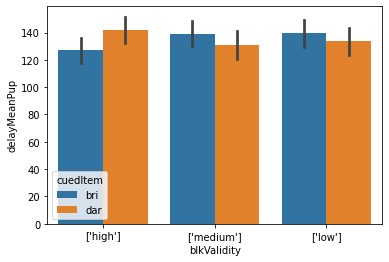

In [29]:
sns.barplot(x = 'blkValidity',y = 'delayMeanPup',hue = 'cuedItem',data = temp)

In [75]:
#get z scored error on valid trials
validMouseDf = mouseDf[mouseDf.cueCondition =='valid']

q = validMouseDf[['subj','lastReleaseErr']].pivot(columns = 'subj',values='lastReleaseErr').apply(lambda x: stats.zscore(x,nan_policy = 'omit'))
validMouseDf['zscoredRspErr'] = q.sum(axis = 1)

In [77]:
# merge the mean pupil column, since it is stored in temp df
validMouseDf = validMouseDf.merge(temp[['delayMeanPup','cuedItem']],left_index = True, right_index = True, how = 'left')

#also add the vviq score
validMouseDf = validMouseDf.merge(vviqAll.set_index('identifier')[['vviq']],left_index = True, right_index = True,how  = 'left')

In [101]:
#get quantiles
vviq = pd.read_csv('Z:/LiteBrite_Yueying/temp/vviq.csv').iloc[2:,:][['id','vviq']]
vviq['id'] = vviq.id.astype(int)
vviqLow, vviqHigh = vviq.vviq.quantile([0.3,0.7])

#get subj id
vviqLowSubj = vviq[vviq.vviq< vviqLow].id.values.astype(int)
vviqHighSubj = vviq[vviq.vviq> vviqHigh].id.values.astype(int)
vviqMedSubj = vviq[(vviq.vviq< vviqHigh) & (vviq.vviq > vviqLow)].id.values.astype(int)

In [120]:
pupErrCorr_allVviq = validMouseDf.groupby(['subj','cuedItem','blkValidity'])[['delayMeanPup','rspErr']].corr().reset_index().iloc[::2].merge(vviq,left_on = 'subj',right_on = 'id')


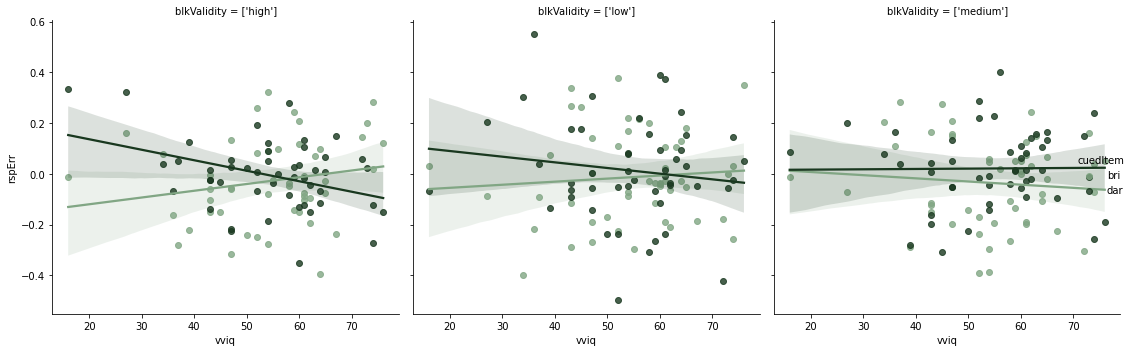

In [123]:
sns.lmplot(x = 'vviq',y = 'rspErr',col = 'blkValidity',palette = ['#81A684','#19381F'],
            hue = 'cuedItem',data = pupErrCorr_allVviq)
plt.tight_layout()


In [113]:
pupErrCorr_lowVviq = validMouseDf[validMouseDf.subj.isin(vviqLowSubj)].groupby(['subj','cuedItem','blkValidity'])[['delayMeanPup','rspErr']].corr().reset_index()
pupErrCorr_highVviq = validMouseDf[validMouseDf.subj.isin(vviqHighSubj)].groupby(['subj','cuedItem','blkValidity'])[['delayMeanPup','rspErr']].corr().reset_index()
pupErrCorr_medVviq = validMouseDf[validMouseDf.subj.isin(vviqMedSubj)].groupby(['subj','cuedItem','blkValidity'])[['delayMeanPup','rspErr']].corr().reset_index()

Text(0.5, 1.05, 'correlation between delay pupil mean and rsp err, split by vviq')

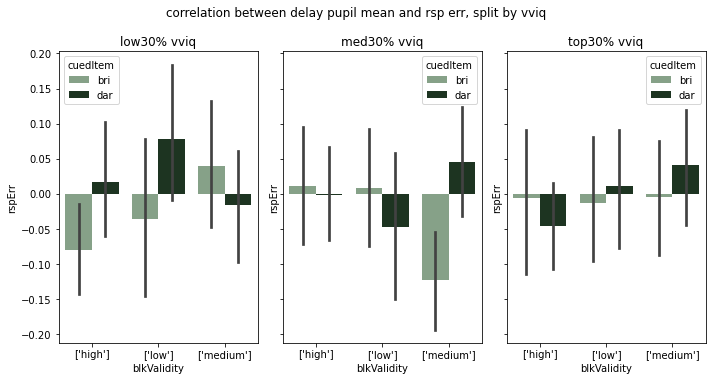

In [118]:
fs(10,5)
fig,ax = plt.subplots(ncols = 3,sharey = True)

sns.barplot(hue = 'cuedItem',y = 'rspErr',
            x = 'blkValidity',data = pupErrCorr_highVviq.iloc[::2],
            palette= ['#81A684','#19381F'],ax = ax[2])

sns.barplot(hue = 'cuedItem',y = 'rspErr',
            x = 'blkValidity',data = pupErrCorr_medVviq.iloc[::2],
            palette= ['#81A684','#19381F'],ax = ax[1])

sns.barplot(hue = 'cuedItem',y = 'rspErr',
            x = 'blkValidity',data = pupErrCorr_lowVviq.iloc[::2],
            palette= ['#81A684','#19381F'],ax = ax[0])

ax[2].set_title('top30% vviq')
ax[1].set_title('med30% vviq')
ax[0].set_title('low30% vviq')


plt.tight_layout()

plt.suptitle('correlation between delay pupil mean and rsp err, split by vviq',y = 1.05)


In [142]:
hDiff = pupErrCorr_allVviq.iloc[::6].reset_index(drop = True)
lDiff = pupErrCorr_allVviq.iloc[1::6].reset_index(drop = True)
mDiff = pupErrCorr_allVviq.iloc[2::6].reset_index(drop = True)

In [143]:
#bri corr - dar corr, for every individual
hDiff['indCorrDiff'] = pupErrCorr_allVviq.iloc[::6].rspErr.values - pupErrCorr_allVviq.iloc[3::6].rspErr.values
lDiff['indCorrDiff'] = pupErrCorr_allVviq.iloc[1::6].rspErr.values - pupErrCorr_allVviq.iloc[4::6].rspErr.values
mDiff['indCorrDiff'] = pupErrCorr_allVviq.iloc[2::6].rspErr.values - pupErrCorr_allVviq.iloc[5::6].rspErr.values

In [147]:
k = pd.concat([hDiff,mDiff,lDiff])

In [148]:
k

subj cuedItem blkValidity       level_3  delayMeanPup    rspErr   id  \
0    148      bri    ['high']  delayMeanPup           1.0  0.091323  148   
1    149      bri    ['high']  delayMeanPup           1.0  0.083114  149   
2    150      bri    ['high']  delayMeanPup           1.0  0.323744  150   
3    151      bri    ['high']  delayMeanPup           1.0  0.283531  151   
4    152      bri    ['high']  delayMeanPup           1.0  0.078834  152   
..   ...      ...         ...           ...           ...       ...  ...   
44   193      bri     ['low']  delayMeanPup           1.0  0.217431  193   
45   194      bri     ['low']  delayMeanPup           1.0  0.130355  194   
46   195      bri     ['low']  delayMeanPup           1.0 -0.216000  195   
47   196      bri     ['low']  delayMeanPup           1.0 -0.069811  196   
48   197      bri     ['low']  delayMeanPup           1.0 -0.288197  197   

    vviq  indCorrDiff  
0   54.0    -0.031813  
1   52.0     0.149665  
2   54.0     0.271480  
3   74.0     0.556979  
4   34.0     0.040700  
..   ...          ...  
44  56.0    -0.002129  
45  64.0    -0.114511  
46  36.0    -0.768525  
47  54.0    -0.022740  
48  43.0    -0.252173  

[147 rows x 9 columns]

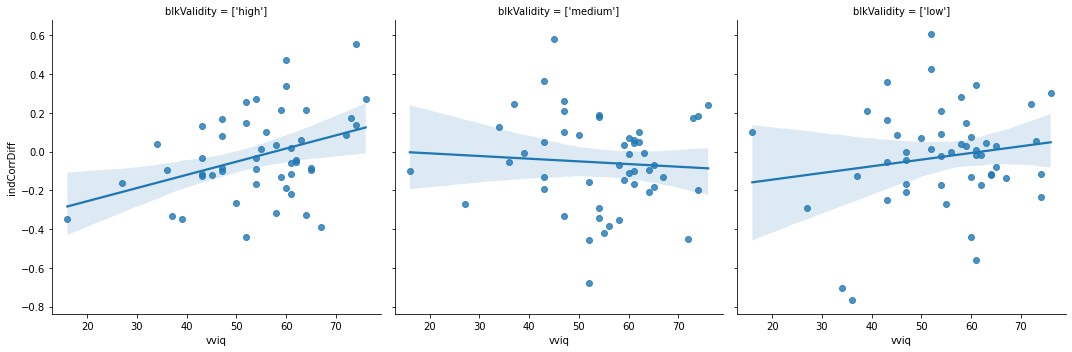

In [150]:
sns.lmplot('vviq','indCorrDiff',col = 'blkValidity',data = k)


# 7.18 split plot by previous trial condition

In [ ]:
#load psychopy file
psyRaw = pd.read_csv('Z:/LiteBrite_Yueying/temp/psyFullRaw.csv').iloc[:,1:]
psyRaw.set_index('identifier',inplace=True)


In [149]:
#load raw pupil file
pupCleanUnnorm = pd.read_csv('Z:/LiteBrite_Yueying/temp/cleanPup.csv').iloc[:,1:]
pupCleanUnnorm_BL = pupCleanUnnorm.iloc[:,np.r_[np.arange(500,1001),-4,-3,-2,-1]]

In [28]:
psyTagDf = psyRaw[['cued_item','cue_condition','cue_blk_validity','participant']]

#prepare to pivot into subj x trial df
psyTagDf['trlBlkID'] = [ast.literal_eval(i)[1:] for i in psyTagDf.index.values]
psyTagDf['blkID'] = [ast.literal_eval(i)[-1] for i in psyTagDf.index.values]
psyTagDf['trlID'] = [ast.literal_eval(i)[1] for i in psyTagDf.index.values]

In [47]:
#identifier: (subj, trial, blk)

In [89]:
#get the previous trial cued item type, considering subj and block seperations; 
tempTag = psyTagDf.pivot(values = 'cued_item',index = ['participant','blkID'],columns=['trlID']).drop(columns=[19]).reset_index()
tempTag = pd.melt(tempTag, id_vars= ['participant','blkID'], value_vars=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
tempTag['trlID'] = tempTag['trlID']+1

tempTag.rename(columns={'value':'cuedItemPreviousTrl'},inplace=True)

tempTag['identifier'] = [str((str(int(i)),j,k)) for i,j,k in zip(tempTag.participant,tempTag.trlID,tempTag.blkID)]

In [114]:
tempTag

participant  blkID trlID cuedItemPreviousTrl       identifier
0            148.0      0     1                 bri    ('148', 1, 0)
1            148.0      1     1                 dar    ('148', 1, 1)
2            148.0      2     1                 bri    ('148', 1, 2)
3            148.0      3     1                 bri    ('148', 1, 3)
4            148.0      4     1                 dar    ('148', 1, 4)
...            ...    ...   ...                 ...              ...
13941        197.0     10    19                 bri  ('197', 19, 10)
13942        197.0     11    19                 dar  ('197', 19, 11)
13943        197.0     12    19                 bri  ('197', 19, 12)
13944        197.0     13    19                 bri  ('197', 19, 13)
13945        197.0     14    19                 dar  ('197', 19, 14)

[13946 rows x 5 columns]

In [160]:
cleanPupRetro2 = cleanPupRetro.merge(tempTag[['identifier','cuedItemPreviousTrl']],how = 'inner',on = 'identifier')
pupCleanUnnorm_BL2 = pupCleanUnnorm_BL.merge(tempTag[['identifier','cuedItemPreviousTrl']],how = 'inner',on = 'identifier')

In [167]:
pupCleanUnnorm_BL2 = pupCleanUnnorm_BL2[pupCleanUnnorm_BL2.identifier.isin(cleanPupRetro2.identifier)].reset_index(drop = True)

no baseline passed in


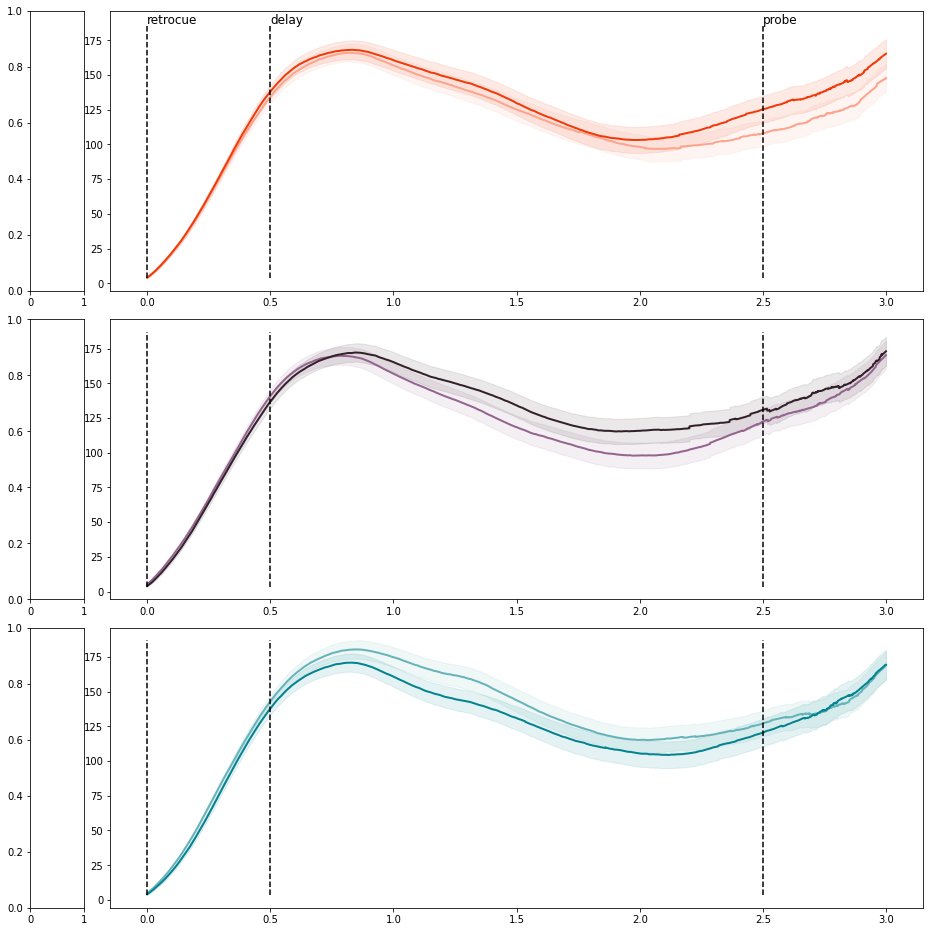

In [127]:
#previous trial is bright
x,y = pupilPlot(cleanPupRetro2[cleanPupRetro2.cuedItemPreviousTrl =='bri'],None,
          levels = ['cue_blk_validity','cued_item'],cList = cList)

no baseline passed in


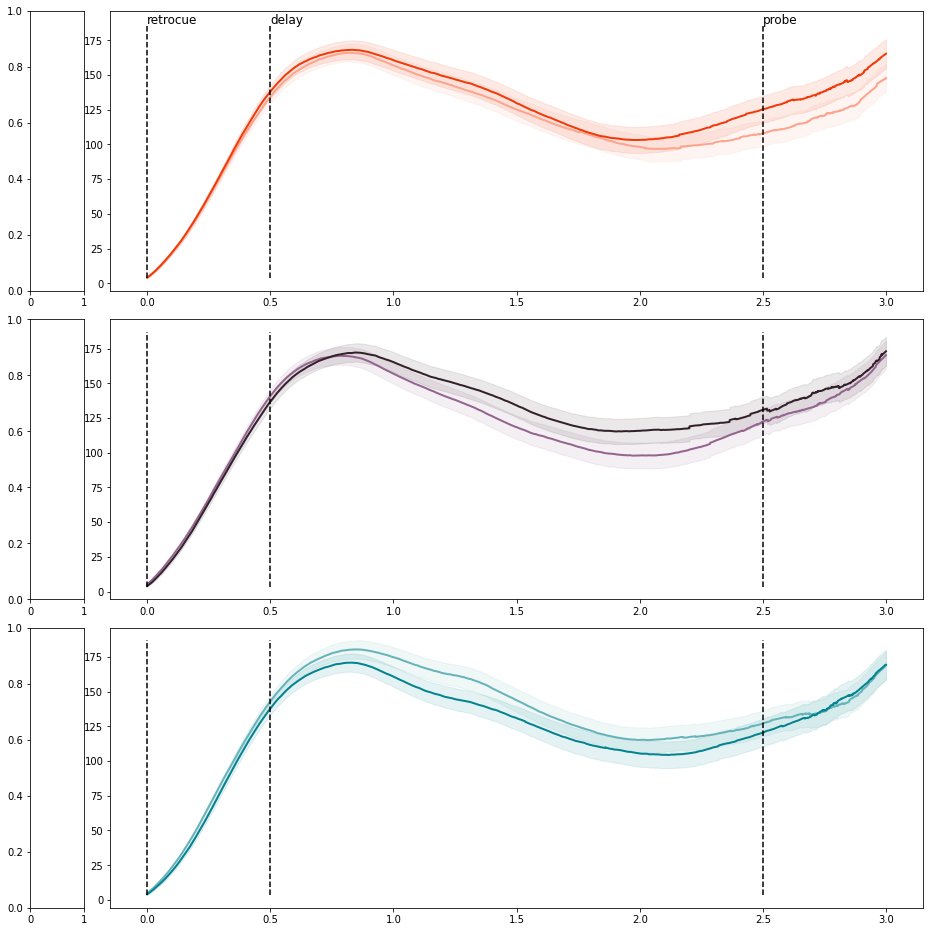

In [135]:
x,y = pupilPlot(cleanPupRetro2[cleanPupRetro2.cuedItemPreviousTrl =='bri'],None,
          levels = ['cue_blk_validity','cued_item'],cList = cList)

no baseline passed in


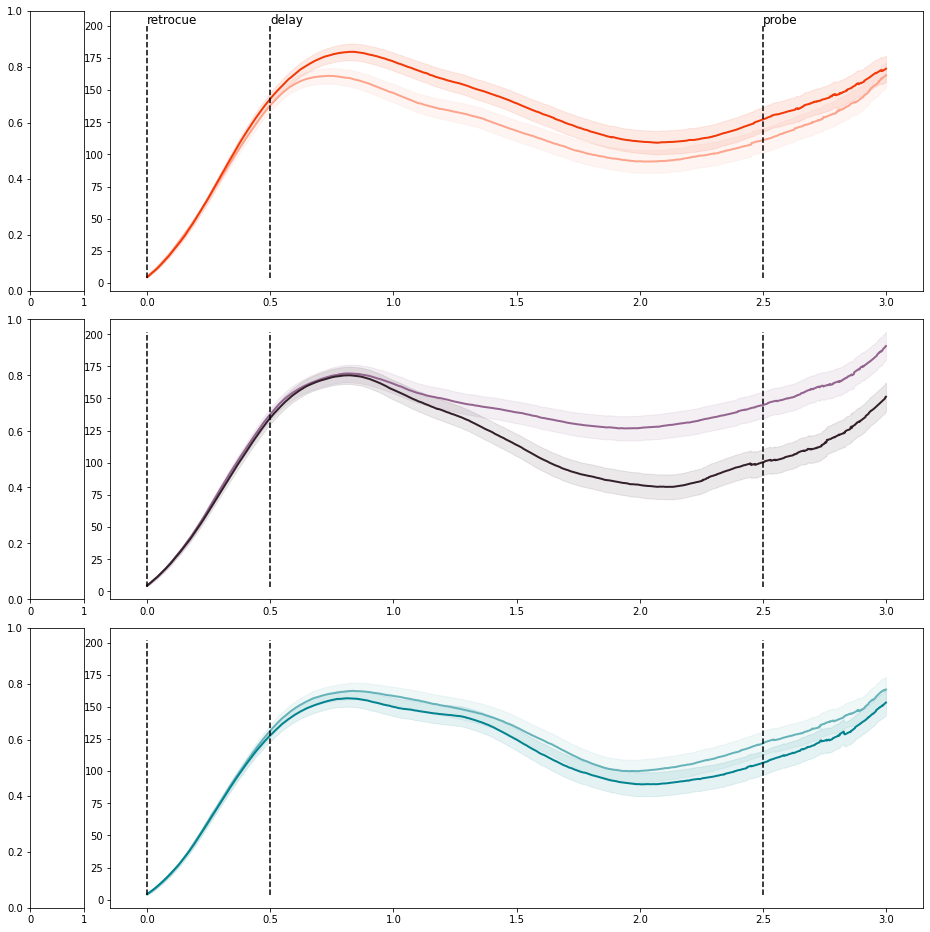

In [137]:
#previous trial is dark
j,q = pupilPlot(cleanPupRetro2[cleanPupRetro2.cuedItemPreviousTrl =='dar'],None,
          levels = ['cue_blk_validity','cued_item'],cList = cList,)

no baseline passed in


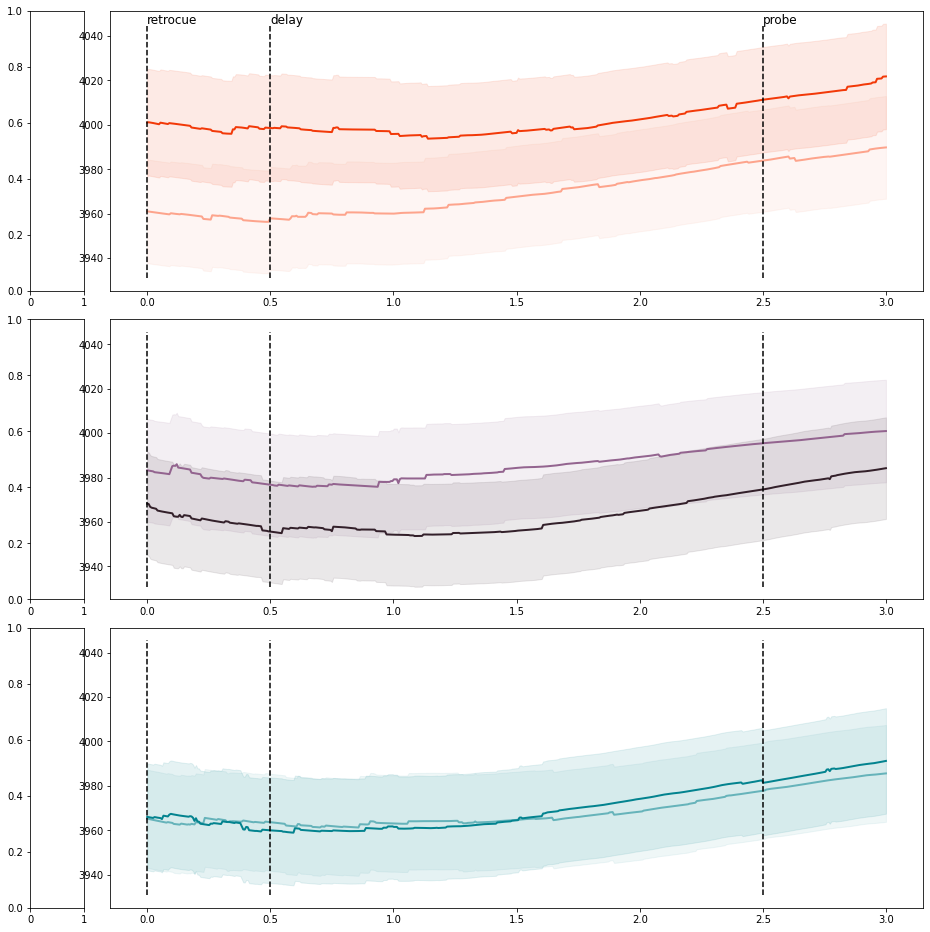

In [174]:

a,b = pupilPlot(pupCleanUnnorm_BL2[pupCleanUnnorm_BL2.cuedItemPreviousTrl =='bri'].drop(columns = 'participant'),None,
          levels = ['cue_blk_validity','cued_item'],cList = cList,)

no baseline passed in


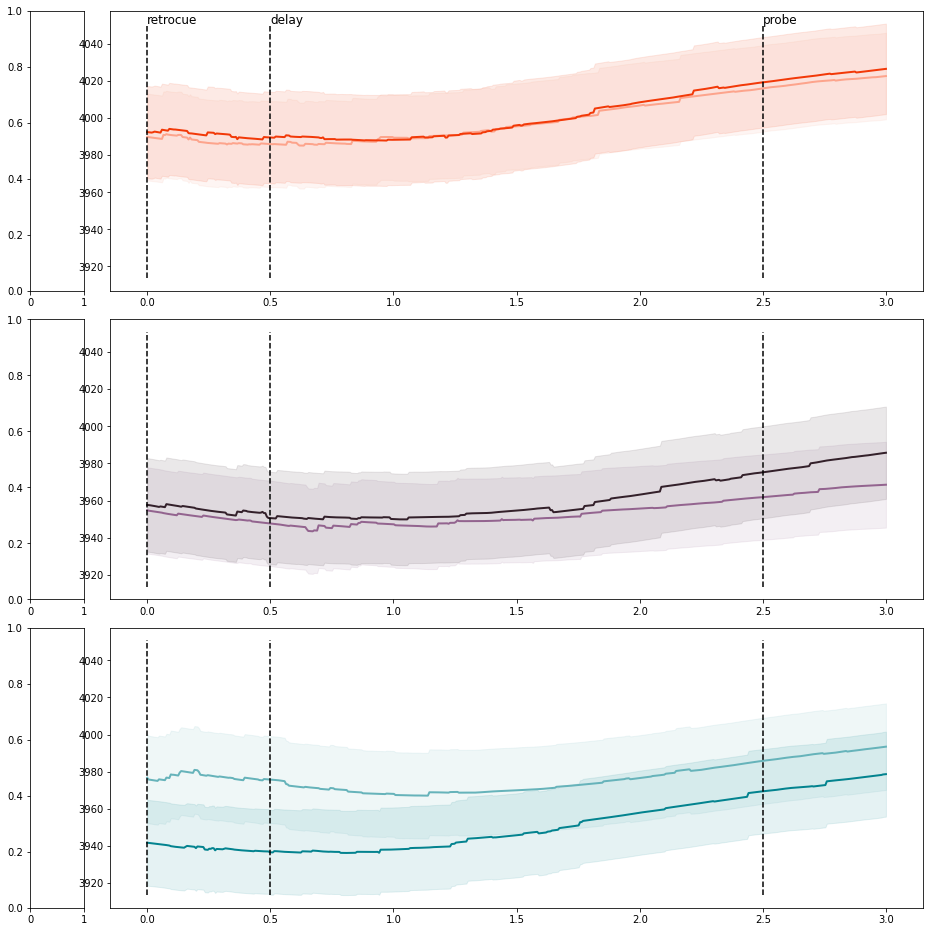

In [175]:
c,d = pupilPlot(pupCleanUnnorm_BL2[pupCleanUnnorm_BL2.cuedItemPreviousTrl =='dar'].drop(columns = 'participant'),None,
          levels = ['cue_blk_validity','cued_item'],cList = cList,)


[[<matplotlib.lines.Line2D at 0x16f1c097ca0>],

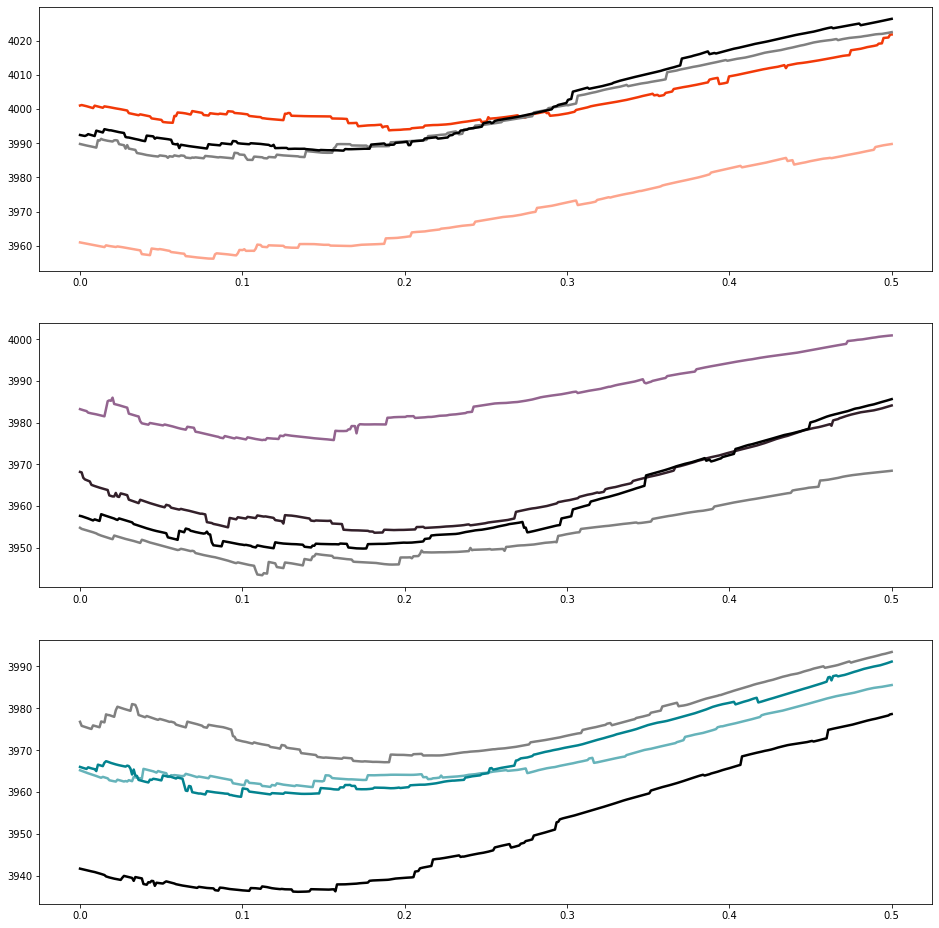

In [182]:
fig,ax = plt.subplots(nrows= 3, sharex=False, sharey = False)

[ax[i//2].plot(np.linspace(0,0.5,500),a.iloc[i,:500],linewidth = 2.5,color = cList[i],) for i in range(6) ]
[ax[i//2].plot(np.linspace(0,0.5,500),c.iloc[i,:500],linewidth = 2.5,color = cList2[i],) for i in range(6) ]

# save shift

shiftDf_relX.to_csv('gsRelX.csv')
shiftDf_absX.to_csv('gsAbsX.csv')
shiftDf_ctrX.to_csv('gsCtrX.csv')


shiftDf_relY.to_csv('gsRelY.csv')
shiftDf_absY.to_csv('gsAbsY.csv')
shiftDf_ctrY.to_csv('gsCtrY.csv')

tx.to_csv('gsIndex.csv')


# save shift magnitude towardness

In [ ]:
away_magX.to_csv('gsRelX_away.csv')
toward_magX.to_csv('gsRelX_toward.csv')

In [41]:
towardMagCnt.to_csv('towardMagCnt.csv')
awayMagCnt.to_csv('awayMagCnt.csv')